<a href="https://colab.research.google.com/github/mounsifelatouch/cdd/blob/master/notebooks/4_cdd_ml_part_4_model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bioinformatics Project - Computational Drug Discovery [Part 4] Classification Models Building**

**MOUNSIF EL ATOUCH**

In this Jupyter notebook, we will be building a machine learning model using the ChEMBL bioactivity data.

In **Part 4**, we will be building classification models

---

## **1. Installing librairies**

## **2. Importing libraries**

In [83]:
import os
import pandas as pd

from scipy.spatial.distance import *
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

seed = 123

from sklearn.model_selection import *
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import *

from scipy.stats import randint, uniform

from scipy import interp
from sklearn.metrics import RocCurveDisplay

import warnings
warnings.filterwarnings('ignore')

In [63]:
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC  
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

## **3. Functions**

In [64]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [65]:
def print_auc(clf, X_train, y_train, X_test, y_test, model_name) :
    
    clf = clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, thr = roc_curve(y_test,  y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=model_name+" auc="+str(roc_auc))
    plt.legend(loc=4)
    plt.title("ROC curve")

    plt.show()
    # Data to plot precision - recall curve
    precision, recall, thresholds_log = precision_recall_curve(y_test, y_pred_proba)
    # Use AUC function to calculate the area under the curve of precision recall curve
    auc_precision_recall = auc(recall, precision)
    
    plt.plot(recall, precision, label=model_name+" auc_prc="+str(auc_precision_recall))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc=4)
    plt.title("Precision-Recall Curve")

    plt.show()
    print_score(clf, X_train, y_train, X_test, y_test, train=True)
    print_score(clf, X_train, y_train, X_test, y_test, train=False)
    precision_sc=precision_score(y_test, clf.predict(X_test), average=None)
    recall_sc = recall_score(y_test, clf.predict(X_test), average=None)
    test_score = accuracy_score(y_test, clf.predict(X_test)) * 100
    train_score = accuracy_score(y_train, clf.predict(X_train)) * 100
    f1 = f1_score(y_test, clf.predict(X_test))
    print_score(clf, X_train, y_train, X_test, y_test, train=True)
    metriques = {"fpr" : fpr, "recall_sc" : recall_sc, "precision_sc" : precision_sc, "tpr" : tpr,
                 "test_score" : test_score, "train_score" : train_score, "f1" : f1,
                 "auc_pr" : auc_precision_recall, "auc": roc_auc}
    return metriques

In [66]:
def metrics(X_train, X_test, y_train, y_test, model):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print("Training set accuracy: {:.2f}".format(model.score(X_train, y_train)))
    print("Test set accuracy: {:.2f}".format(model.score(X_test, y_test)))
    print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
    print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
    print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
    print("ROC AUC score: {:.2f}".format(roc_auc_score(y_test, y_proba)))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print("True Negatives: {:.0f}".format(tn))
    print("False Positives: {:.0f}".format(fp))
    print("False Negatives: {:.0f}".format(fn))
    print("TruePositives: {:.0f}".format(tp))
    print("-------------------------------------")
    return

## **4. Load the data set**

In [67]:
! wget https://raw.githubusercontent.com/mounsifelatouch/cdd/master/data/bioactivity_data_PubchemFingerprinter.csv

--2023-06-05 18:16:12--  https://raw.githubusercontent.com/mounsifelatouch/cdd/master/data/bioactivity_data_PubchemFingerprinter.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1090920 (1.0M) [text/plain]
Saving to: 'bioactivity_data_PubchemFingerprinter.csv'

     0K .......... .......... .......... .......... ..........  4%  517K 2s
    50K .......... .......... .......... .......... ..........  9%  327K 2s
   100K .......... .......... .......... .......... .......... 14%  662K 2s
   150K .......... .......... .......... .......... .......... 18%  301K 2s
   200K .......... .......... .......... .......... .......... 23% 15.6M 2s
   250K .......... .......... .......... .......... .......... 28% 50.3M 1s
   300K .......... .......... .......... ......

In [68]:
df = pd.read_csv('bioactivity_data_PubchemFingerprinter.csv')

## **5. Input features**

### **5.1. Input features**

In [69]:
X = df.drop('activity', axis=1)

### **5.2. Output features**

In [70]:
y = df['activity']

In [71]:
# count the number of instances in each class
counts = y.value_counts()

# calculate the ratio of the negative class to the positive class
imbalance_ratio = counts[0] / counts[1]

### **5.3. Let's examine the data dimension**

In [72]:
X.shape, y.shape

((612, 881), (612,))

### **5.4. Remove low variance features**

In [73]:
# Create a VarianceThreshold object
selector = VarianceThreshold(threshold=.01)

# Fit the selector to the data and transform the data
selector.fit_transform(X)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = X.columns[selected_indices]

X_reduced = X[selected_features]

In [74]:
X.shape, X_reduced.shape

((612, 881), (612, 428))

## **6. Data split (80/20 ratio)**

In [75]:
n = np.arange(len(X_reduced))
idx_train, idx_test = train_test_split(n, stratify=y, test_size=.2, random_state=seed)

In [76]:
X1_train, y1_train = X_reduced.loc[idx_train], y.loc[idx_train]
X1_test, y1_test = X_reduced.loc[idx_test], y.loc[idx_test]

In [77]:
X1_train.shape, y1_train.shape

((489, 428), (489,))

In [78]:
X1_test.shape, y1_test.shape

((123, 428), (123,))



---



In [79]:
X = X1_train.reset_index(drop=True)
y = y1_train.reset_index(drop=True)
X1_test = X1_test.reset_index(drop=True)
y1_test = y1_test.reset_index(drop=True)

In [80]:
n_samples, n_classes = X.shape[0], 2
class_weights = dict(zip(np.unique(y), n_samples / (n_classes * np.bincount(y))))

## **7. Modeling**

## **Logistic Regression**

Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8654199452118669
Best Hyperparameters: {'C': 0.6545408406904539, 'class_weight': 'balanced', 'max_iter': 226, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy: 0.9183673469387755, Precision: 0.8695652173913043, Recall: 0.8, f1_score: 0.8333333333333333
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8550303892409156
Best Hyperparameters: {'C': 31.08835092543452, 'class_weight': None, 'max_iter': 186, 'penalty': 'none', 'solver': 'sag'}
Accuracy: 0.9183673469387755, Precision: 0.8, Recall: 0.9230769230769231, f1_score: 0.8571428571428571
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8657309941520467
Best Hyperparameters: {'C': 17.251502465886304, 'c

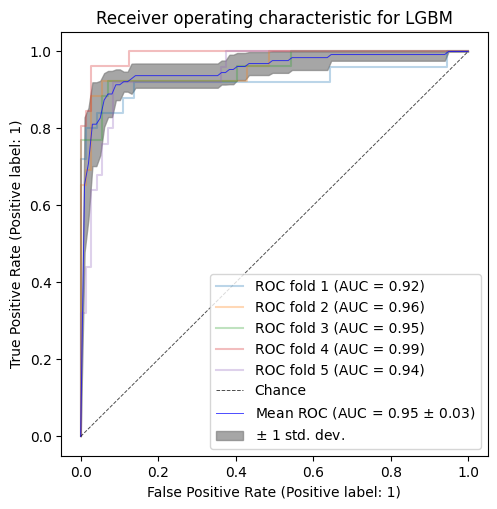

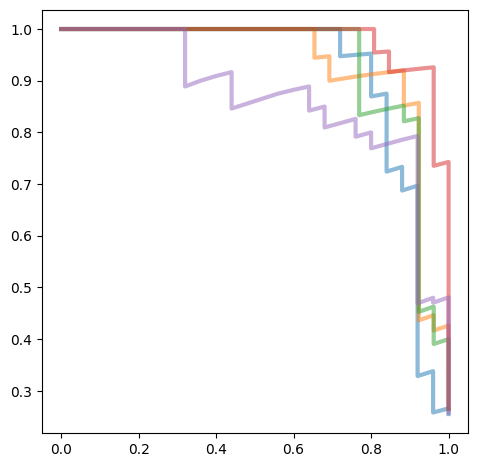

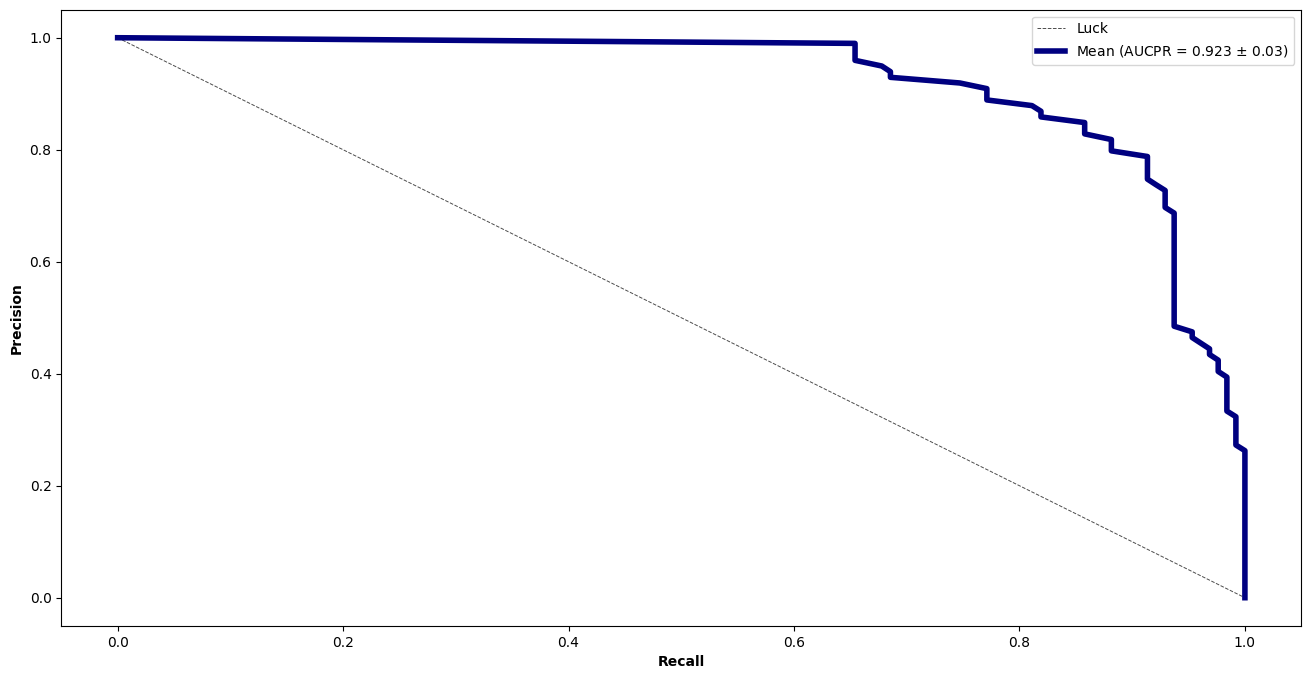

List of possible accuracy: 
 [0.8333333333333333, 0.8571428571428571, 0.8695652173913044, 0.9090909090909091, 0.7755102040816326]
Maximum Accuracy That can be obtained from this model is: 
 90.9090909090909 %
Minimum Accuracy: 
 77.55102040816327 %
Overall Accuracy: 
 84.89285042080073 %
Standard Deviation is: 
 0.04936172767058213
List of possible accuracy for trainning: [98.46547314578005, 99.23273657289002, 98.9769820971867, 98.46547314578005, 99.23469387755102]
List of possible accuracy for testing: [91.83673469387756, 91.83673469387756, 93.87755102040816, 94.89795918367348, 88.65979381443299]
Mean Accuracy: 0.9222175468125394, Mean Precision: 0.8646601699150425, Mean Recall: 0.8427692307692307, Mean f1_score: 0.7755102040816326


In [85]:
from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression()

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

space = dict()
space['class_weight'] = [class_weights, None, 'balanced']
space['solver'] = ['lbfgs', 'liblinear', 'newton-cg', 'sag']
space['penalty'] = ['l1', 'l2', 'none']
space['C'] = uniform(0.1, 100)
space['max_iter'] = randint(100, 500)


train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=space, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1, random_state=seed)
for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy: \n', lst_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is: \n', max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy: \n', min(lst_accu_stratified)*100, '%')
print('Overall Accuracy: \n', mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is: \n', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [86]:
model1 = LogisticRegression(C=1.7118630423373915, class_weight='balanced', max_iter=335, penalty='l2', solver='sag', random_state=seed).fit(X1_train, y1_train)

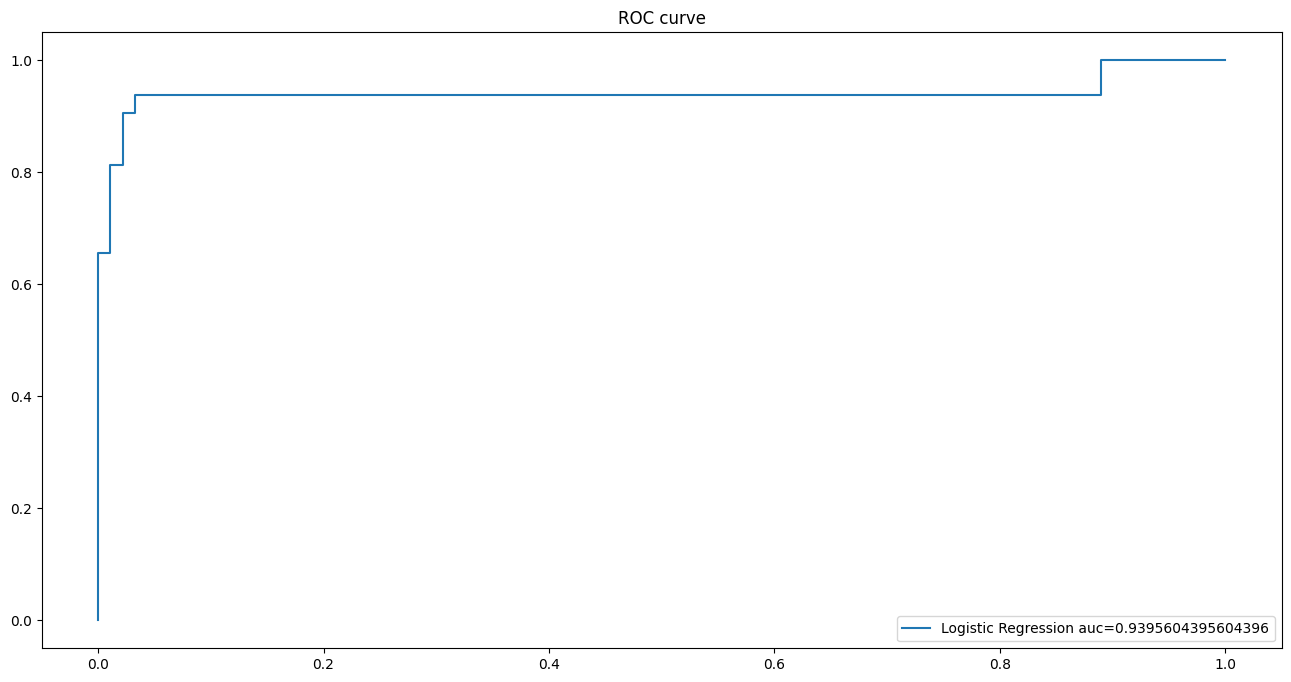

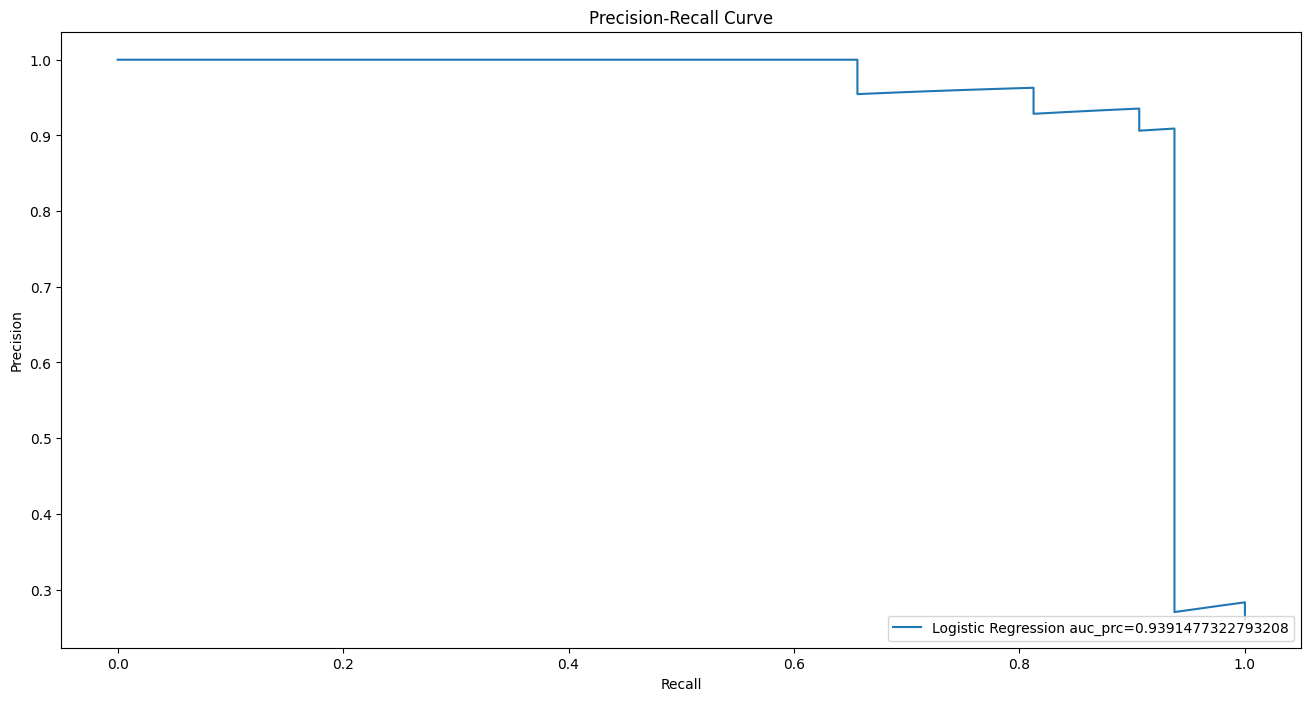

Train Result:
Accuracy Score: 98.57%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    1.000000    0.948148  0.985685    0.974074      0.986427
recall       0.980609    1.000000  0.985685    0.990305      0.985685
f1-score     0.990210    0.973384  0.985685    0.981797      0.985806
support    361.000000  128.000000  0.985685  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[354   7]
 [  0 128]]

Test Result:
Accuracy Score: 95.12%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.977528   0.882353   0.95122    0.929941      0.952767
recall      0.956044   0.937500   0.95122    0.946772      0.951220
f1-score    0.966667   0.909091   0.95122    0.937879      0.951688
support    91.000000  32.000000   0.95122  123.000000    123.000000
___

Model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
Logistic Regression,0.909091,0.939560,0.939148,0.956044,0.937500,0.977528,0.882353


In [87]:
clf = print_auc(model1, X1_train, y1_train, X1_test, y1_test, 'Logistic Regression')
results_df = pd.DataFrame(data=[['Logistic Regression', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]], 
                          columns=['Model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])

results_df.style.hide_index()

## **SVC**

Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8969686210077887
Best Hyperparameters: {'C': 24.4666374536874, 'class_weight': None, 'degree': 4, 'gamma': 'auto'}
Accuracy: 0.9183673469387755, Precision: 0.9047619047619048, Recall: 0.76, f1_score: 0.8260869565217391
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8621739663844927
Best Hyperparameters: {'C': 52.04851192598093, 'class_weight': None, 'degree': 2, 'gamma': 'auto'}
Accuracy: 0.9285714285714286, Precision: 0.8275862068965517, Recall: 0.9230769230769231, f1_score: 0.8727272727272727
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8887221179904106
Best Hyperparameters: {'C': 13.941557278158978, 'class_weight': {0: 0.6772853185595568, 1: 1

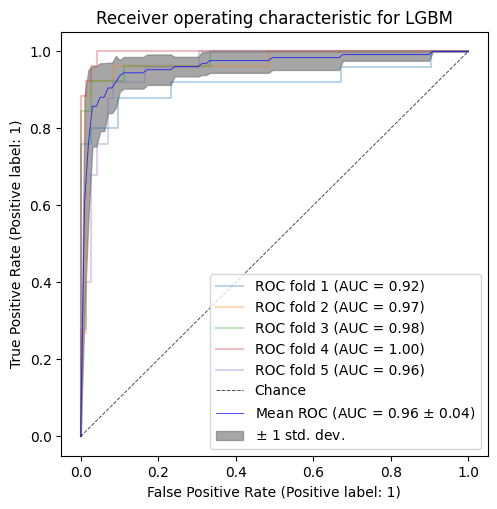

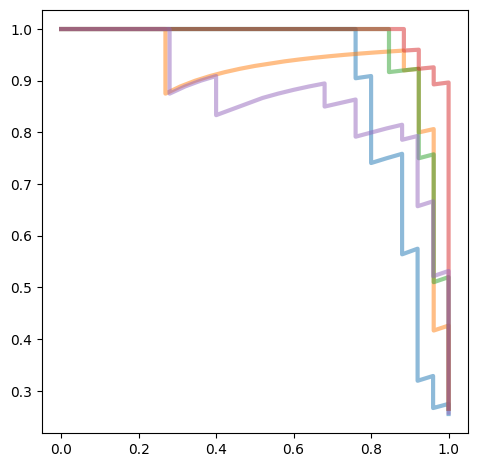

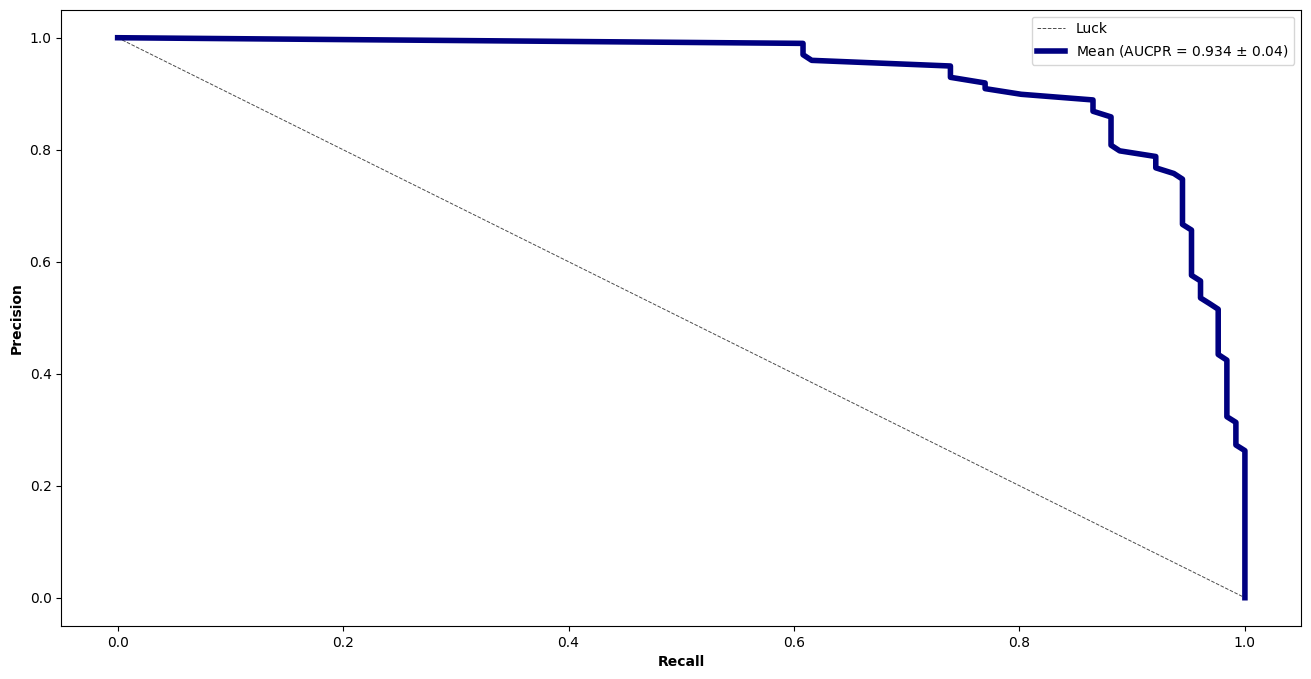

List of possible accuracy: 
 [0.8260869565217391, 0.8727272727272727, 0.9166666666666666, 0.9433962264150944, 0.851851851851852]
Maximum Accuracy That can be obtained from this model is: 
 94.33962264150944 %
Minimum Accuracy: 
 82.6086956521739 %
Overall Accuracy: 
 88.2145794836525 %
Standard Deviation is: 
 0.04767685721070148
List of possible accuracy for trainning: [97.9539641943734, 98.9769820971867, 96.9309462915601, 95.9079283887468, 97.44897959183673]
List of possible accuracy for testing: [91.83673469387756, 92.85714285714286, 95.91836734693877, 96.93877551020408, 91.75257731958763]
Mean Accuracy: 0.9386071954555018, Mean Precision: 0.890275497172049, Mean Recall: 0.8821538461538463, Mean f1_score: 0.851851851851852


In [88]:
from sklearn.svm import SVC  

clf1 = SVC(probability=True)

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

param_grid = {'C': uniform(0.1, 100),
              'degree': randint(2, 5),
              'gamma': ['scale', 'auto'],
              'class_weight': [None, 'balanced', class_weights]}

train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=param_grid, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1, random_state=seed)
for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy: \n', lst_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is: \n', max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy: \n', min(lst_accu_stratified)*100, '%')
print('Overall Accuracy: \n', mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is: \n', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [89]:
model2 = SVC(C=10.9928952239709, kernel='rbf', gamma='auto', class_weight={0: 0.6772853185595568, 1: 1.91015625}, probability=True, degree=3, random_state=seed).fit(X1_train, y1_train)

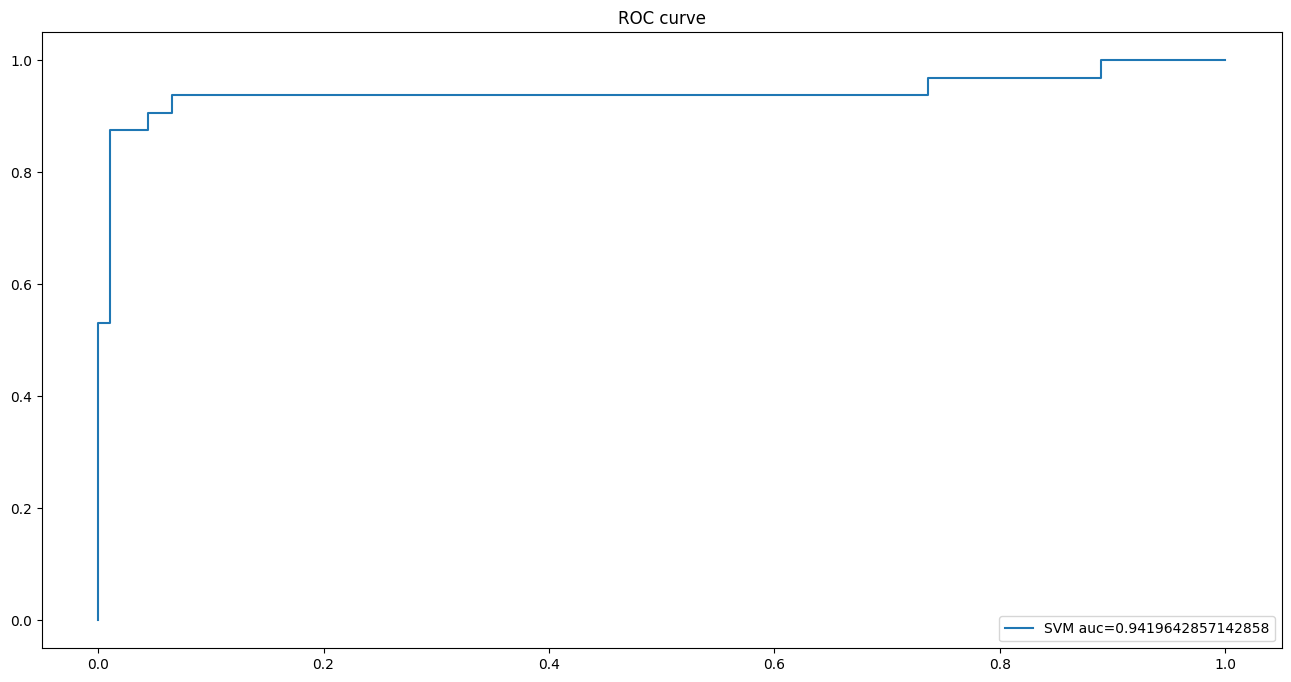

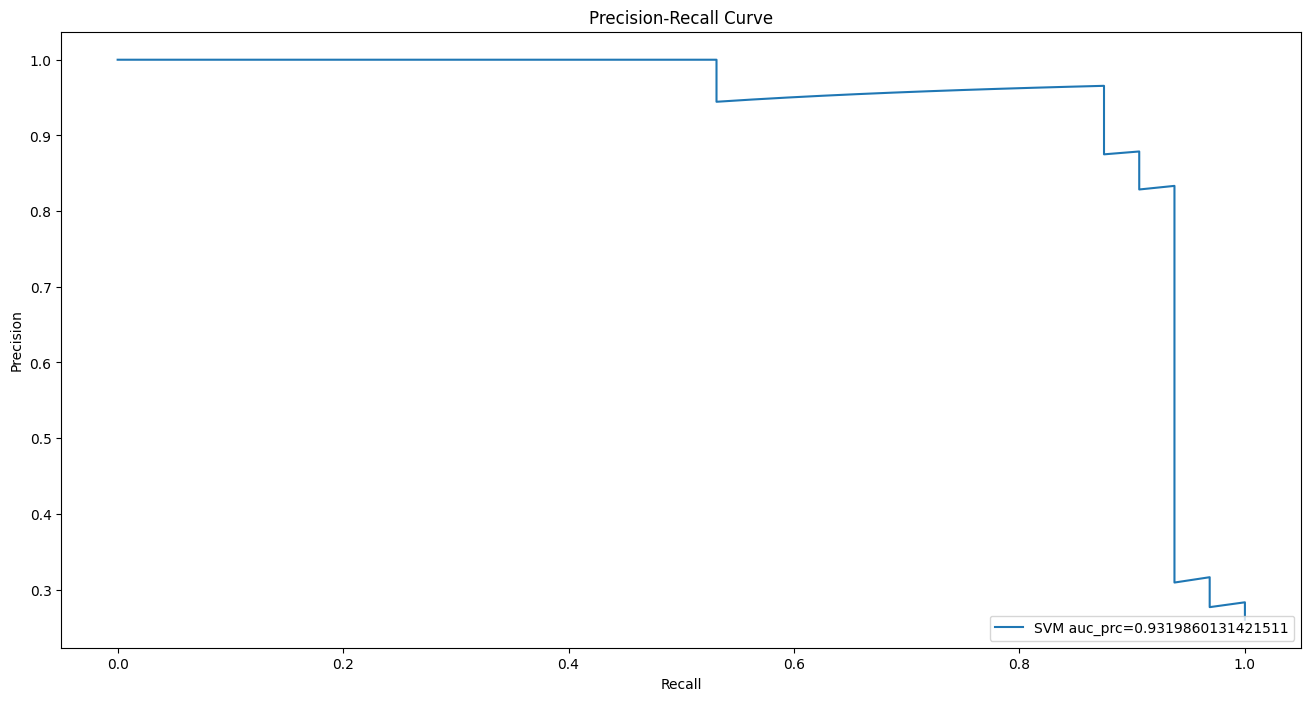

Train Result:
Accuracy Score: 96.52%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.983146    0.917293  0.965235    0.950220      0.965909
recall       0.969529    0.953125  0.965235    0.961327      0.965235
f1-score     0.976290    0.934866  0.965235    0.955578      0.965447
support    361.000000  128.000000  0.965235  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[350  11]
 [  6 122]]

Test Result:
Accuracy Score: 93.50%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.966292   0.852941  0.934959    0.909617      0.936802
recall      0.945055   0.906250  0.934959    0.925652      0.934959
f1-score    0.955556   0.878788  0.934959    0.917172      0.935583
support    91.000000  32.000000  0.934959  123.000000    123.000000
___

Model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
Logistic Regression,0.909091,0.939560,0.939148,0.956044,0.937500,0.977528,0.882353
SVM,0.878788,0.941964,0.931986,0.945055,0.906250,0.966292,0.852941


In [90]:
clf = print_auc(model2, X1_train, y1_train, X1_test, y1_test, 'SVM')
results_df2 = pd.DataFrame(data=[['SVM', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]],  
                          columns=['Model', 'f1_score', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df2)

results_df.style.hide_index()

## **Gradient Boosting Classifier**

Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8588644688644689
Best Hyperparameters: {'learning_rate': 0.6516525610789553, 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 847, 'subsample': 0.8458952322021707}
Accuracy: 0.9285714285714286, Precision: 0.9090909090909091, Recall: 0.8, f1_score: 0.8510638297872342
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8726592900790591
Best Hyperparameters: {'learning_rate': 0.6344522678994391, 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 504, 'subsample': 0.8059428437235299}
Accuracy: 0.9285714285714286, Precision: 0.8275862068965517, Recall: 0.9230769230769231, f1_score: 0.8727272727272727
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0

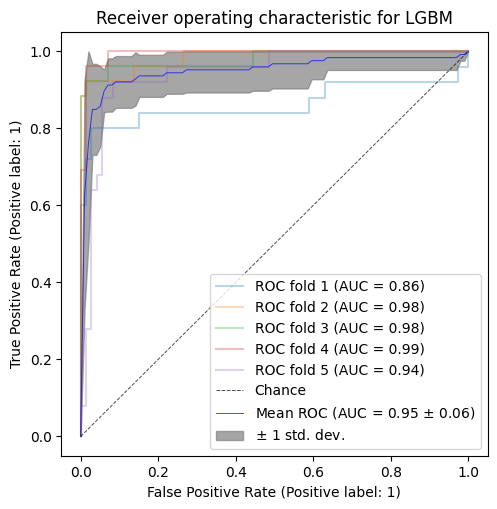

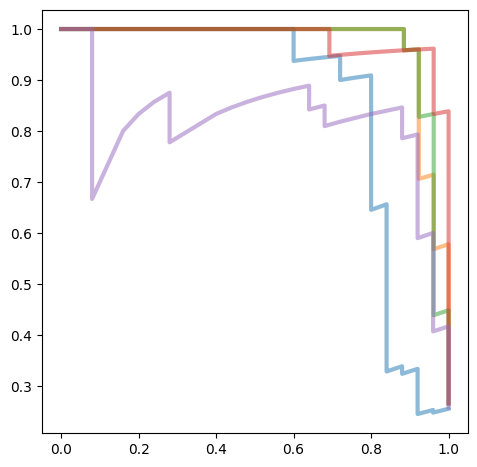

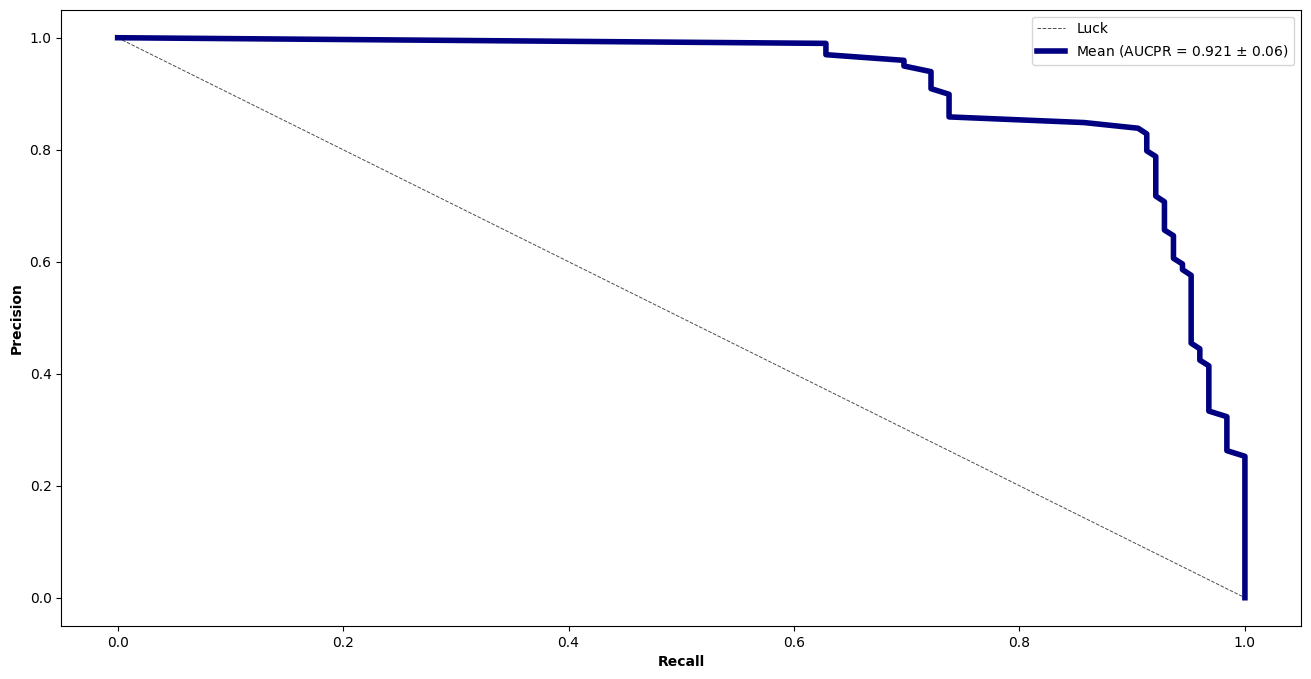

List of possible accuracy: 
 [0.8510638297872342, 0.8727272727272727, 0.8936170212765957, 0.9090909090909091, 0.816326530612245]
Maximum Accuracy That can be obtained from this model is: 
 90.9090909090909 %
Minimum Accuracy: 
 81.6326530612245 %
Overall Accuracy: 
 86.85651126988513 %
Standard Deviation is: 
 0.036477480157872534
List of possible accuracy for trainning: [99.74424552429667, 100.0, 99.74424552429667, 100.0, 99.74489795918367]
List of possible accuracy for testing: [92.85714285714286, 92.85714285714286, 94.89795918367348, 94.89795918367348, 90.72164948453609]
Mean Accuracy: 0.9324637071323375, Mean Precision: 0.886415882967607, Mean Recall: 0.8584615384615384, Mean f1_score: 0.816326530612245


In [91]:
from sklearn.ensemble import GradientBoostingClassifier

clf1 = GradientBoostingClassifier()

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

param_grid = {'learning_rate': uniform(1e-5, 1),
              'subsample': uniform(0.8, 1),
              'n_estimators' : randint(100, 1000),
              'max_features' : ['log2', 'sqrt', 'auto'],
              'max_depth': randint(3, 10)}

train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=param_grid, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1, random_state=seed)
for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy: \n', lst_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is: \n', max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy: \n', min(lst_accu_stratified)*100, '%')
print('Overall Accuracy: \n', mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is: \n', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [92]:
model3 = GradientBoostingClassifier(learning_rate=0.5019073605524252, max_depth=7, max_features='sqrt', n_estimators=645, subsample=0.9173984371914893, random_state=seed).fit(X1_train, y1_train)

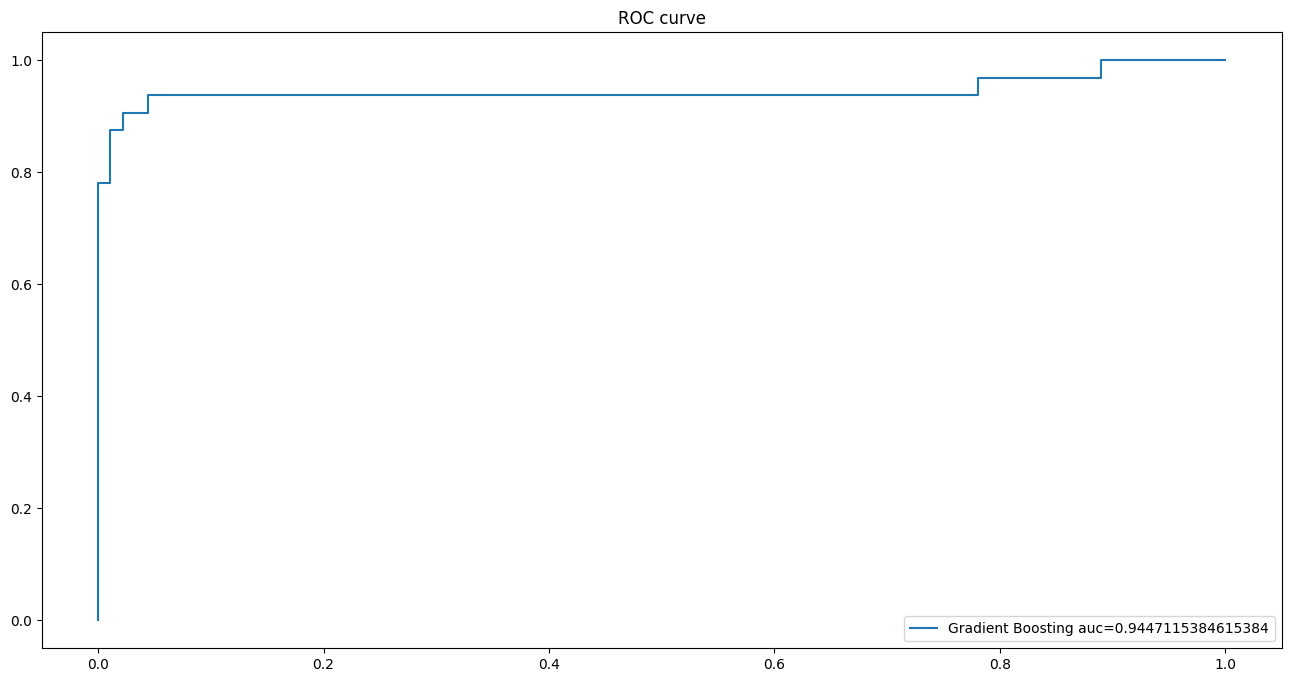

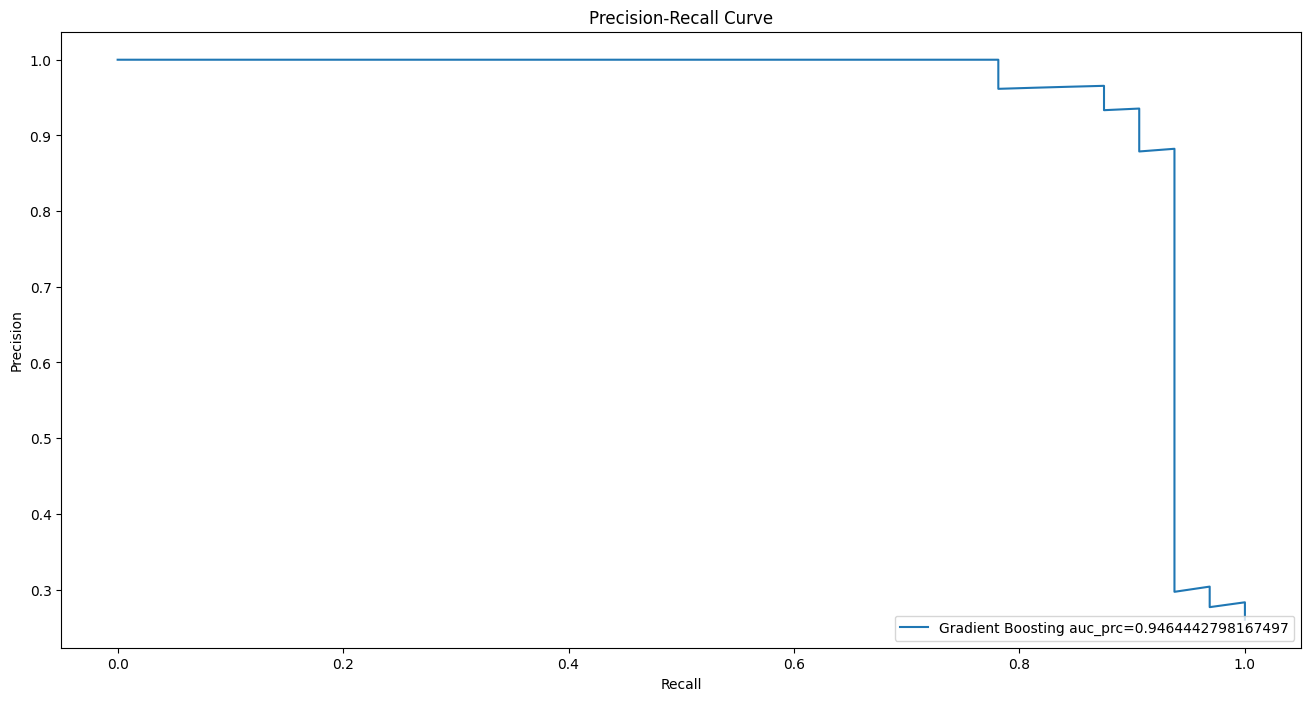

Train Result:
Accuracy Score: 99.80%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    1.000000    0.992248  0.997955    0.996124      0.997971
recall       0.997230    1.000000  0.997955    0.998615      0.997955
f1-score     0.998613    0.996109  0.997955    0.997361      0.997958
support    361.000000  128.000000  0.997955  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[360   1]
 [  0 128]]

Test Result:
Accuracy Score: 95.12%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy   macro avg  weighted avg
precision   0.967033   0.90625   0.95122    0.936641       0.95122
recall      0.967033   0.90625   0.95122    0.936641       0.95122
f1-score    0.967033   0.90625   0.95122    0.936641       0.95122
support    91.000000  32.00000   0.95122  123.000000     123.00000
________

Model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
Logistic Regression,0.909091,0.939560,0.939148,0.956044,0.937500,0.977528,0.882353
SVM,0.878788,0.941964,0.931986,0.945055,0.906250,0.966292,0.852941
Gradient Boosting,0.906250,0.944712,0.946444,0.967033,0.906250,0.967033,0.906250


In [93]:
clf = print_auc(model3, X1_train, y1_train, X1_test, y1_test, 'Gradient Boosting')
results_df3 = pd.DataFrame(data=[['Gradient Boosting', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]], 
                          columns=['Model', 'f1_score', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df3)

results_df.style.hide_index()

## **Random Forest**

Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8990610646424599
Best Hyperparameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 682}
Accuracy: 0.9183673469387755, Precision: 0.9047619047619048, Recall: 0.76, f1_score: 0.8260869565217391
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8528617192288566
Best Hyperparameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 362}
Accuracy: 0.9489795918367347, Precision: 0.8888888888888888, Recall: 0.9230769230769231, f1_score: 0.9056603773584906
Fitting 5 folds for each of 100 candidates, totalling 500 fits
----------------------------

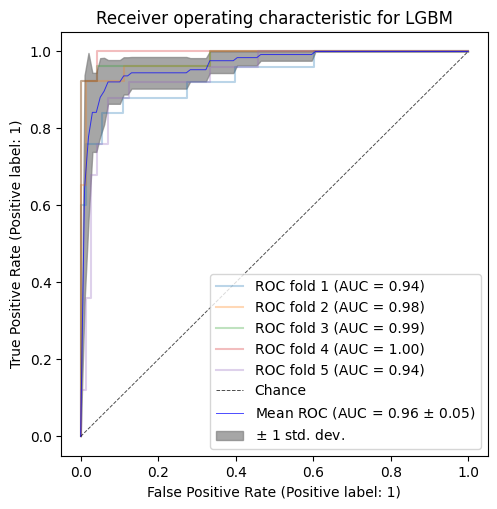

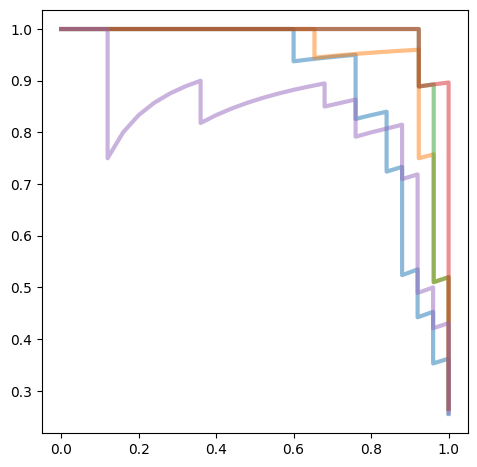

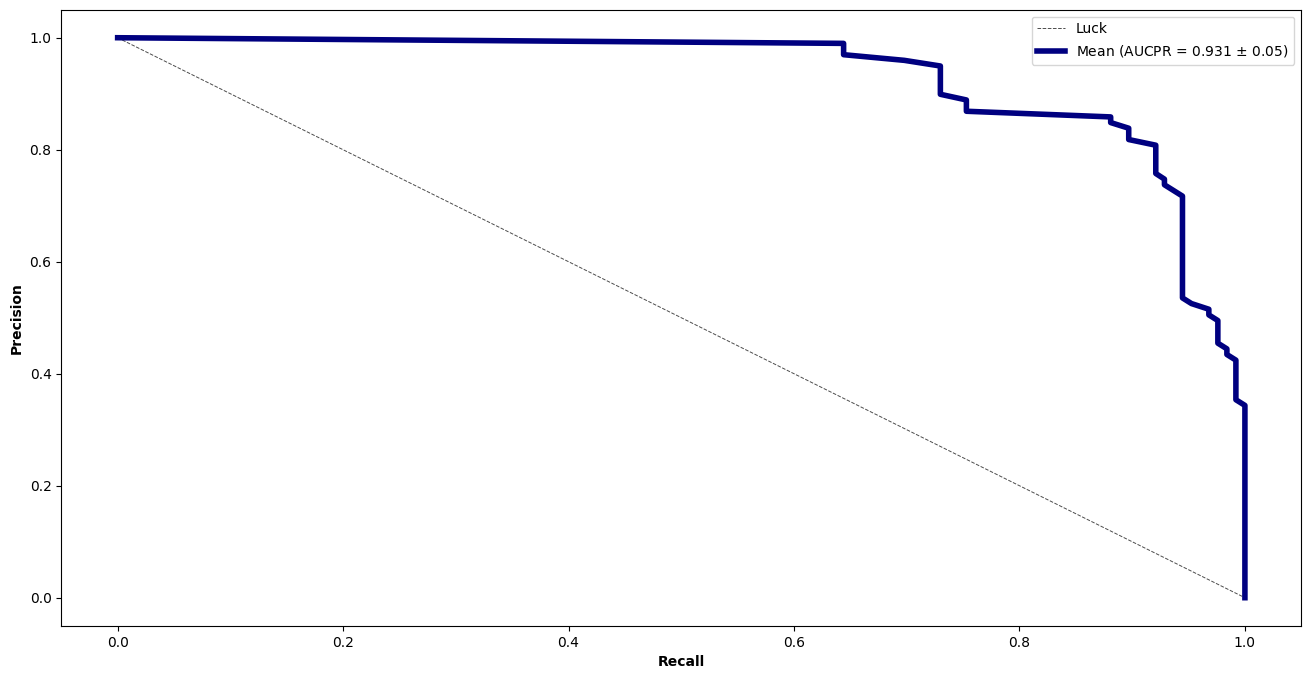

List of possible accuracy: [0.8260869565217391, 0.9056603773584906, 0.8695652173913044, 0.9600000000000001, 0.8085106382978724]

Maximum Accuracy That can be obtained from this model is: 96.00000000000001 %

Minimum Accuracy: 80.85106382978724 %

Overall Accuracy: 87.39646379138813 %

Standard Deviation is: 0.06124246233289564
List of possible accuracy for trainning: [97.44245524296676, 96.67519181585678, 98.9769820971867, 96.41943734015345, 97.95918367346938]
List of possible accuracy for testing: [91.83673469387756, 94.89795918367348, 93.87755102040816, 97.95918367346938, 90.72164948453609]
Mean Accuracy: 0.9385861561119293, Mean Precision: 0.9314574314574313, Mean Recall: 0.827076923076923, Mean f1_score: 0.8085106382978724


In [95]:
from sklearn.ensemble import RandomForestClassifier

clf1 = RandomForestClassifier(random_state=seed)

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

param_grid = {'n_estimators': randint(50, 1000),
              'max_depth': randint(3, 10),
              'min_samples_split': randint(2, 10),
              'min_samples_leaf': randint(1, 5),
              'max_features': ['sqrt', 'log2', None],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'class_weight' : ['balanced', None, class_weights]}

train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=param_grid, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1, random_state=seed)
for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:', max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:', min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:', mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [96]:
model4 = RandomForestClassifier(n_estimators=801, max_depth=9, min_samples_split=2, min_samples_leaf=2, max_features='sqrt',
                                criterion='log_loss', class_weight={0: 0.6772853185595568, 1: 1.91015625}, random_state=seed).fit(X1_train, y1_train)

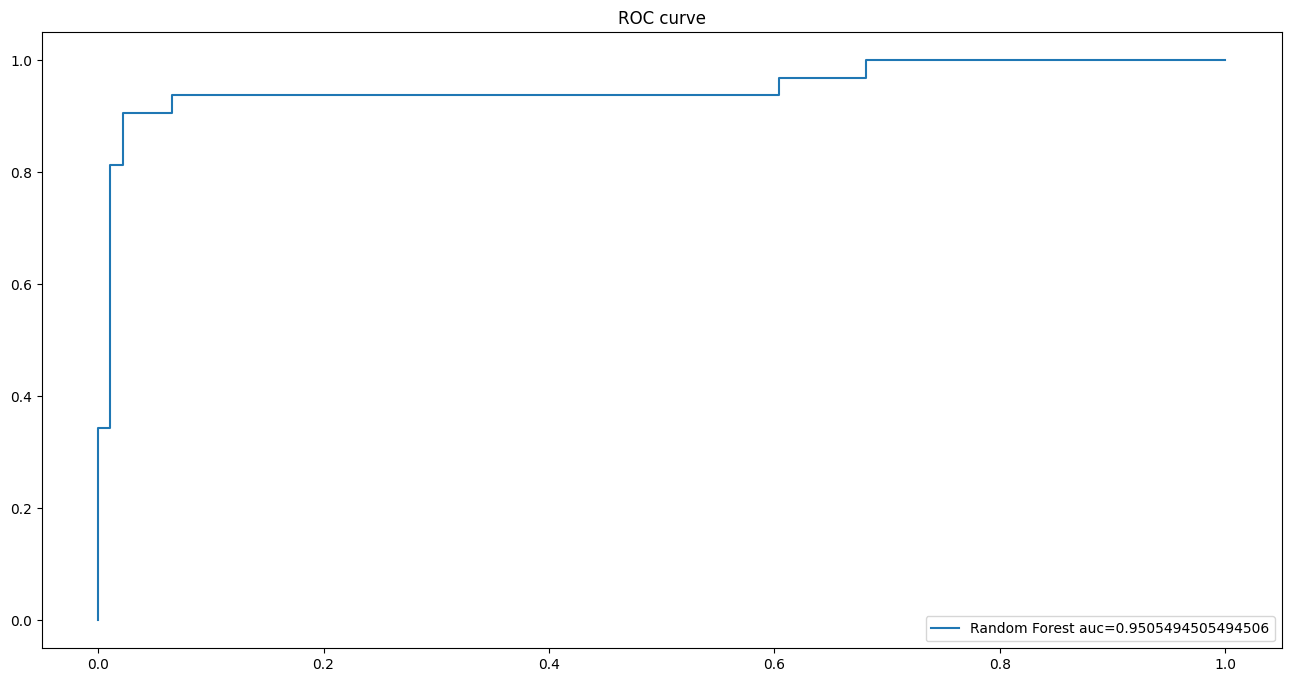

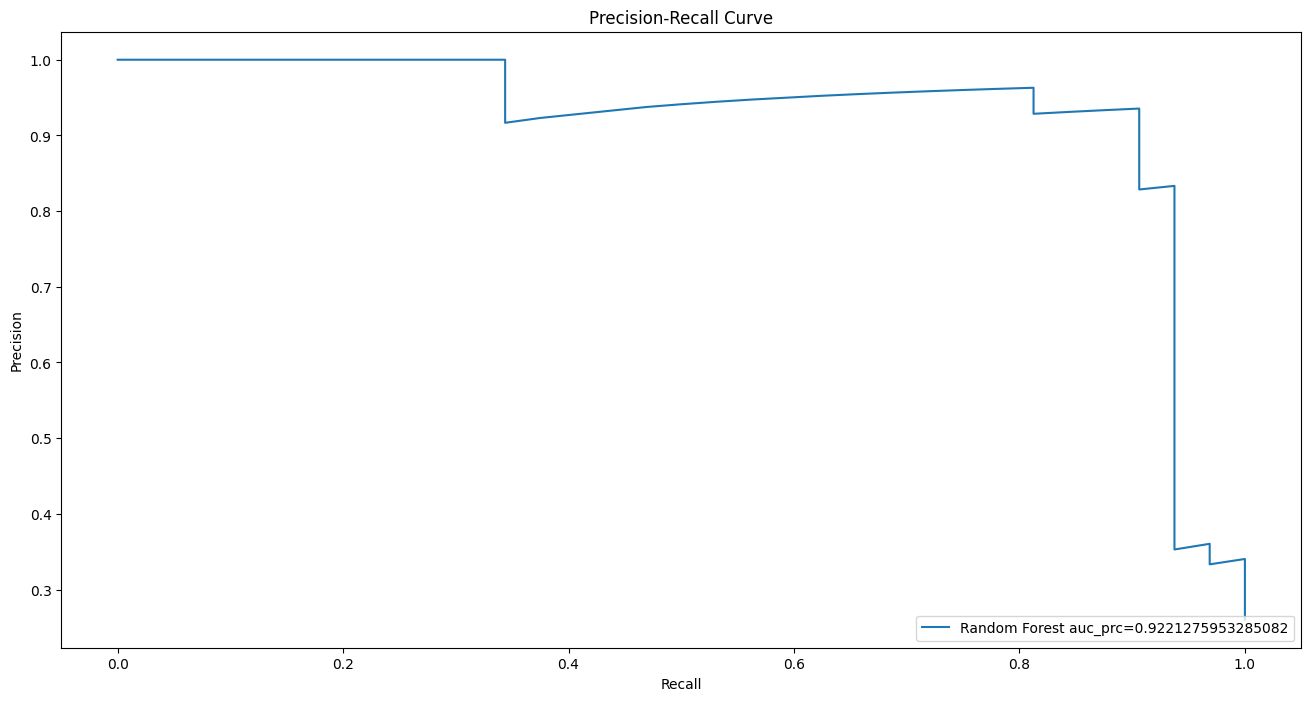

Train Result:
Accuracy Score: 97.55%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.980716    0.960317   0.97546    0.970517      0.975377
recall       0.986150    0.945312   0.97546    0.965731      0.975460
f1-score     0.983425    0.952756   0.97546    0.968091      0.975397
support    361.000000  128.000000   0.97546  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[356   5]
 [  7 121]]

Test Result:
Accuracy Score: 94.31%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.966667   0.878788  0.943089    0.922727      0.943804
recall      0.956044   0.906250  0.943089    0.931147      0.943089
f1-score    0.961326   0.892308  0.943089    0.926817      0.943370
support    91.000000  32.000000  0.943089  123.000000    123.000000
___

Model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
Logistic Regression,0.909091,0.939560,0.939148,0.956044,0.937500,0.977528,0.882353
SVM,0.878788,0.941964,0.931986,0.945055,0.906250,0.966292,0.852941
Gradient Boosting,0.906250,0.944712,0.946444,0.967033,0.906250,0.967033,0.906250
Random Forest,0.892308,0.950549,0.922128,0.956044,0.906250,0.966667,0.878788


In [97]:
clf = print_auc(model4, X1_train, y1_train, X1_test, y1_test, 'Random Forest')
results_df3 = pd.DataFrame(data=[['Random Forest', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]], 
                          columns=['Model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
results_df = results_df.append(results_df3, ignore_index=True)

results_df.style.hide_index()

## **KNN**

Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8731032125768967
Best Hyperparameters: {'algorithm': 'brute', 'leaf_size': 22, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Accuracy: 0.9081632653061225, Precision: 0.8333333333333334, Recall: 0.8, f1_score: 0.816326530612245
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8372432914236658
Best Hyperparameters: {'algorithm': 'brute', 'leaf_size': 27, 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Accuracy: 0.9489795918367347, Precision: 0.8888888888888888, Recall: 0.9230769230769231, f1_score: 0.9056603773584906
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8813371195912916
Best Hyperparameters: {'algorithm': 'brute', 'leaf_size': 38, 'n_neig

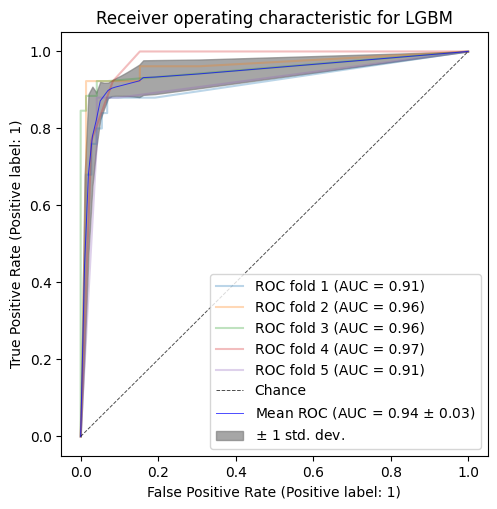

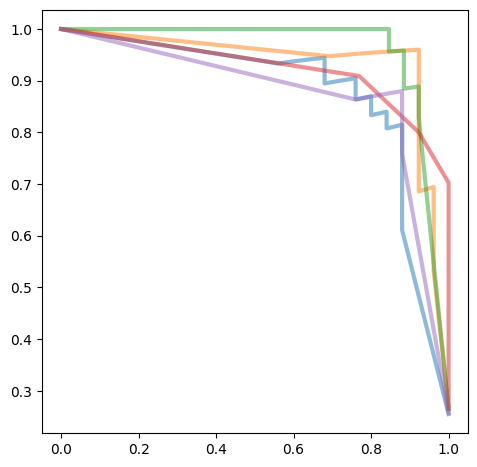

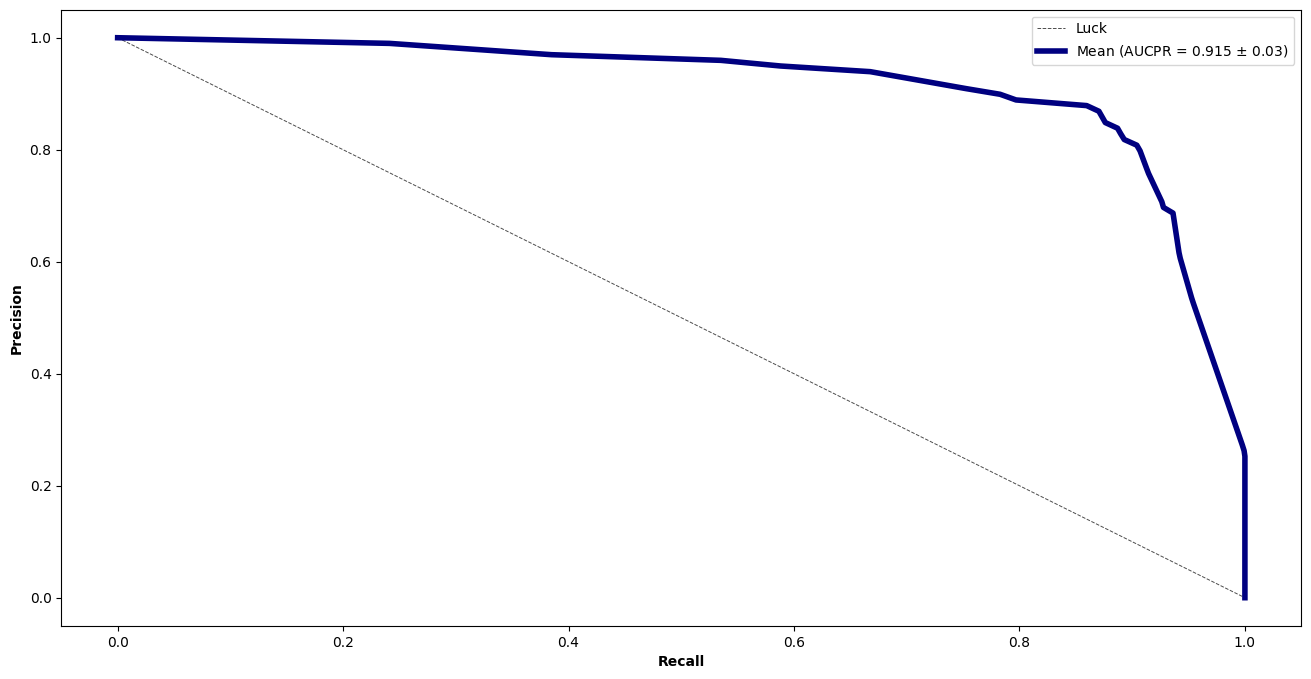

List of possible accuracy: 
 [0.816326530612245, 0.9056603773584906, 0.9166666666666666, 0.8571428571428571, 0.88]
Maximum Accuracy That can be obtained from this model is: 
 91.66666666666666 %
Minimum Accuracy: 
 81.6326530612245 %
Overall Accuracy: 
 87.51592863560519 %
Standard Deviation is: 
 0.04019482725170074
List of possible accuracy for trainning: [99.74424552429667, 100.0, 99.74424552429667, 95.39641943734016, 99.74489795918367]
List of possible accuracy for testing: [90.81632653061224, 94.89795918367348, 95.91836734693877, 91.83673469387756, 93.81443298969072]
Mean Accuracy: 0.9345676414895856, Mean Precision: 0.8804444444444444, Mean Recall: 0.8744615384615384, Mean f1_score: 0.88


In [98]:
from sklearn.neighbors import KNeighborsClassifier

clf1 = KNeighborsClassifier()

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

param_grid = {'n_neighbors': randint(3, 7),
              'weights': ['uniform', 'distance'],
              'p': [1, 2],
              'algorithm': ['brute'],
              'leaf_size': randint(10, 50)}

train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=param_grid, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1, random_state=seed)

for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy: \n', lst_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is: \n', max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy: \n', min(lst_accu_stratified)*100, '%')
print('Overall Accuracy: \n', mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is: \n', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [99]:
model5 = KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='brute', leaf_size=38, p=1).fit(X1_train, y1_train)

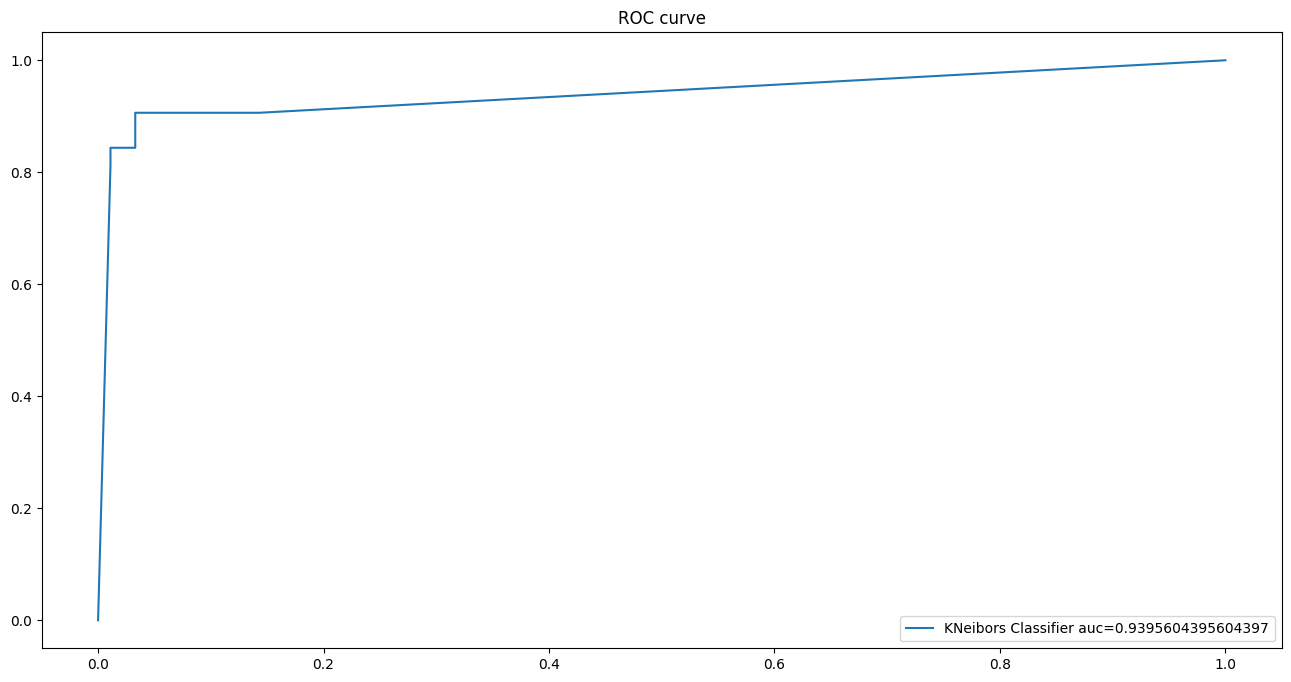

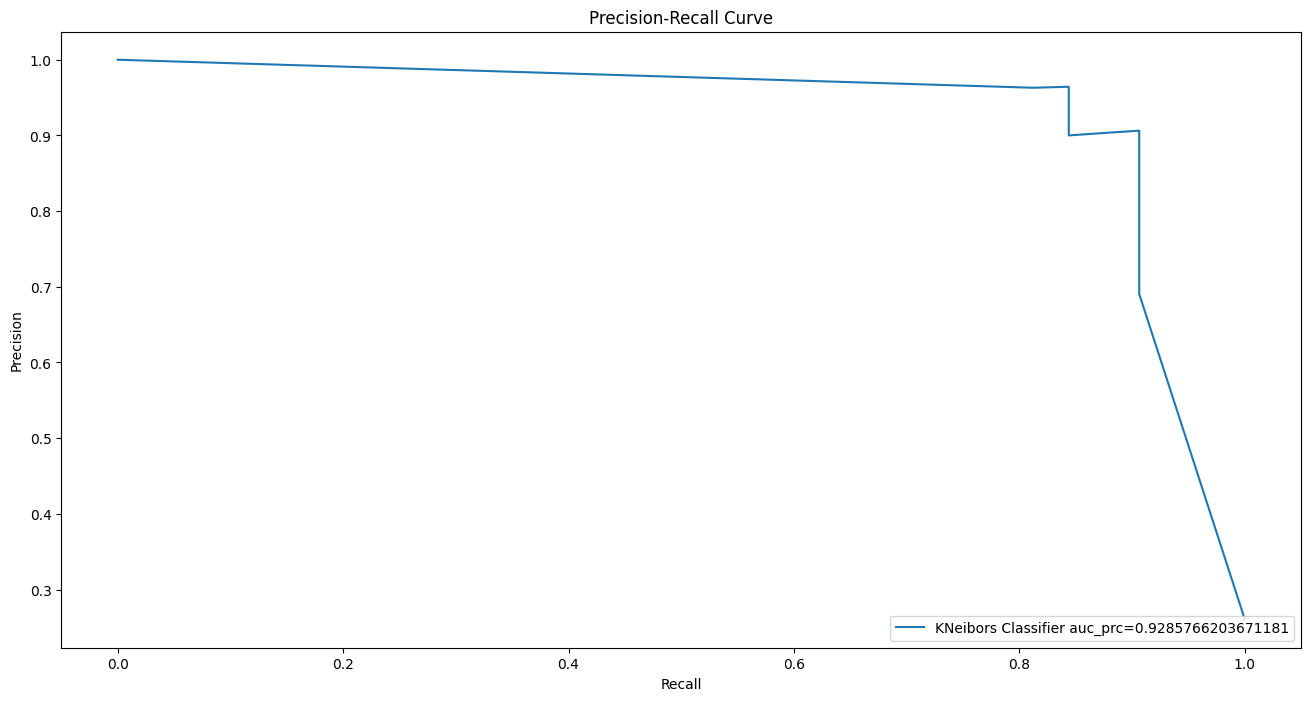

Train Result:
Accuracy Score: 99.80%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.997238    1.000000  0.997955    0.998619      0.997961
recall       1.000000    0.992188  0.997955    0.996094      0.997955
f1-score     0.998617    0.996078  0.997955    0.997348      0.997952
support    361.000000  128.000000  0.997955  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[361   0]
 [  1 127]]

Test Result:
Accuracy Score: 94.31%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.956522   0.903226  0.943089    0.929874      0.942656
recall      0.967033   0.875000  0.943089    0.921016      0.943089
f1-score    0.961749   0.888889  0.943089    0.925319      0.942793
support    91.000000  32.000000  0.943089  123.000000    123.000000
___

Model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
Logistic Regression,0.909091,0.939560,0.939148,0.956044,0.937500,0.977528,0.882353
SVM,0.878788,0.941964,0.931986,0.945055,0.906250,0.966292,0.852941
Gradient Boosting,0.906250,0.944712,0.946444,0.967033,0.906250,0.967033,0.906250
Random Forest,0.892308,0.950549,0.922128,0.956044,0.906250,0.966667,0.878788
KNeibors Classifier,0.888889,0.939560,0.928577,0.967033,0.875000,0.956522,0.903226


In [100]:
clf = print_auc(model5, X1_train, y1_train, X1_test, y1_test, 'KNeibors Classifier')
results_df4 = pd.DataFrame(data=[['KNeibors Classifier', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]], 
                          columns=['Model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
results_df = results_df.append(results_df4, ignore_index=True)

results_df.style.hide_index()

## **ExtraTrees**

Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8911013932580044
Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 9, 'n_estimators': 162}
Accuracy: 0.9081632653061225, Precision: 0.8636363636363636, Recall: 0.76, f1_score: 0.8085106382978724
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8618484792682481
Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': 58, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 615}
Accuracy: 0.9183673469387755, Precision: 0.78125, Recall: 0.9615384615384616, f1_score: 0.8620689655172413
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score:

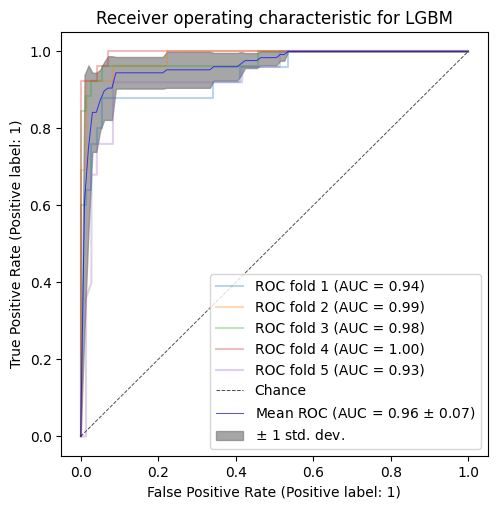

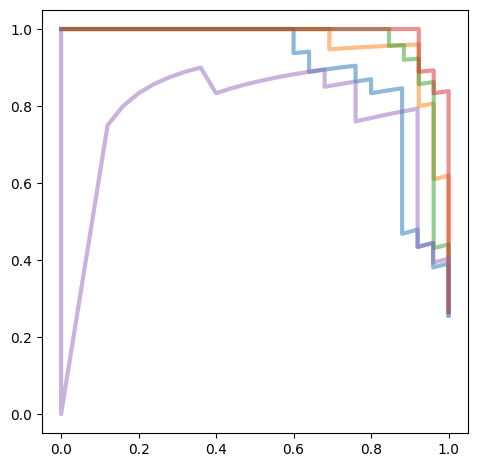

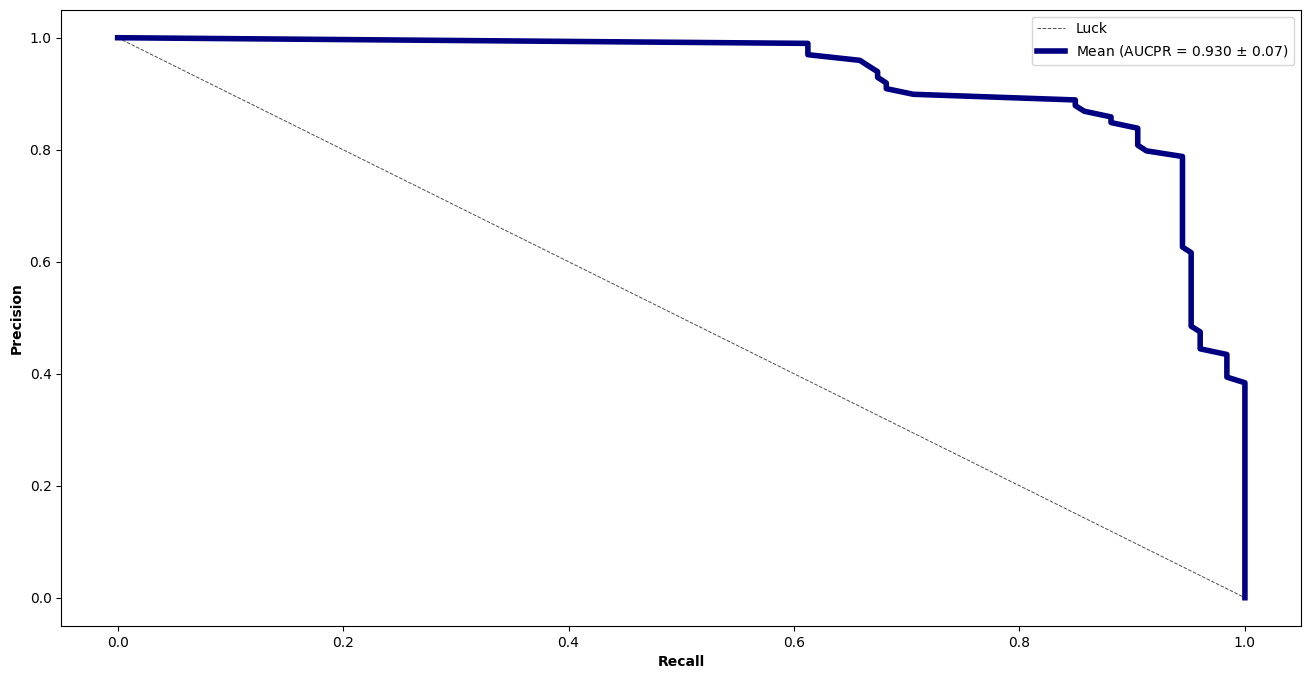

List of possible accuracy: 
 [0.8085106382978724, 0.8620689655172413, 0.8979591836734695, 0.9259259259259259, 0.8085106382978724]
Maximum Accuracy That can be obtained from this model is: 
 92.5925925925926 %
Minimum Accuracy: 
 80.85106382978724 %
Overall Accuracy: 
 86.05950703424763 %
Standard Deviation is: 
 0.052659154346801317
List of possible accuracy for trainning: [97.9539641943734, 99.23273657289002, 96.41943734015345, 97.69820971867009, 97.70408163265306]
List of possible accuracy for testing: [90.81632653061224, 91.83673469387756, 94.89795918367348, 95.91836734693877, 90.72164948453609]
Mean Accuracy: 0.9283820744792763, Mean Precision: 0.871580321852061, Mean Recall: 0.8578461538461539, Mean f1_score: 0.8085106382978724


In [101]:
from sklearn.ensemble import ExtraTreesClassifier

clf1 = ExtraTreesClassifier(random_state=seed)

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

param_grid = {'n_estimators': randint(100, 1000),
              'max_depth': randint(10, 100),
              'max_features': ['sqrt', 'log2'],
              'min_samples_split' : randint(2, 10), 
              'min_samples_leaf' : randint(1, 10),
              'class_weight' : ['balanced', None, class_weights]}

train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=param_grid, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1, random_state=seed)
for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy: \n', lst_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is: \n', max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy: \n', min(lst_accu_stratified)*100, '%')
print('Overall Accuracy: \n', mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is: \n', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [102]:
model6 = ExtraTreesClassifier(n_estimators=244, max_depth=68, class_weight={0: 0.6772853185595568, 1: 1.91015625}, 
                              max_features='log2', min_samples_leaf=2, min_samples_split=7, random_state=seed).fit(X1_train, y1_train)

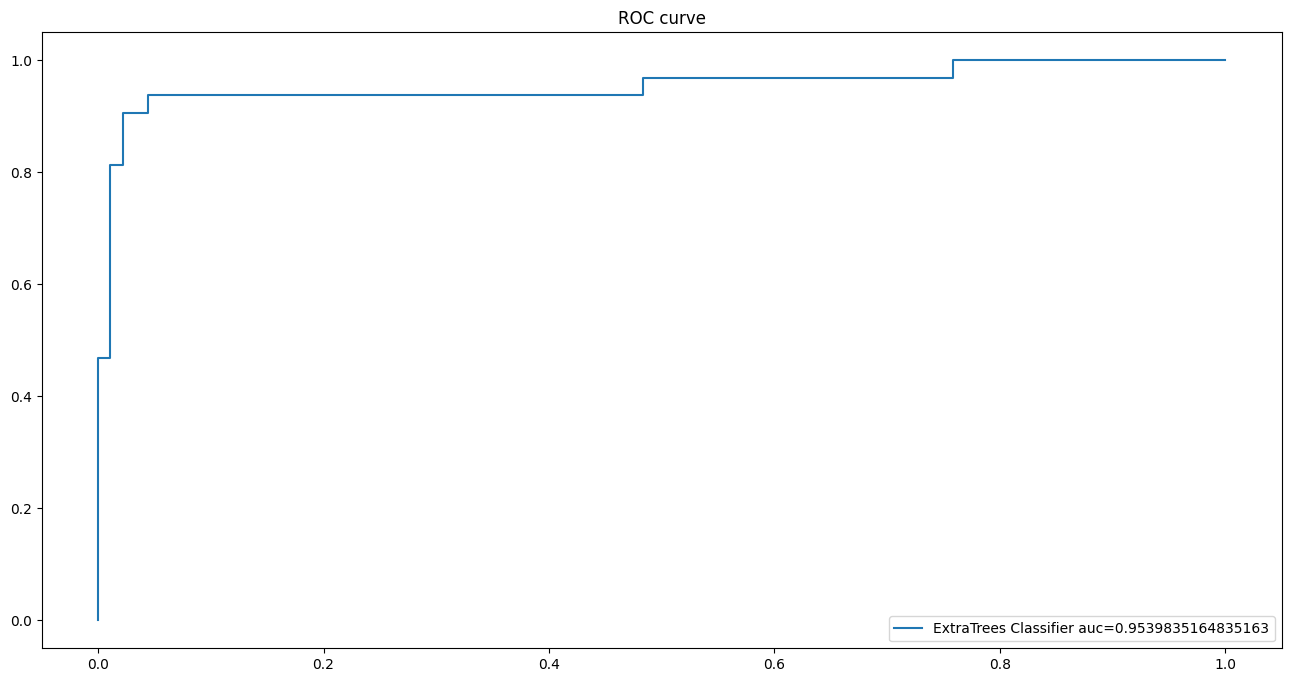

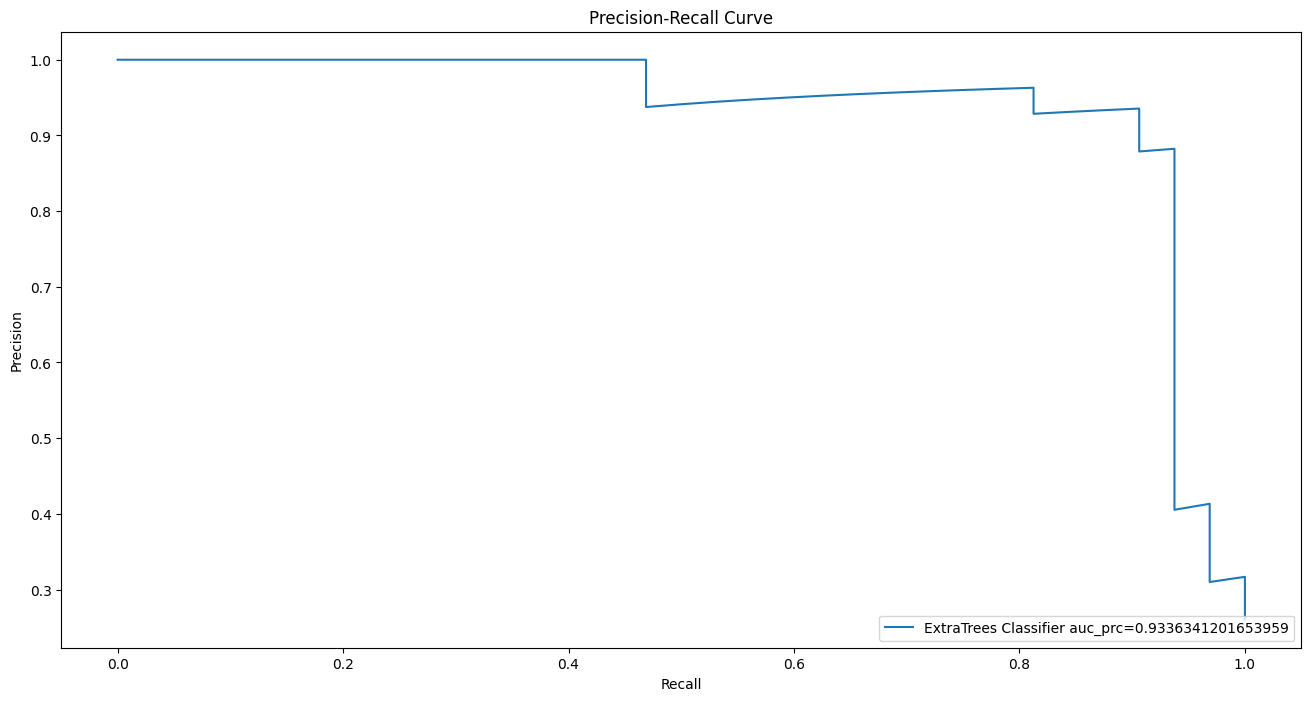

Train Result:
Accuracy Score: 98.16%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.991620    0.954198  0.981595    0.972909      0.981825
recall       0.983380    0.976562  0.981595    0.979971      0.981595
f1-score     0.987483    0.965251  0.981595    0.976367      0.981663
support    361.000000  128.000000  0.981595  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[355   6]
 [  3 125]]

Test Result:
Accuracy Score: 94.31%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.977273   0.857143  0.943089    0.917208      0.946019
recall      0.945055   0.937500  0.943089    0.941277      0.943089
f1-score    0.960894   0.895522  0.943089    0.928208      0.943887
support    91.000000  32.000000  0.943089  123.000000    123.000000
___

Model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
Logistic Regression,0.909091,0.939560,0.939148,0.956044,0.937500,0.977528,0.882353
SVM,0.878788,0.941964,0.931986,0.945055,0.906250,0.966292,0.852941
Gradient Boosting,0.906250,0.944712,0.946444,0.967033,0.906250,0.967033,0.906250
Random Forest,0.892308,0.950549,0.922128,0.956044,0.906250,0.966667,0.878788
KNeibors Classifier,0.888889,0.939560,0.928577,0.967033,0.875000,0.956522,0.903226
ExtraTrees Classifier,0.895522,0.953984,0.933634,0.945055,0.937500,0.977273,0.857143


In [103]:
clf = print_auc(model6, X1_train, y1_train, X1_test, y1_test, 'ExtraTrees Classifier')
results_df5 = pd.DataFrame(data=[['ExtraTrees Classifier', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]], 
                          columns=['Model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
results_df = results_df.append(results_df5, ignore_index=True)

results_df.style.hide_index()

## **AdaBoost**

Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8669217767136983
Best Hyperparameters: {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.8215141132005579, 'n_estimators': 131}
Accuracy: 0.8877551020408163, Precision: 0.8181818181818182, Recall: 0.72, f1_score: 0.7659574468085107
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8674224021592444
Best Hyperparameters: {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.8073944371810401, 'n_estimators': 84}
Accuracy: 0.9081632653061225, Precision: 0.7931034482758621, Recall: 0.8846153846153846, f1_score: 0.8363636363636363
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8895510045675732
Best Hyperparamete

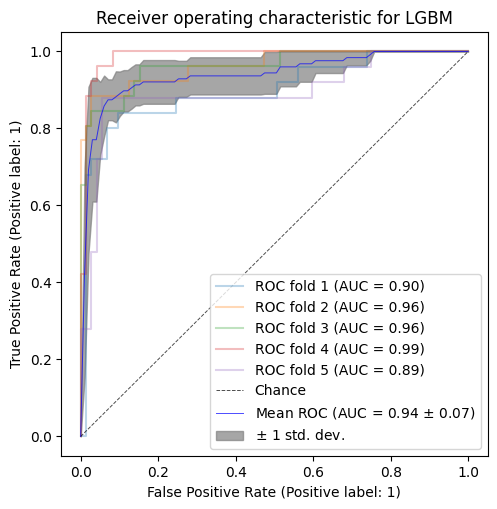

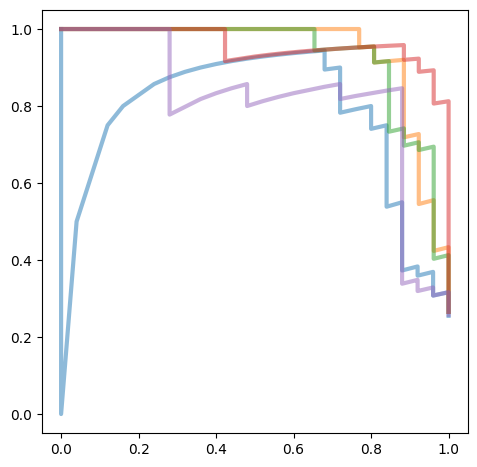

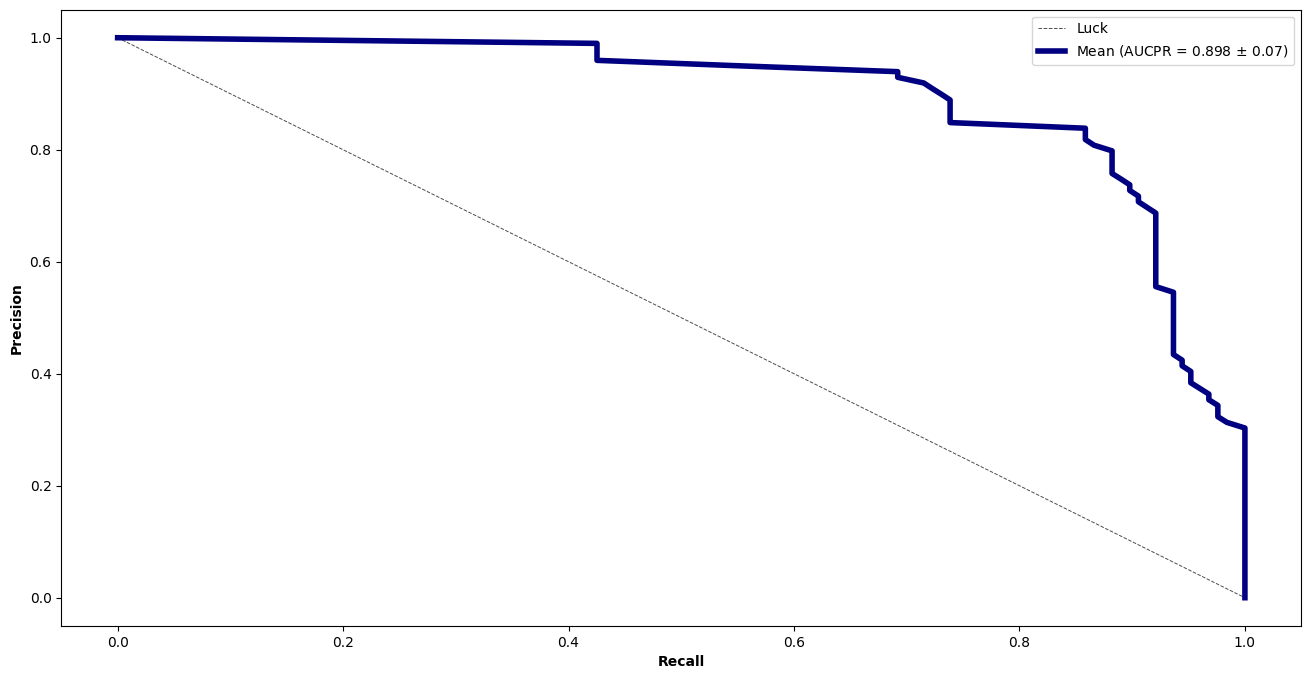

List of possible accuracy: 
 [0.7659574468085107, 0.8363636363636363, 0.7999999999999999, 0.9259259259259259, 0.7659574468085107]
Maximum Accuracy That can be obtained from this model is: 
 92.5925925925926 %
Minimum Accuracy: 
 76.59574468085107 %
Overall Accuracy: 
 81.88408911813167 %
Standard Deviation is: 
 0.0665630299470889
List of possible accuracy for trainning: [99.74424552429667, 100.0, 99.74424552429667, 100.0, 99.74489795918367]
List of possible accuracy for testing: [88.77551020408163, 90.81632653061224, 90.81632653061224, 95.91836734693877, 88.65979381443299]
Mean Accuracy: 0.9099726488533557, Mean Precision: 0.8539385297098546, Mean Recall: 0.7956923076923077, Mean f1_score: 0.7659574468085107


In [106]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

clf1 = AdaBoostClassifier(random_state=0)

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

param_grid = {'n_estimators': randint(50, 200),
              'learning_rate': uniform(1e-5, 1),
              'base_estimator': [DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=7), DecisionTreeClassifier(max_depth=9), None]}

train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=param_grid, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1, random_state=seed)
for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy: \n', lst_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is: \n', max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy: \n', min(lst_accu_stratified)*100, '%')
print('Overall Accuracy: \n', mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is: \n', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [108]:
model7 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=7), n_estimators=135, learning_rate=0.992623626012664, random_state=seed).fit(X1_train, y1_train)

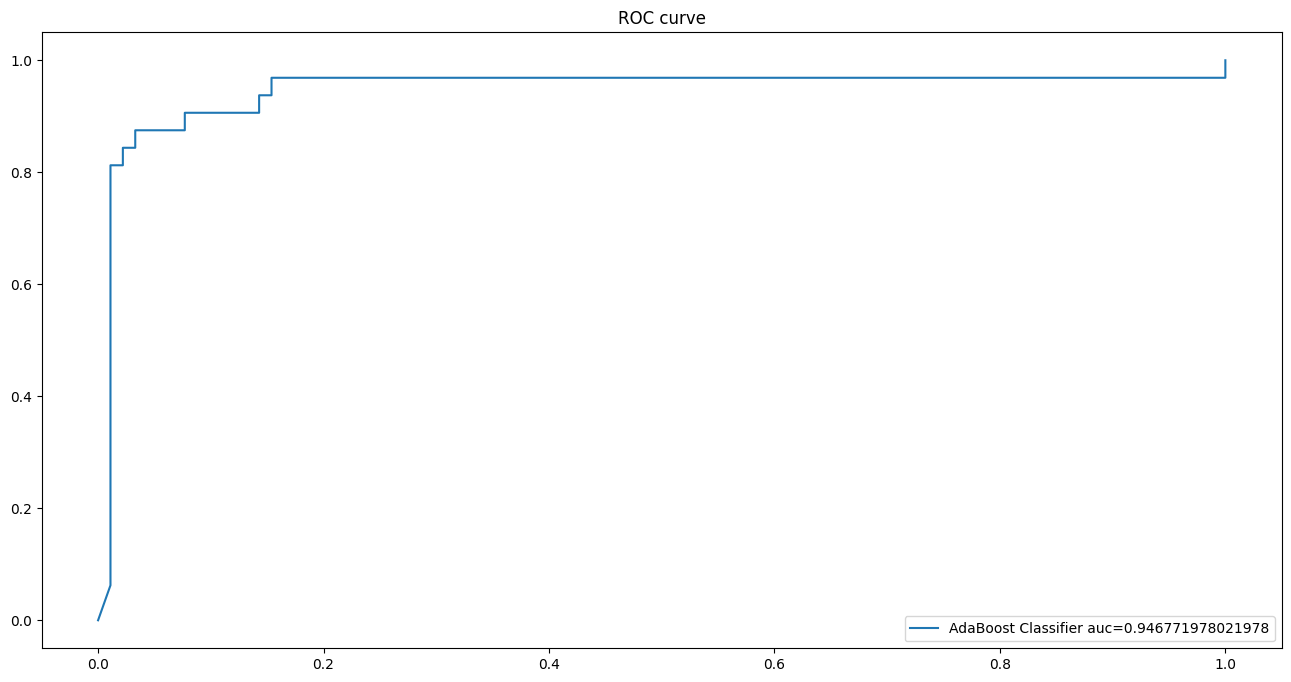

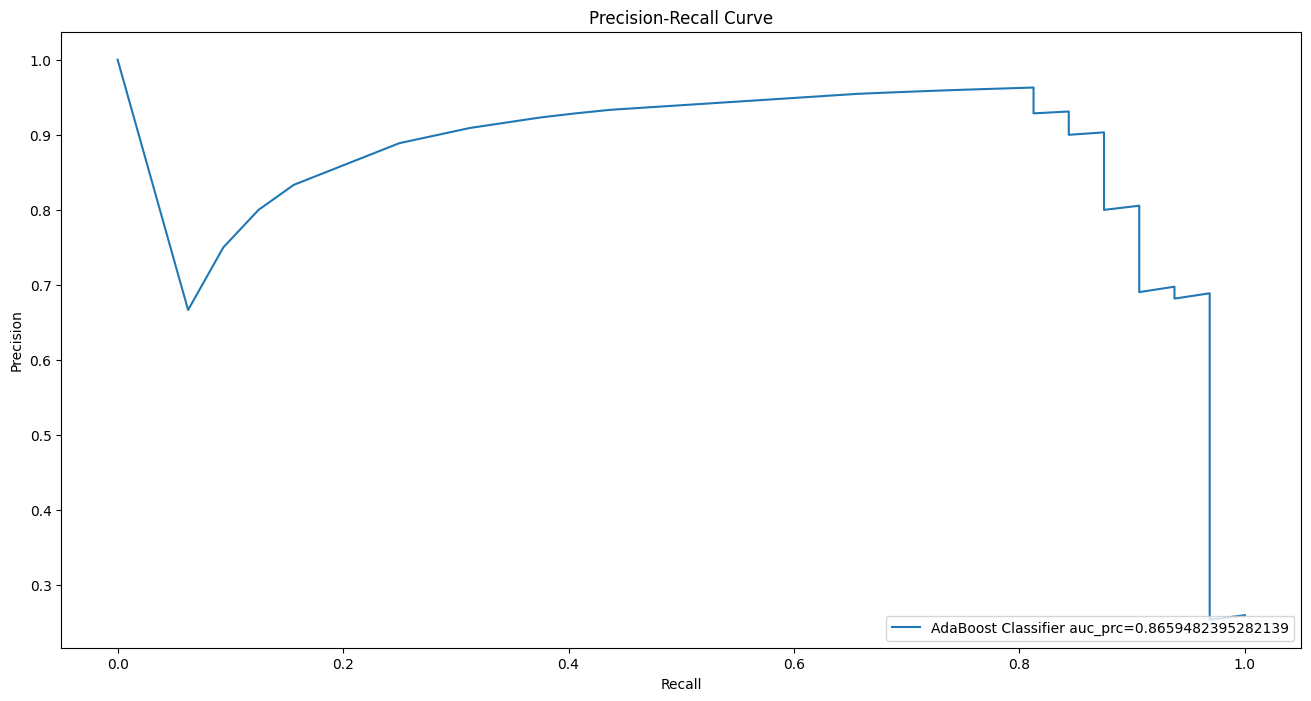

Train Result:
Accuracy Score: 99.80%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    1.000000    0.992248  0.997955    0.996124      0.997971
recall       0.997230    1.000000  0.997955    0.998615      0.997955
f1-score     0.998613    0.996109  0.997955    0.997361      0.997958
support    361.000000  128.000000  0.997955  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[360   1]
 [  0 128]]

Test Result:
Accuracy Score: 91.87%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.955056   0.823529  0.918699    0.889293      0.920838
recall      0.934066   0.875000  0.918699    0.904533      0.918699
f1-score    0.944444   0.848485  0.918699    0.896465      0.919479
support    91.000000  32.000000  0.918699  123.000000    123.000000
___

Model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
Logistic Regression,0.909091,0.939560,0.939148,0.956044,0.937500,0.977528,0.882353
SVM,0.878788,0.941964,0.931986,0.945055,0.906250,0.966292,0.852941
Gradient Boosting,0.906250,0.944712,0.946444,0.967033,0.906250,0.967033,0.906250
Random Forest,0.892308,0.950549,0.922128,0.956044,0.906250,0.966667,0.878788
KNeibors Classifier,0.888889,0.939560,0.928577,0.967033,0.875000,0.956522,0.903226
ExtraTrees Classifier,0.895522,0.953984,0.933634,0.945055,0.937500,0.977273,0.857143
AdaBoost Classifier,0.848485,0.946772,0.865948,0.934066,0.875000,0.955056,0.823529


In [109]:
clf = print_auc(model7, X1_train, y1_train, X1_test, y1_test, 'AdaBoost Classifier')
results_df6 = pd.DataFrame(data=[['AdaBoost Classifier', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]], 
                          columns=['Model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
results_df = results_df.append(results_df6, ignore_index=True)

results_df.style.hide_index()

## **Decision Tree**

Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8031242725979568
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 22, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 15}
Accuracy: 0.8469387755102041, Precision: 0.8571428571428571, Recall: 0.48, f1_score: 0.6153846153846153
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8051170627641214
Best Hyperparameters: {'criterion': 'log_loss', 'max_depth': 11, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4}
Accuracy: 0.8673469387755102, Precision: 0.76, Recall: 0.7307692307692307, f1_score: 0.7450980392156863
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8412619406737054
Best Hyperparameters: {'criterion'

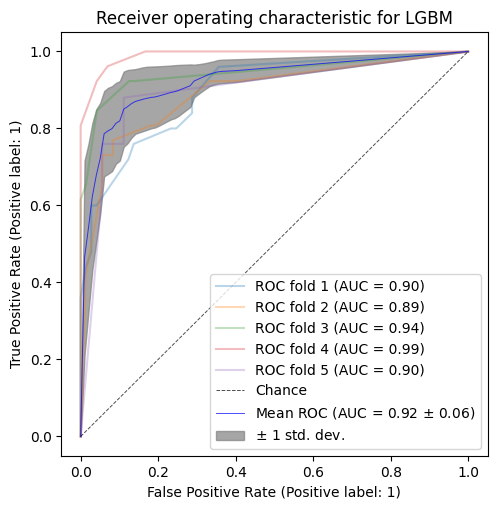

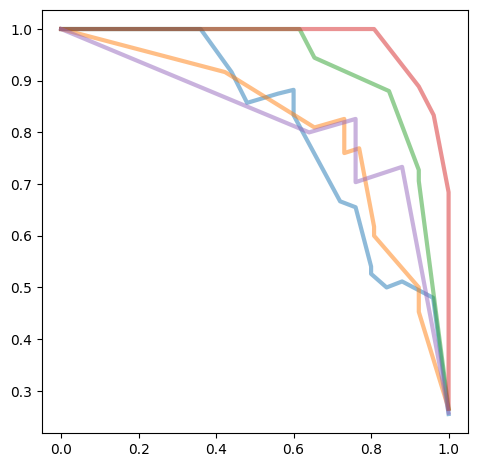

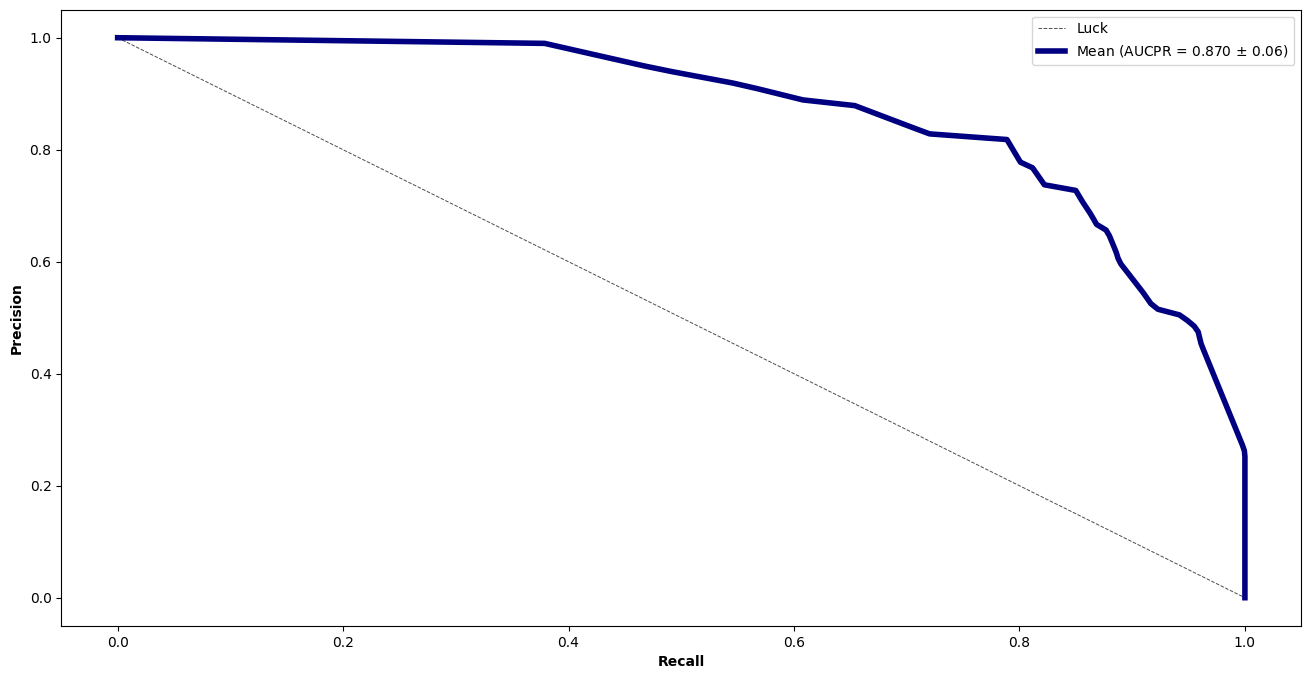

List of possible accuracy: 
 [0.6153846153846153, 0.7450980392156863, 0.7727272727272727, 0.8928571428571429, 0.7755102040816326]
Maximum Accuracy That can be obtained from this model is: 
 89.28571428571429 %
Minimum Accuracy: 
 61.53846153846153 %
Overall Accuracy: 
 76.031545485327 %
Standard Deviation is: 
 0.09898074390221333
List of possible accuracy for trainning: [90.28132992327366, 93.35038363171356, 94.11764705882352, 92.32736572890026, 95.91836734693877]
List of possible accuracy for testing: [84.6938775510204, 86.73469387755102, 89.79591836734694, 93.87755102040816, 88.65979381443299]
Mean Accuracy: 0.8875236692615192, Mean Precision: 0.8373174603174602, Mean Recall: 0.7172307692307692, Mean f1_score: 0.7755102040816326


In [112]:
from sklearn.tree import DecisionTreeClassifier

clf1 = DecisionTreeClassifier(random_state=0)

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

param_grid = {'min_samples_split': randint(2, 20),
              'max_depth': randint(3, 25),
              'min_samples_leaf': randint(2, 15),
              'criterion' : ['gini', 'entropy', 'log_loss'],
              'max_features': ['auto', 'sqrt', 'log2']}

train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=param_grid, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1, random_state=seed)
for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy: \n', lst_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is: \n', max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy: \n', min(lst_accu_stratified)*100, '%')
print('Overall Accuracy: \n', mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is: \n', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [113]:
model8 = DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=4, max_depth=11, criterion='log_loss', max_features='log2', random_state=seed).fit(X1_train, y1_train)

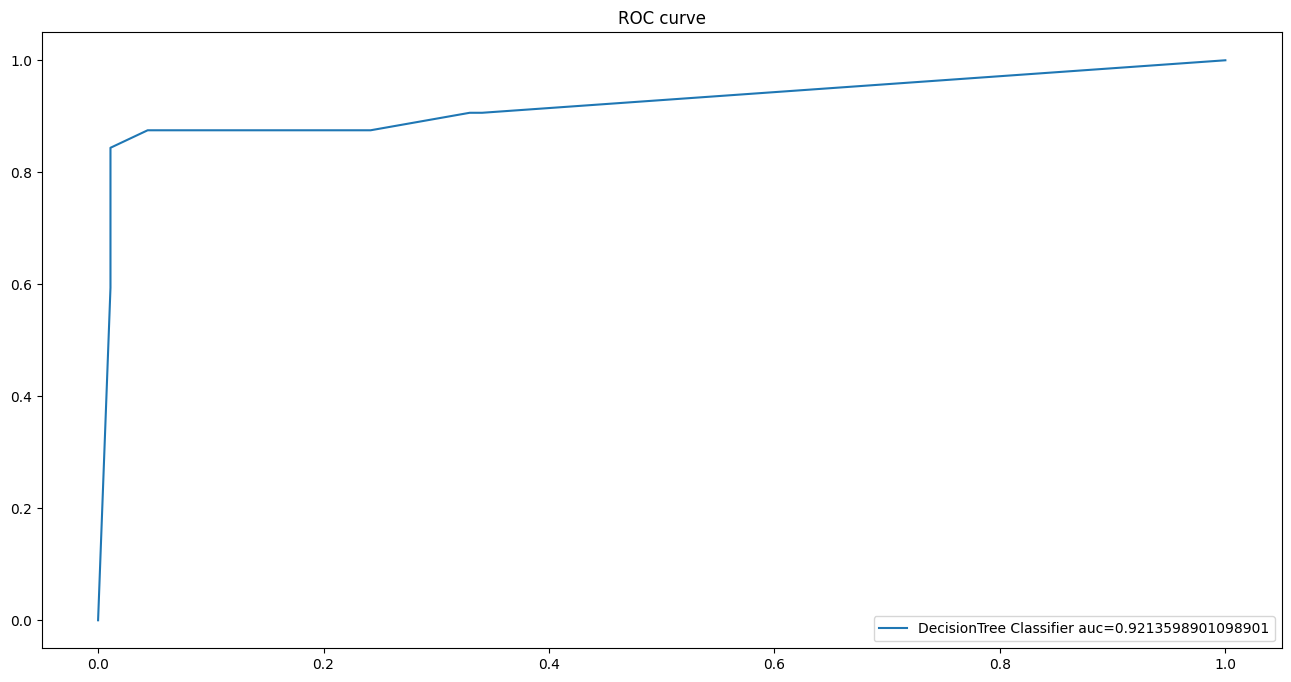

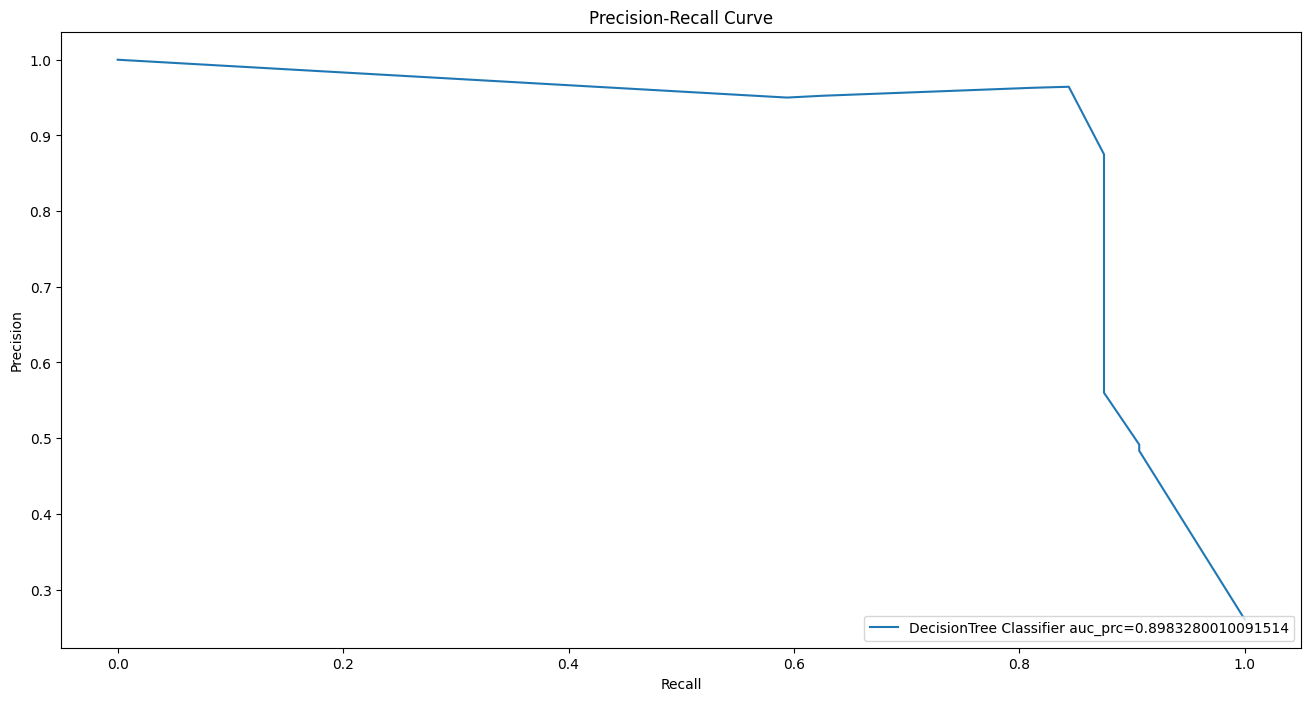

Train Result:
Accuracy Score: 93.87%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.943700    0.922414   0.93865    0.933057      0.938128
recall       0.975069    0.835938   0.93865    0.905503      0.938650
f1-score     0.959128    0.877049   0.93865    0.918089      0.937643
support    361.000000  128.000000   0.93865  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[352   9]
 [ 21 107]]

Test Result:
Accuracy Score: 93.50%
_______________________________________________
CLASSIFICATION REPORT:
                   0       1  accuracy   macro avg  weighted avg
precision   0.956044   0.875  0.934959    0.915522      0.934959
recall      0.956044   0.875  0.934959    0.915522      0.934959
f1-score    0.956044   0.875  0.934959    0.915522      0.934959
support    91.000000  32.000  0.934959  123.000000    123.000000
__________________

Model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
Logistic Regression,0.909091,0.939560,0.939148,0.956044,0.937500,0.977528,0.882353
SVM,0.878788,0.941964,0.931986,0.945055,0.906250,0.966292,0.852941
Gradient Boosting,0.906250,0.944712,0.946444,0.967033,0.906250,0.967033,0.906250
Random Forest,0.892308,0.950549,0.922128,0.956044,0.906250,0.966667,0.878788
KNeibors Classifier,0.888889,0.939560,0.928577,0.967033,0.875000,0.956522,0.903226
ExtraTrees Classifier,0.895522,0.953984,0.933634,0.945055,0.937500,0.977273,0.857143
AdaBoost Classifier,0.848485,0.946772,0.865948,0.934066,0.875000,0.955056,0.823529
DecisionTree Classifier,0.875000,0.921360,0.898328,0.956044,0.875000,0.956044,0.875000


In [115]:
clf = print_auc(model8, X1_train, y1_train, X1_test, y1_test, 'DecisionTree Classifier')
results_df7 = pd.DataFrame(data=[['DecisionTree Classifier', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]], 
                          columns=['Model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
results_df = results_df.append(results_df7, ignore_index=True)

results_df.style.hide_index()

## **GaussianNB**


Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.5798005547611922
Best Hyperparameters: {'var_smoothing': 1.7129206695016828e-08}
Accuracy: 0.6020408163265306, Precision: 0.375, Recall: 0.84, f1_score: 0.5185185185185186
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.5685336796478213
Best Hyperparameters: {'var_smoothing': 6.974691855978616e-07}
Accuracy: 0.6530612244897959, Precision: 0.42857142857142855, Recall: 0.9230769230769231, f1_score: 0.5853658536585366
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.6258029689608636
Best Hyperparameters: {'var_smoothing': 6.974691855978616e-07}
Accuracy: 0.7551020408163265, Precision: 0.5238095238095238, Recall: 0.8461538461538461, f1_score: 0.6470588235

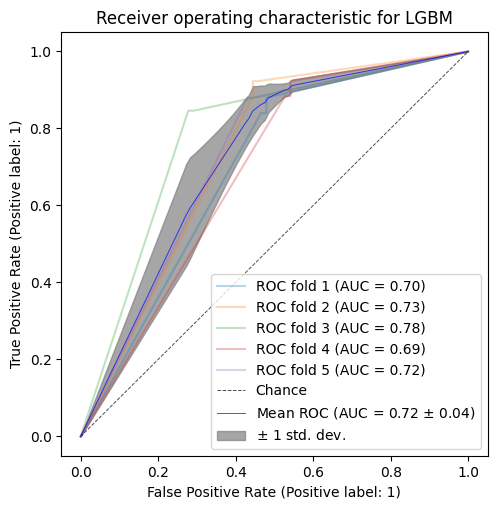

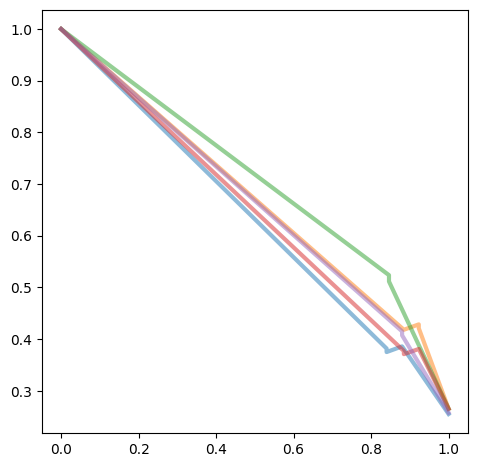

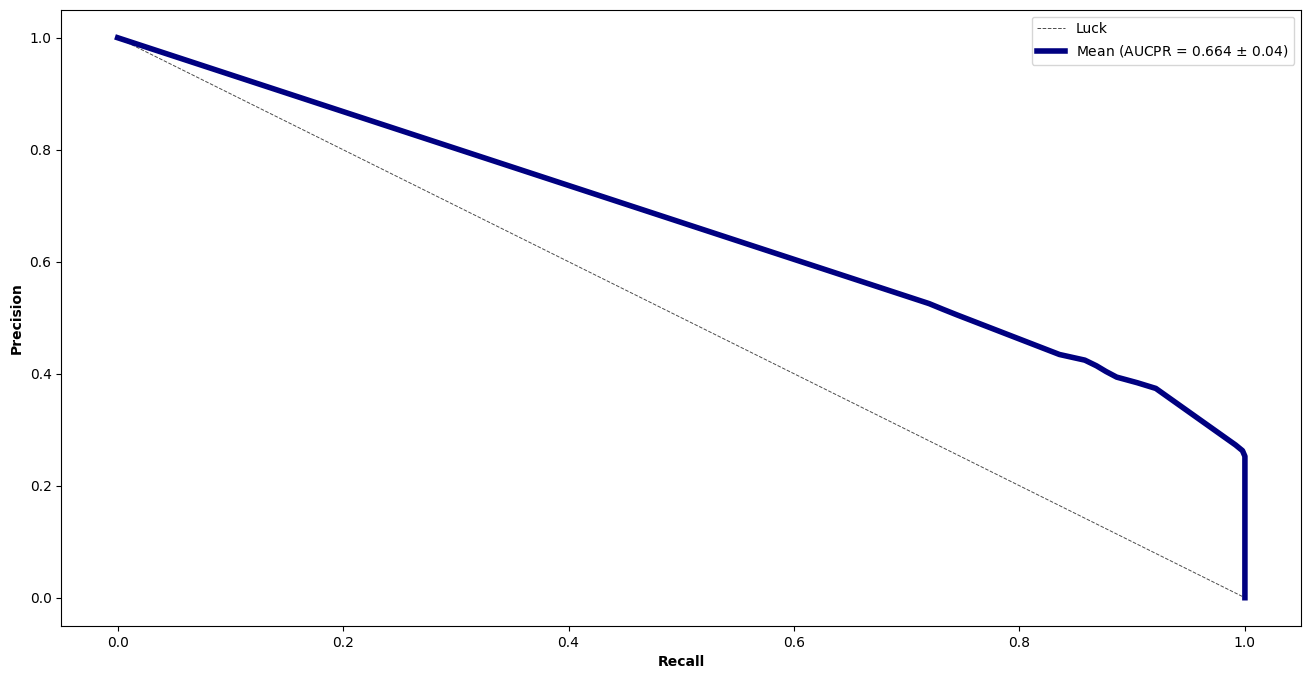

List of possible accuracy: 
 [0.5185185185185186, 0.5853658536585366, 0.6470588235294118, 0.5393258426966292, 0.5569620253164557]
Maximum Accuracy That can be obtained from this model is: 
 64.70588235294117 %
Minimum Accuracy: 
 51.85185185185186 %
Overall Accuracy: 
 56.94462127439104 %
Standard Deviation is: 
 0.04983441076810367
List of possible accuracy for trainning: [63.9386189258312, 64.19437340153452, 68.54219948849105, 65.72890025575447, 71.42857142857143]
List of possible accuracy for testing: [60.204081632653065, 65.3061224489796, 75.51020408163265, 58.16326530612245, 63.91752577319587]
Mean Accuracy: 0.6462023984851673, Mean Precision: 0.42314814814814816, Mean Recall: 0.8824615384615384, Mean f1_score: 0.5569620253164557


In [116]:
from sklearn.naive_bayes import GaussianNB

clf1 = GaussianNB()

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

param_grid = {'var_smoothing': uniform(1e-9, 1e-6)}

train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=param_grid, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1, random_state=seed)
for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy: \n', lst_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is: \n', max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy: \n', min(lst_accu_stratified)*100, '%')
print('Overall Accuracy: \n', mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is: \n', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [117]:
model9 = GaussianNB(var_smoothing=6.974691855978616e-07).fit(X1_train, y1_train)

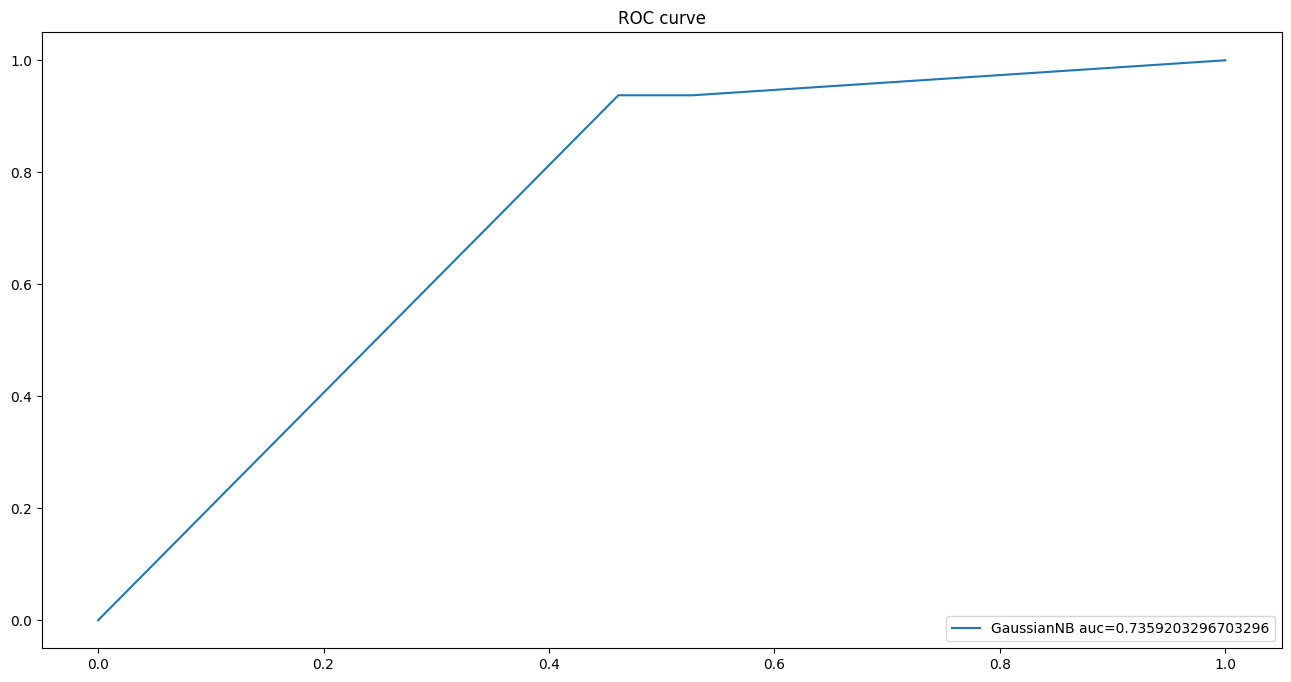

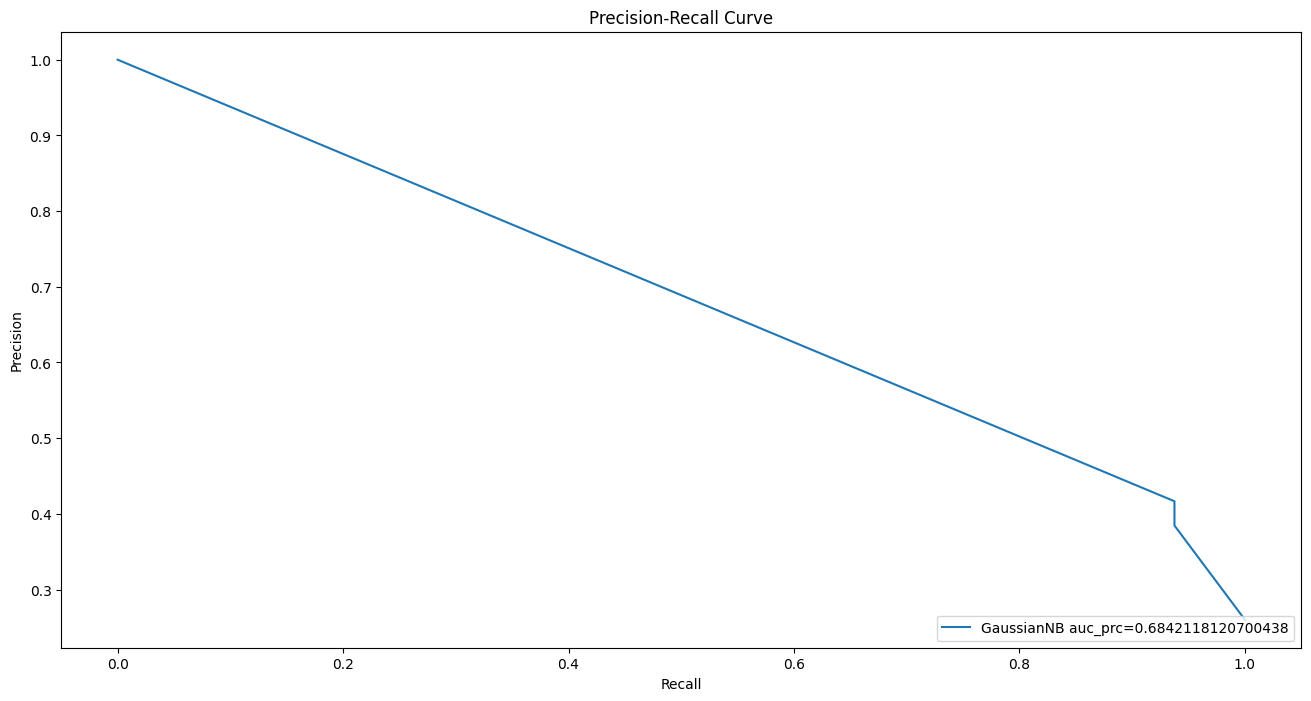

Train Result:
Accuracy Score: 63.39%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.989247    0.415842  0.633947    0.702544      0.839153
recall       0.509695    0.984375  0.633947    0.747035      0.633947
f1-score     0.672761    0.584687  0.633947    0.628724      0.649706
support    361.000000  128.000000  0.633947  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[184 177]
 [  2 126]]

Test Result:
Accuracy Score: 61.79%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.958333   0.400000  0.617886    0.679167      0.813076
recall      0.505495   0.937500  0.617886    0.721497      0.617886
f1-score    0.661871   0.560748  0.617886    0.611309      0.635562
support    91.000000  32.000000  0.617886  123.000000    123.000000
___

Model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
Logistic Regression,0.909091,0.939560,0.939148,0.956044,0.937500,0.977528,0.882353
SVM,0.878788,0.941964,0.931986,0.945055,0.906250,0.966292,0.852941
Gradient Boosting,0.906250,0.944712,0.946444,0.967033,0.906250,0.967033,0.906250
Random Forest,0.892308,0.950549,0.922128,0.956044,0.906250,0.966667,0.878788
KNeibors Classifier,0.888889,0.939560,0.928577,0.967033,0.875000,0.956522,0.903226
ExtraTrees Classifier,0.895522,0.953984,0.933634,0.945055,0.937500,0.977273,0.857143
AdaBoost Classifier,0.848485,0.946772,0.865948,0.934066,0.875000,0.955056,0.823529
DecisionTree Classifier,0.875000,0.921360,0.898328,0.956044,0.875000,0.956044,0.875000
GaussianNB,0.560748,0.735920,0.684212,0.505495,0.937500,0.958333,0.400000


In [118]:
clf = print_auc(model9, X1_train, y1_train, X1_test, y1_test, 'GaussianNB')
results_df8 = pd.DataFrame(data=[['GaussianNB', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]], 
                          columns=['Model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
results_df = results_df.append(results_df8, ignore_index=True)

results_df.style.hide_index()

## **LGBM**

Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8869845979318469
Best Hyperparameters: {'class_weight': {0: 0.6772853185595568, 1: 1.91015625}, 'colsample_bytree': 0.832197934937924, 'learning_rate': 0.7447906551417659, 'max_depth': 4, 'min_child_samples': 23, 'n_estimators': 72, 'num_leaves': 20, 'subsample': 0.8581251357001429}
Accuracy: 0.9285714285714286, Precision: 0.875, Recall: 0.84, f1_score: 0.8571428571428572
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8584744469870328
Best Hyperparameters: {'class_weight': {0: 0.6772853185595568, 1: 1.91015625}, 'colsample_bytree': 0.832197934937924, 'learning_rate': 0.7447906551417659, 'max_depth': 4, 'min_child_samples': 23, 'n_estimators': 72, 'num_leaves': 20, 'subsample': 0.8581251357001429}
Accuracy: 0.9591836734693877, Precision: 0.892857

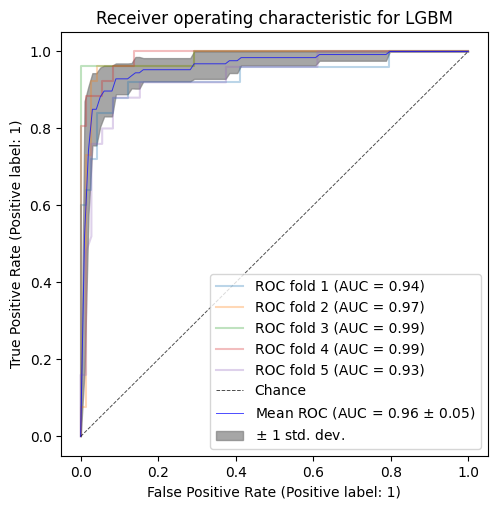

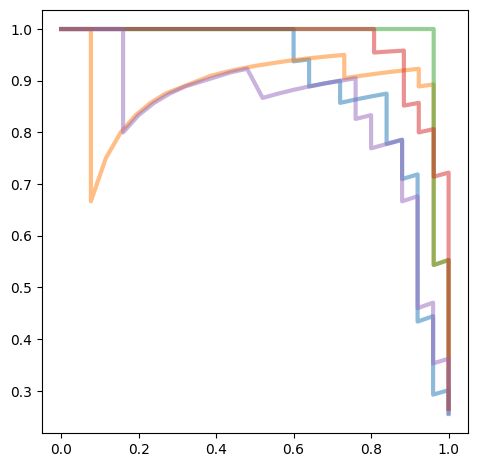

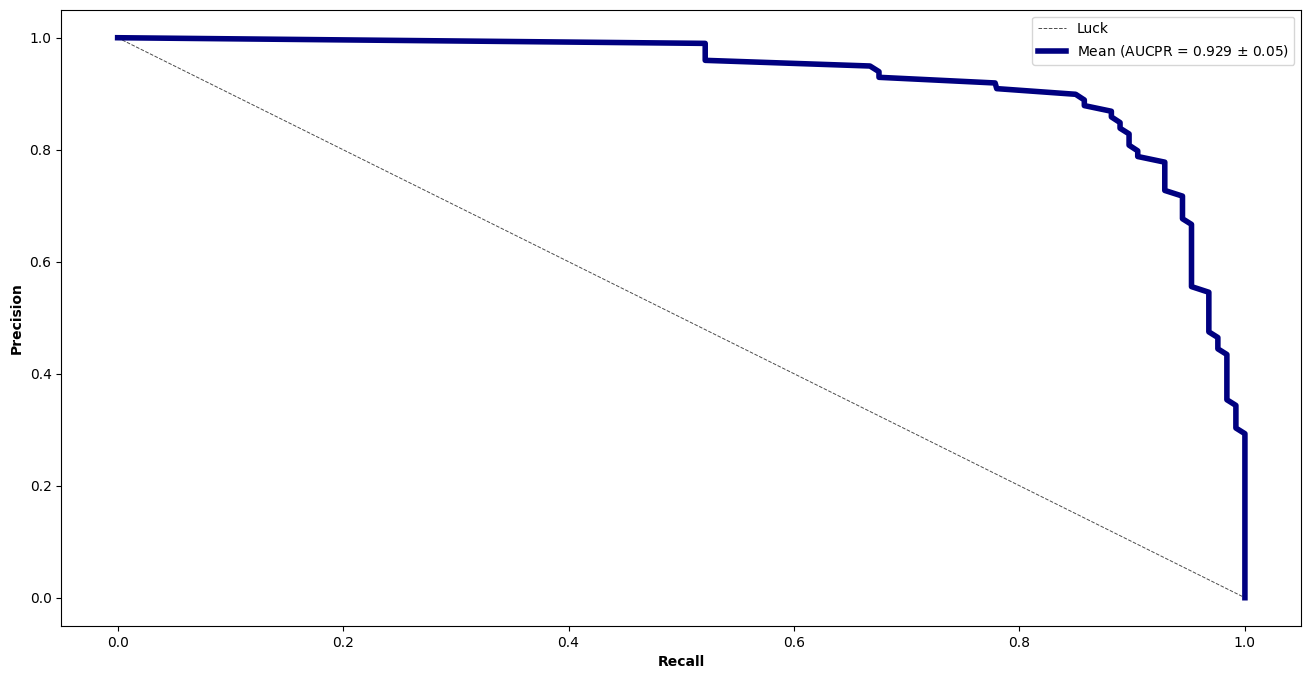

List of possible accuracy: 
 [0.8571428571428572, 0.9259259259259259, 0.9600000000000001, 0.8771929824561403, 0.816326530612245]
Maximum Accuracy That can be obtained from this model is: 
 96.00000000000001 %
Minimum Accuracy: 
 81.6326530612245 %
Overall Accuracy: 
 88.73176592274336 %
Standard Deviation is: 
 0.056626162284464765
List of possible accuracy for trainning: [99.23273657289002, 99.48849104859335, 99.48849104859335, 99.48849104859335, 99.74489795918367]
List of possible accuracy for testing: [92.85714285714286, 95.91836734693877, 97.95918367346938, 92.85714285714286, 90.72164948453609]
Mean Accuracy: 0.94062697243846, Mean Precision: 0.8815284178187403, Mean Recall: 0.8972307692307693, Mean f1_score: 0.816326530612245


In [119]:
import lightgbm as lgb

clf1 = lgb.LGBMClassifier()

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

param_grid = {'num_leaves': randint(10, 30),
              'max_depth': randint(3, 10),
              'learning_rate': uniform(1e-5, 1),
              'n_estimators': randint(50, 200),
              'min_child_samples': randint(10, 30),
              'subsample': uniform(0.8, 1),
              'colsample_bytree': uniform(0.8, 1),
              'class_weight' : ['balanced', None, class_weights]}

train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=param_grid, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1, random_state=seed)
for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy: \n', lst_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is: \n', max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy: \n', min(lst_accu_stratified)*100, '%')
print('Overall Accuracy: \n', mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is: \n', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [128]:
model10 = lgb.LGBMClassifier(class_weight={0: 0.6772853185595568, 1: 1.91015625}, colsample_bytree=0.9753726607799157, learning_rate=0.31497644589068613, max_depth=6, min_child_samples=14,
                             n_estimators=190, num_leaves=18, subsample=0.8957125166123872, random_state=seed).fit(X1_train, y1_train)

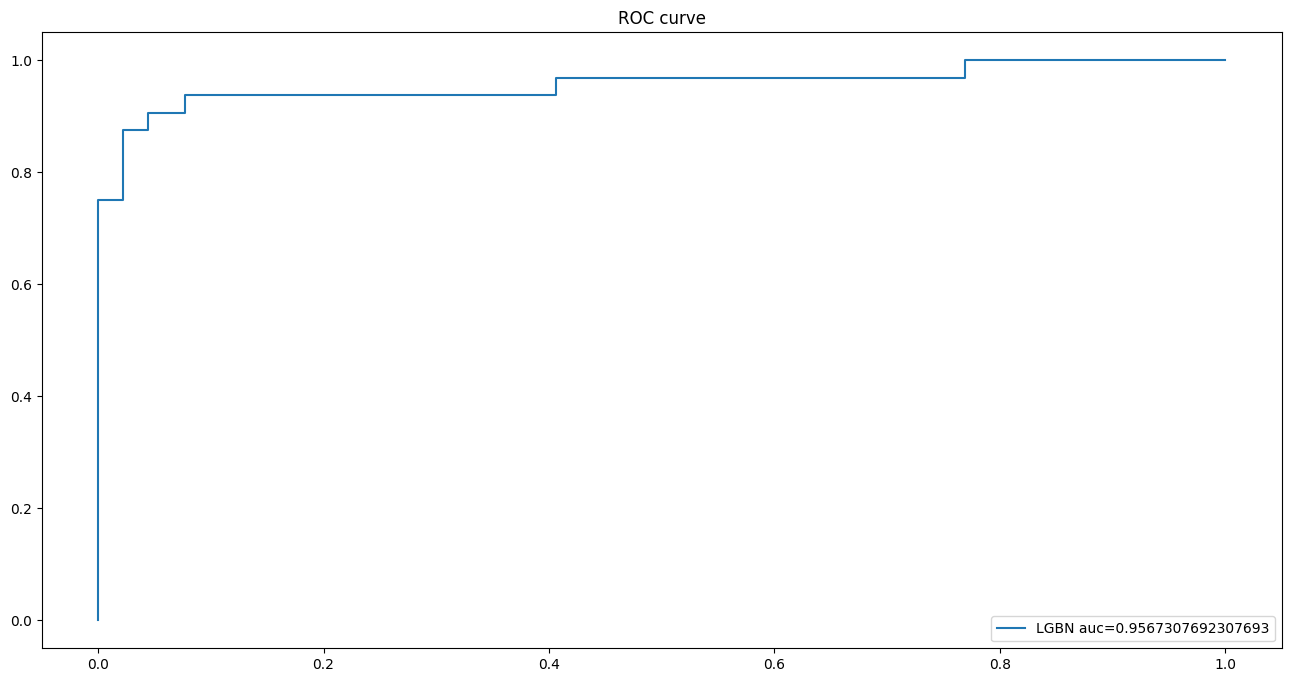

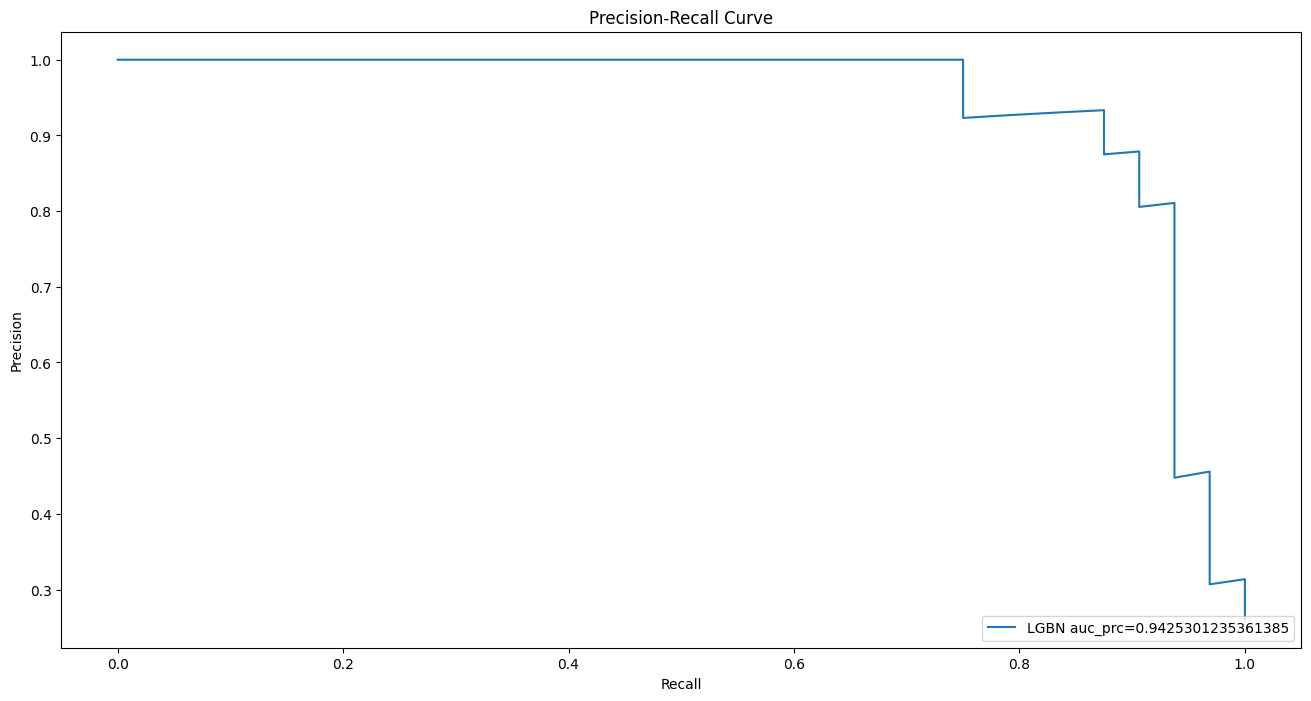

Train Result:
Accuracy Score: 99.39%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    1.000000    0.977099  0.993865    0.988550      0.994006
recall       0.991690    1.000000  0.993865    0.995845      0.993865
f1-score     0.995828    0.988417  0.993865    0.992122      0.993888
support    361.000000  128.000000  0.993865  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[358   3]
 [  0 128]]

Test Result:
Accuracy Score: 92.68%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.976744   0.810811  0.926829    0.893777      0.933575
recall      0.923077   0.937500  0.926829    0.930288      0.926829
f1-score    0.949153   0.869565  0.926829    0.909359      0.928447
support    91.000000  32.000000  0.926829  123.000000    123.000000
___

Model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
Logistic Regression,0.909091,0.939560,0.939148,0.956044,0.937500,0.977528,0.882353
SVM,0.878788,0.941964,0.931986,0.945055,0.906250,0.966292,0.852941
Gradient Boosting,0.906250,0.944712,0.946444,0.967033,0.906250,0.967033,0.906250
Random Forest,0.892308,0.950549,0.922128,0.956044,0.906250,0.966667,0.878788
KNeibors Classifier,0.888889,0.939560,0.928577,0.967033,0.875000,0.956522,0.903226
ExtraTrees Classifier,0.895522,0.953984,0.933634,0.945055,0.937500,0.977273,0.857143
AdaBoost Classifier,0.848485,0.946772,0.865948,0.934066,0.875000,0.955056,0.823529
DecisionTree Classifier,0.875000,0.921360,0.898328,0.956044,0.875000,0.956044,0.875000
GaussianNB,0.560748,0.735920,0.684212,0.505495,0.937500,0.958333,0.400000
LGBM,0.869565,0.956731,0.942530,0.923077,0.937500,0.976744,0.810811


In [129]:
clf = print_auc(model10, X1_train, y1_train, X1_test, y1_test, 'LGBN')
results_df9 = pd.DataFrame(data=[['LGBM', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]], 
                          columns=['Model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
results_df = results_df.append(results_df9, ignore_index=True)

results_df.style.hide_index()

## **XGB**

Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8922761100141164
Best Hyperparameters: {'colsample_bytree': 0.9116584942412664, 'gamma': 0.12945699300643146, 'learning_rate': 0.053977557892411036, 'max_depth': 11, 'scale_pos_weight': 2.825, 'subsample': 0.8467947202135594}
Accuracy: 0.9285714285714286, Precision: 0.9090909090909091, Recall: 0.8, f1_score: 0.8510638297872342
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8699826141931405
Best Hyperparameters: {'colsample_bytree': 0.6824998320681915, 'gamma': 0.520538764185718, 'learning_rate': 0.8689178523201245, 'max_depth': 16, 'scale_pos_weight': 1, 'subsample': 0.6363092462165674}
Accuracy: 0.9489795918367347, Precision: 0.8888888888888888, Recall: 0.9230769230769231, f1_score: 0.9056603773584906
Fitting 5 folds for each of 100 candidates,

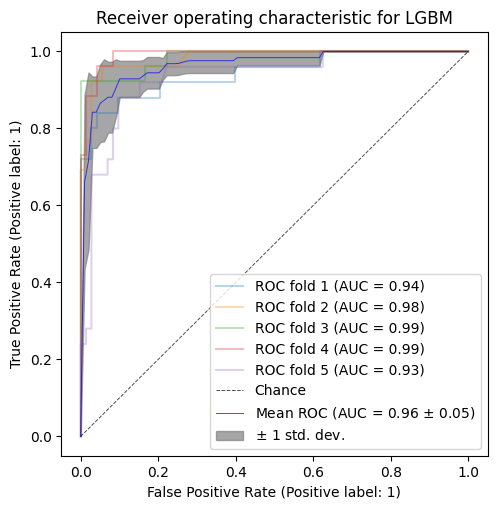

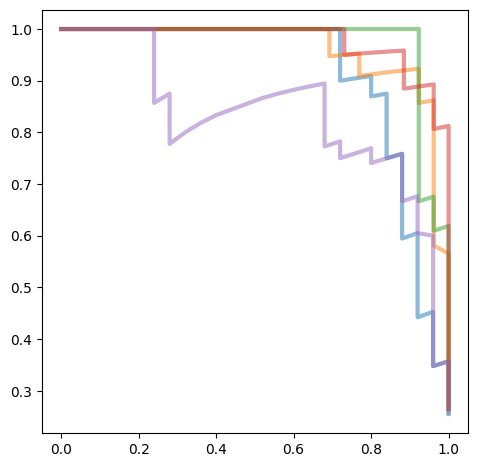

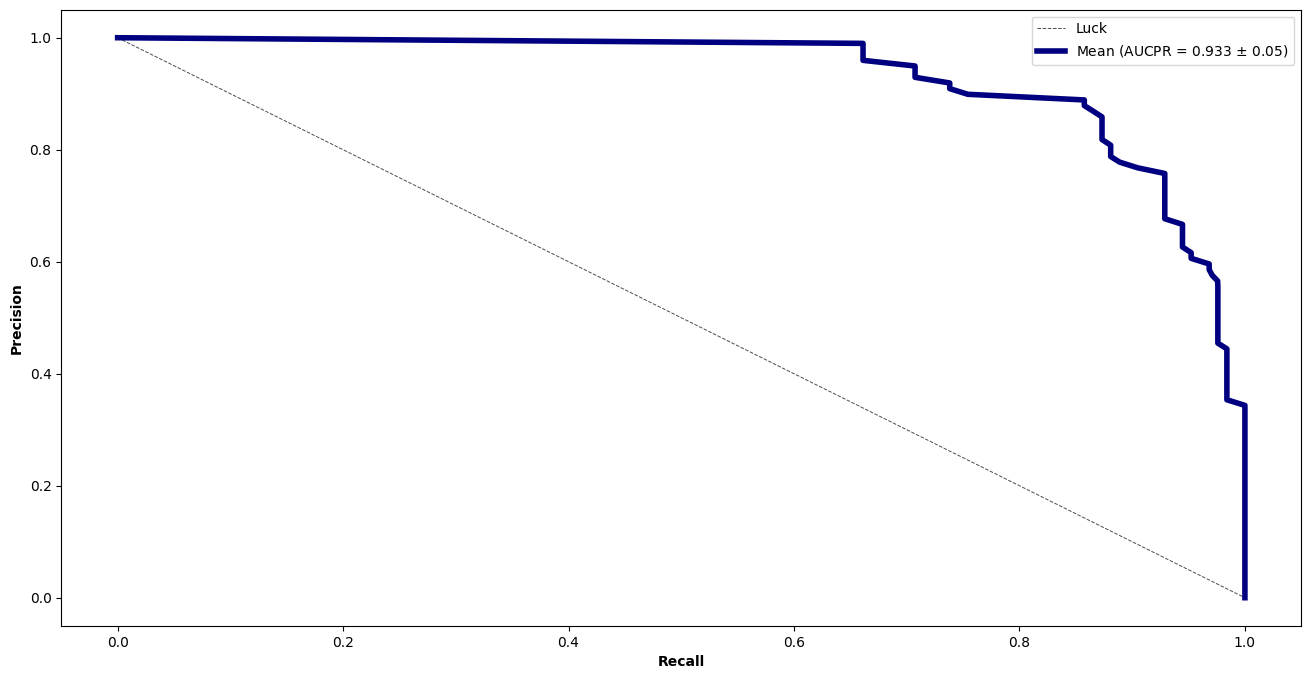

List of possible accuracy: 
 [0.8510638297872342, 0.9056603773584906, 0.9600000000000001, 0.8928571428571429, 0.7499999999999999]
Maximum Accuracy That can be obtained from this model is: 
 96.00000000000001 %
Minimum Accuracy: 
 74.99999999999999 %
Overall Accuracy: 
 87.19162700005735 %
Standard Deviation is: 
 0.07847663598436987
List of possible accuracy for trainning: [98.72122762148338, 99.23273657289002, 98.9769820971867, 99.48849104859335, 99.48979591836735]
List of possible accuracy for testing: [92.85714285714286, 94.89795918367348, 97.95918367346938, 93.87755102040816, 87.62886597938144]
Mean Accuracy: 0.9344414054281508, Mean Precision: 0.882784365393061, Mean Recall: 0.8655384615384616, Mean f1_score: 0.7499999999999999


In [138]:
import xgboost as xgb

clf1 = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=imbalance_ratio)

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

param_grid = {'learning_rate' : uniform(1e-5, 1),
              'max_depth' : randint(3, 25),
              'gamma' : uniform(0.1, 1),
              'subsample': uniform(0.5, 1),
              'colsample_bytree': uniform(0.5, 1),
              'scale_pos_weight': [1, imbalance_ratio]}

train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=param_grid, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1, random_state=seed)
for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy: \n', lst_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is: \n', max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy: \n', min(lst_accu_stratified)*100, '%')
print('Overall Accuracy: \n', mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is: \n', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [139]:
model11 = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=2.825, learning_rate=0.5840561165818847, max_depth=9,
                            gamma=0.9813469974895647, subsample=0.671515024658863, colsample_bytree=0.7659112072356354).fit(X1_train, y1_train)

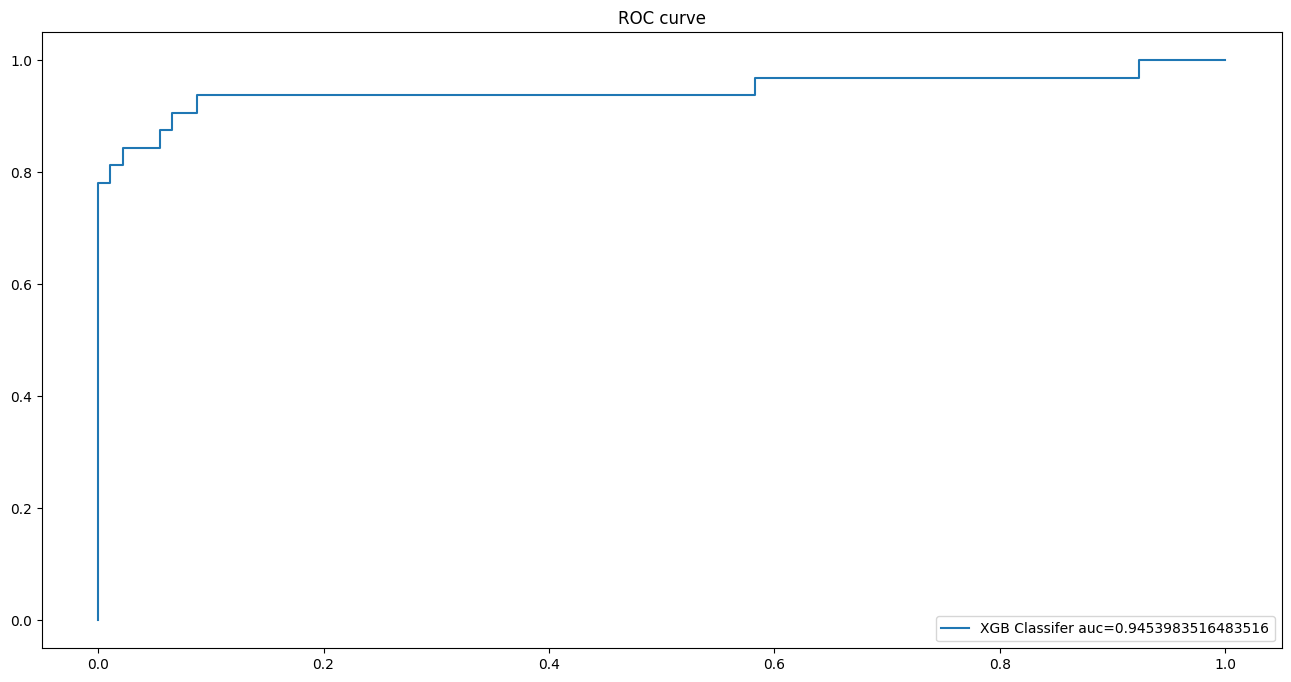

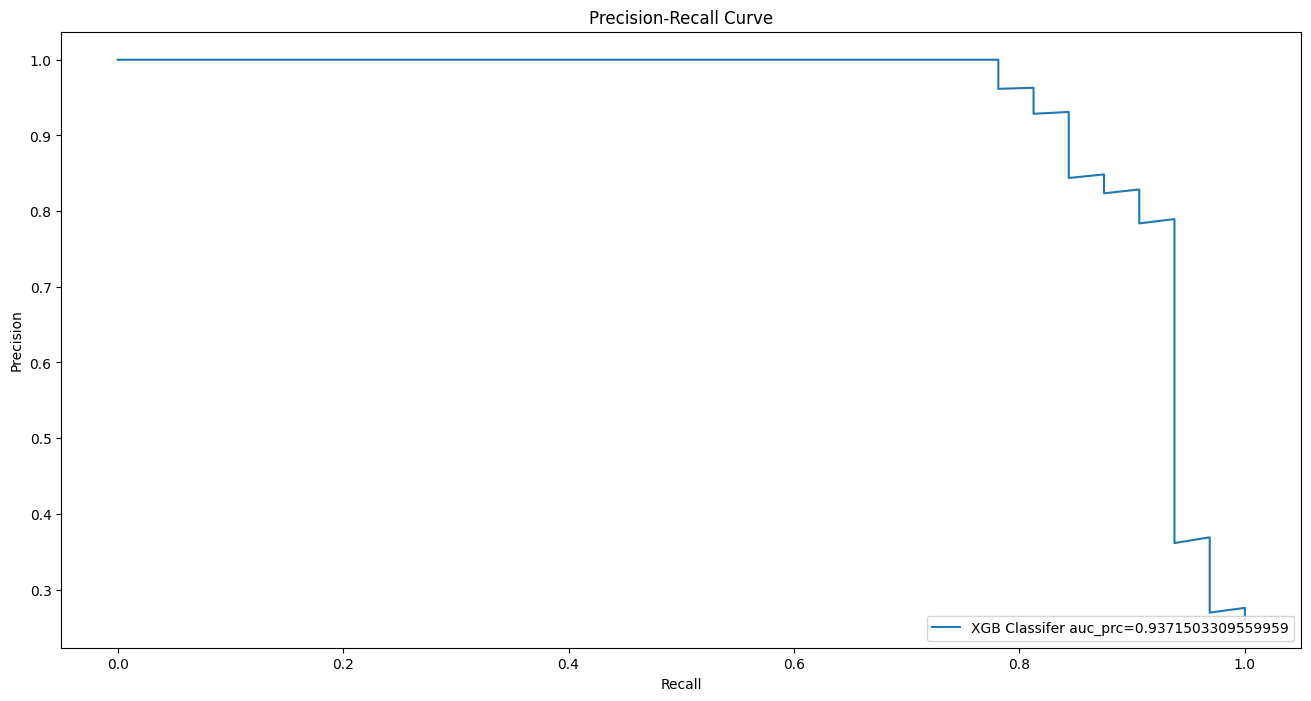

Train Result:
Accuracy Score: 99.39%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    1.000000    0.977099  0.993865    0.988550      0.994006
recall       0.991690    1.000000  0.993865    0.995845      0.993865
f1-score     0.995828    0.988417  0.993865    0.992122      0.993888
support    361.000000  128.000000  0.993865  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[358   3]
 [  0 128]]

Test Result:
Accuracy Score: 91.87%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.976471   0.789474  0.918699    0.882972      0.927821
recall      0.912088   0.937500  0.918699    0.924794      0.918699
f1-score    0.943182   0.857143  0.918699    0.900162      0.920798
support    91.000000  32.000000  0.918699  123.000000    123.000000
___

Model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
Logistic Regression,0.909091,0.939560,0.939148,0.956044,0.937500,0.977528,0.882353
SVM,0.878788,0.941964,0.931986,0.945055,0.906250,0.966292,0.852941
Gradient Boosting,0.906250,0.944712,0.946444,0.967033,0.906250,0.967033,0.906250
Random Forest,0.892308,0.950549,0.922128,0.956044,0.906250,0.966667,0.878788
KNeibors Classifier,0.888889,0.939560,0.928577,0.967033,0.875000,0.956522,0.903226
ExtraTrees Classifier,0.895522,0.953984,0.933634,0.945055,0.937500,0.977273,0.857143
AdaBoost Classifier,0.848485,0.946772,0.865948,0.934066,0.875000,0.955056,0.823529
DecisionTree Classifier,0.875000,0.921360,0.898328,0.956044,0.875000,0.956044,0.875000
GaussianNB,0.560748,0.735920,0.684212,0.505495,0.937500,0.958333,0.400000
LGBM,0.869565,0.956731,0.942530,0.923077,0.937500,0.976744,0.810811


In [143]:
clf = print_auc(model11, X1_train, y1_train, X1_test, y1_test, 'XGB Classifer')
results_df10 = pd.DataFrame(data=[['XGB Classifer', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]], 
                          columns=['Model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
results_df = results_df.append(results_df10, ignore_index=True)

results_df.style.hide_index()

In [144]:
results_df.to_csv('results_df.csv', index=False)

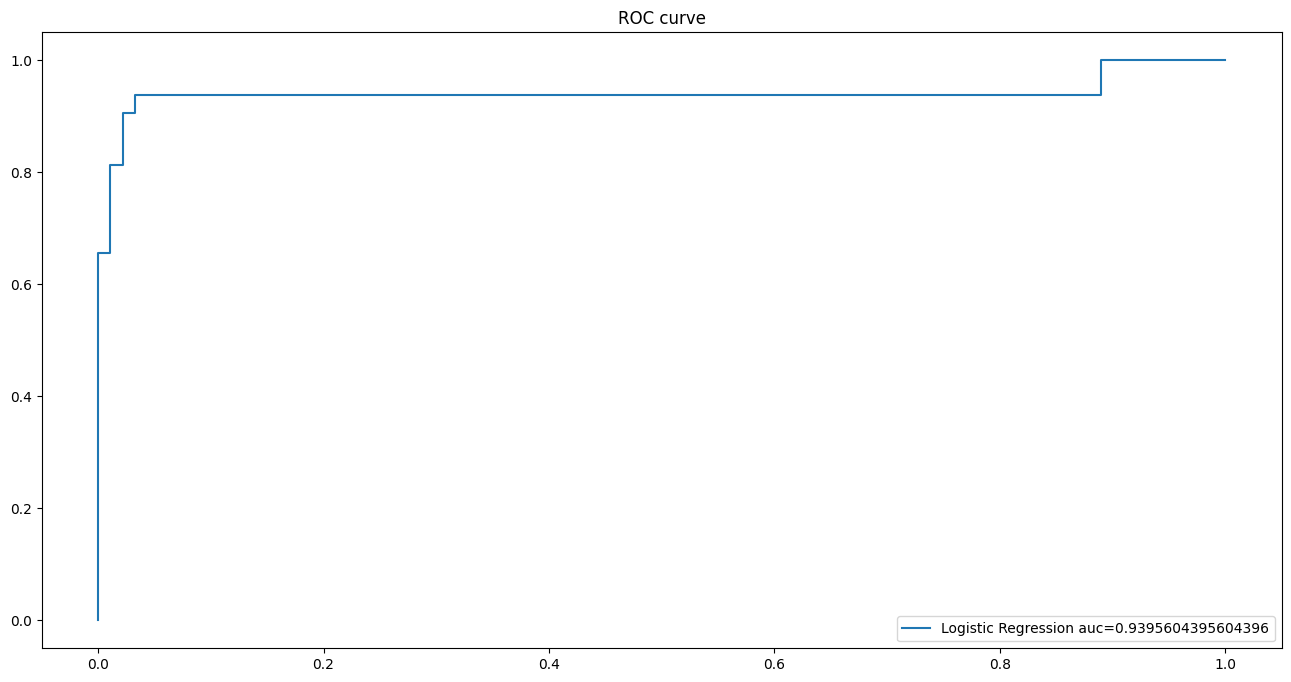

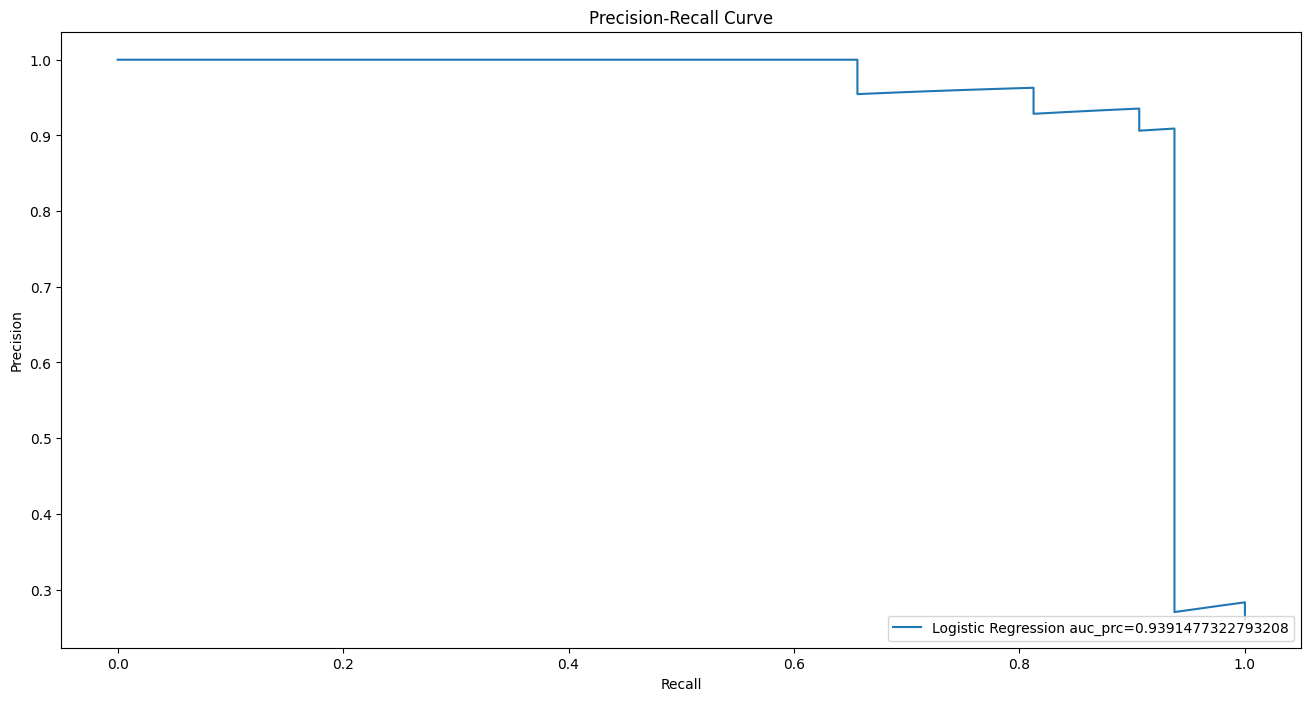

Train Result:
Accuracy Score: 98.57%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    1.000000    0.948148  0.985685    0.974074      0.986427
recall       0.980609    1.000000  0.985685    0.990305      0.985685
f1-score     0.990210    0.973384  0.985685    0.981797      0.985806
support    361.000000  128.000000  0.985685  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[354   7]
 [  0 128]]

Test Result:
Accuracy Score: 95.12%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.977528   0.882353   0.95122    0.929941      0.952767
recall      0.956044   0.937500   0.95122    0.946772      0.951220
f1-score    0.966667   0.909091   0.95122    0.937879      0.951688
support    91.000000  32.000000   0.95122  123.000000    123.000000
___

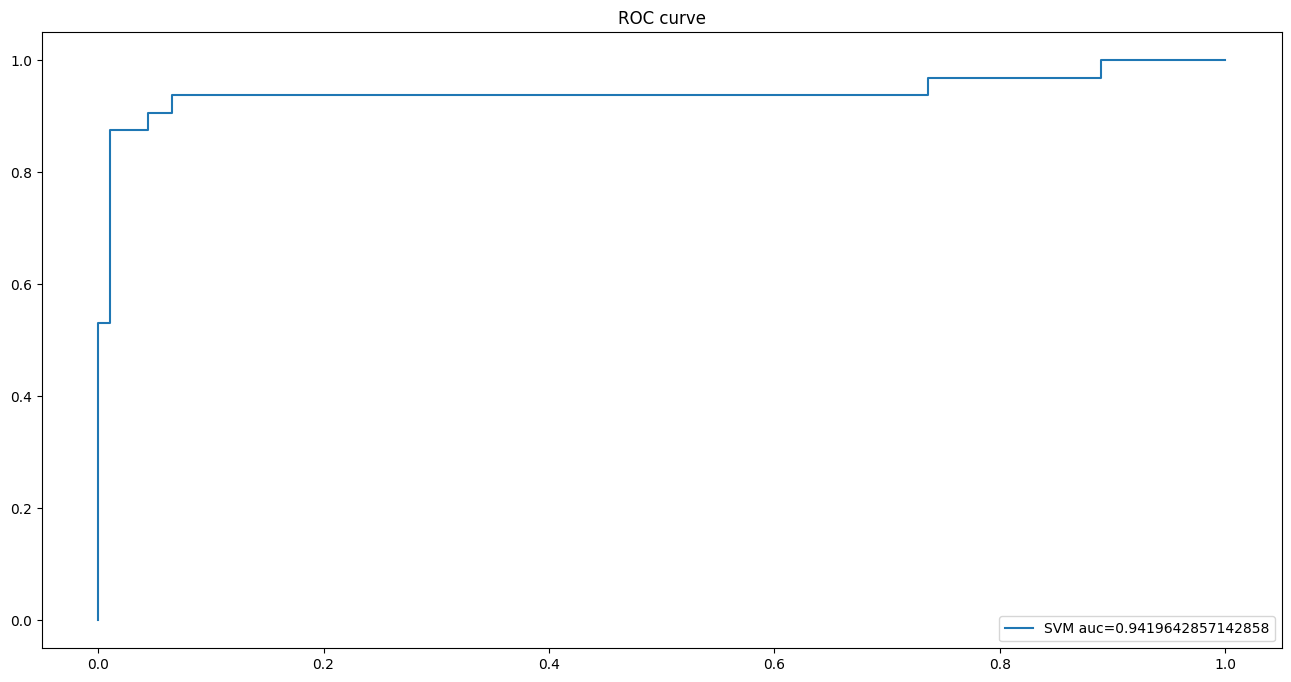

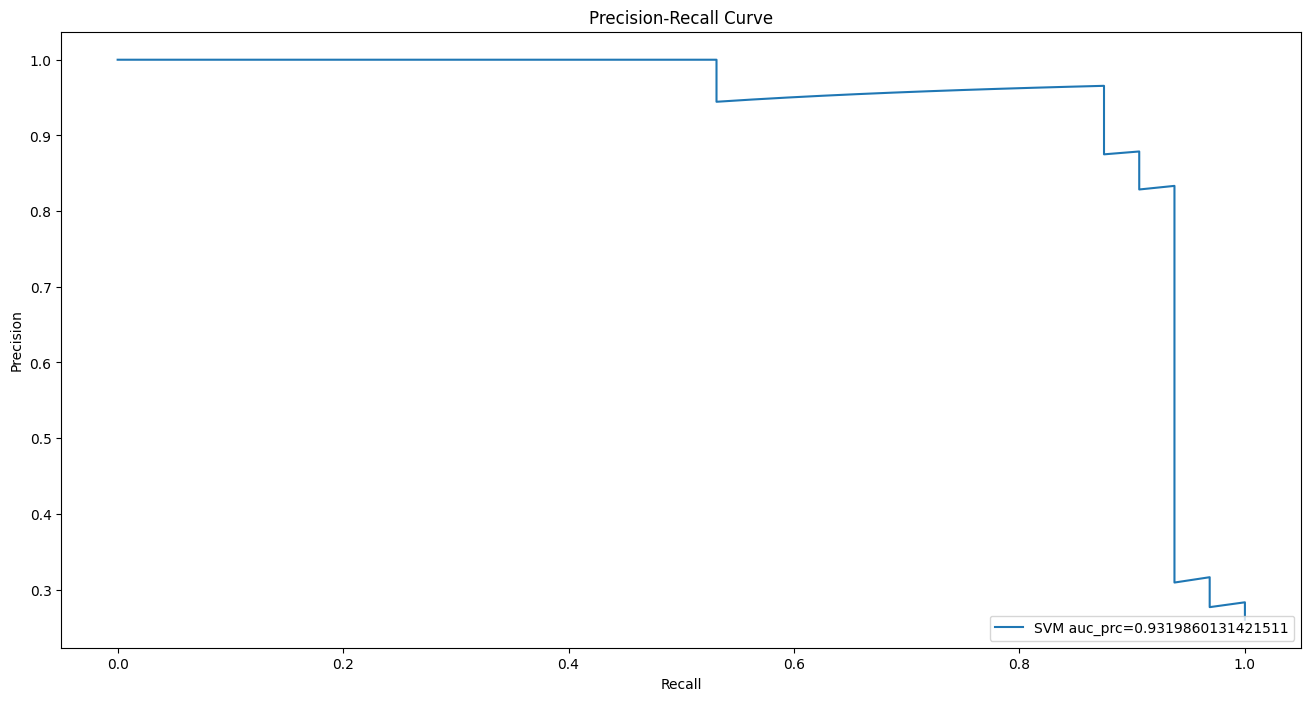

Train Result:
Accuracy Score: 96.52%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.983146    0.917293  0.965235    0.950220      0.965909
recall       0.969529    0.953125  0.965235    0.961327      0.965235
f1-score     0.976290    0.934866  0.965235    0.955578      0.965447
support    361.000000  128.000000  0.965235  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[350  11]
 [  6 122]]

Test Result:
Accuracy Score: 93.50%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.966292   0.852941  0.934959    0.909617      0.936802
recall      0.945055   0.906250  0.934959    0.925652      0.934959
f1-score    0.955556   0.878788  0.934959    0.917172      0.935583
support    91.000000  32.000000  0.934959  123.000000    123.000000
___

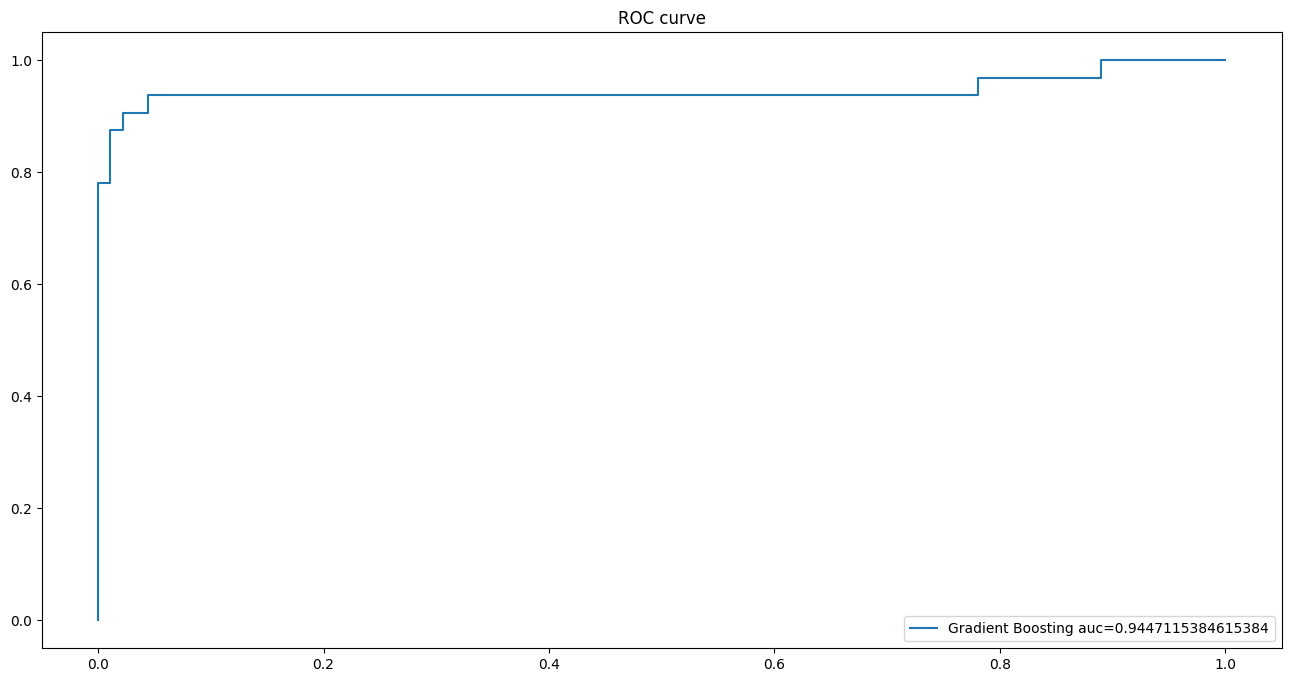

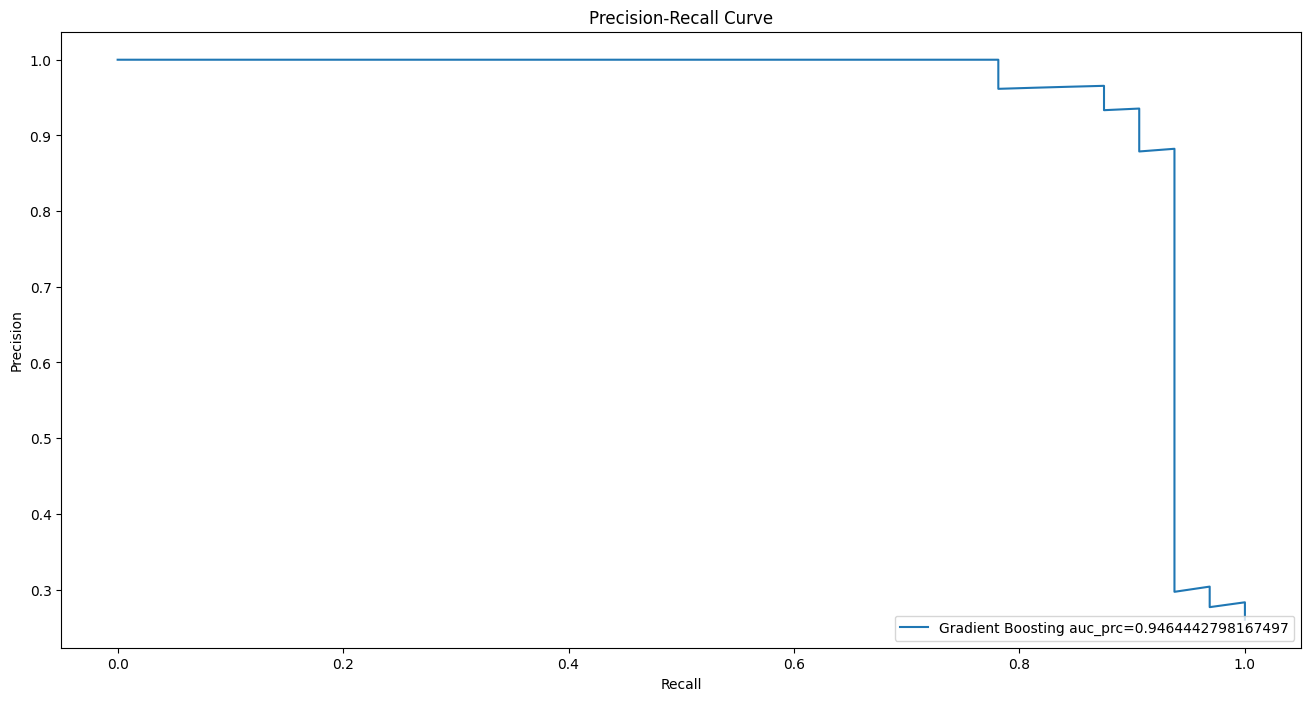

Train Result:
Accuracy Score: 99.80%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    1.000000    0.992248  0.997955    0.996124      0.997971
recall       0.997230    1.000000  0.997955    0.998615      0.997955
f1-score     0.998613    0.996109  0.997955    0.997361      0.997958
support    361.000000  128.000000  0.997955  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[360   1]
 [  0 128]]

Test Result:
Accuracy Score: 95.12%
_______________________________________________
CLASSIFICATION REPORT:
                   0         1  accuracy   macro avg  weighted avg
precision   0.967033   0.90625   0.95122    0.936641       0.95122
recall      0.967033   0.90625   0.95122    0.936641       0.95122
f1-score    0.967033   0.90625   0.95122    0.936641       0.95122
support    91.000000  32.00000   0.95122  123.000000     123.00000
________

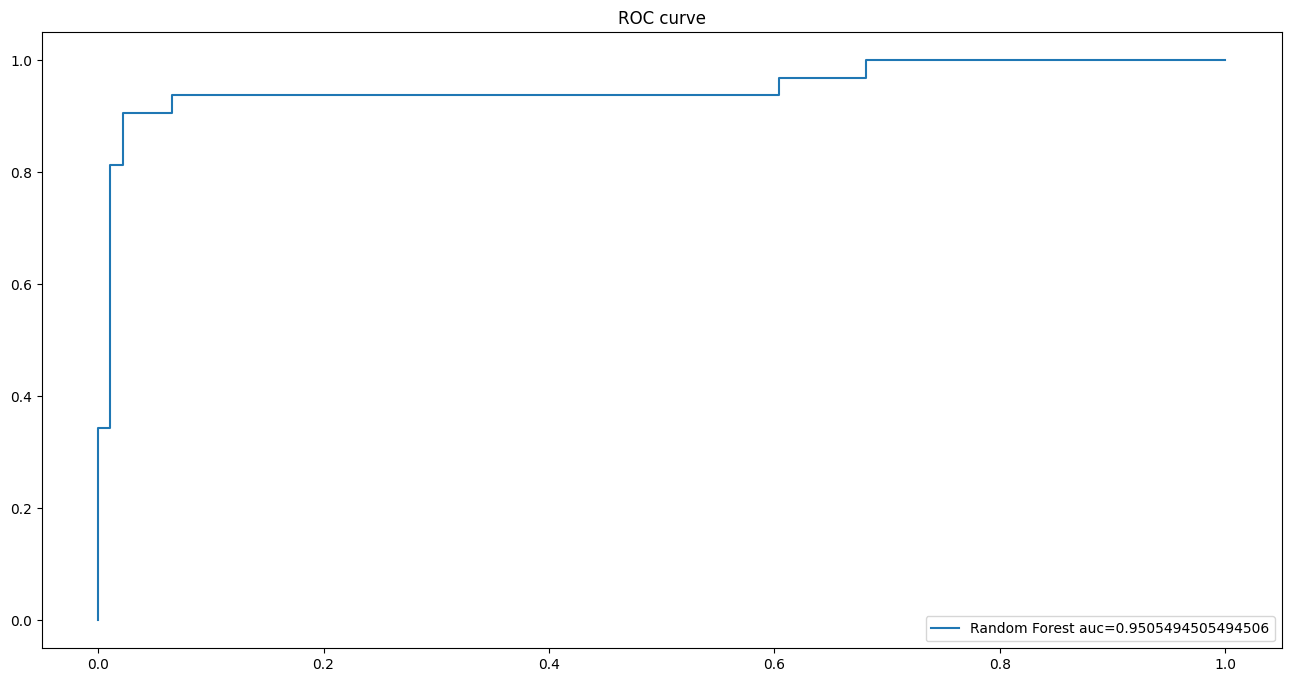

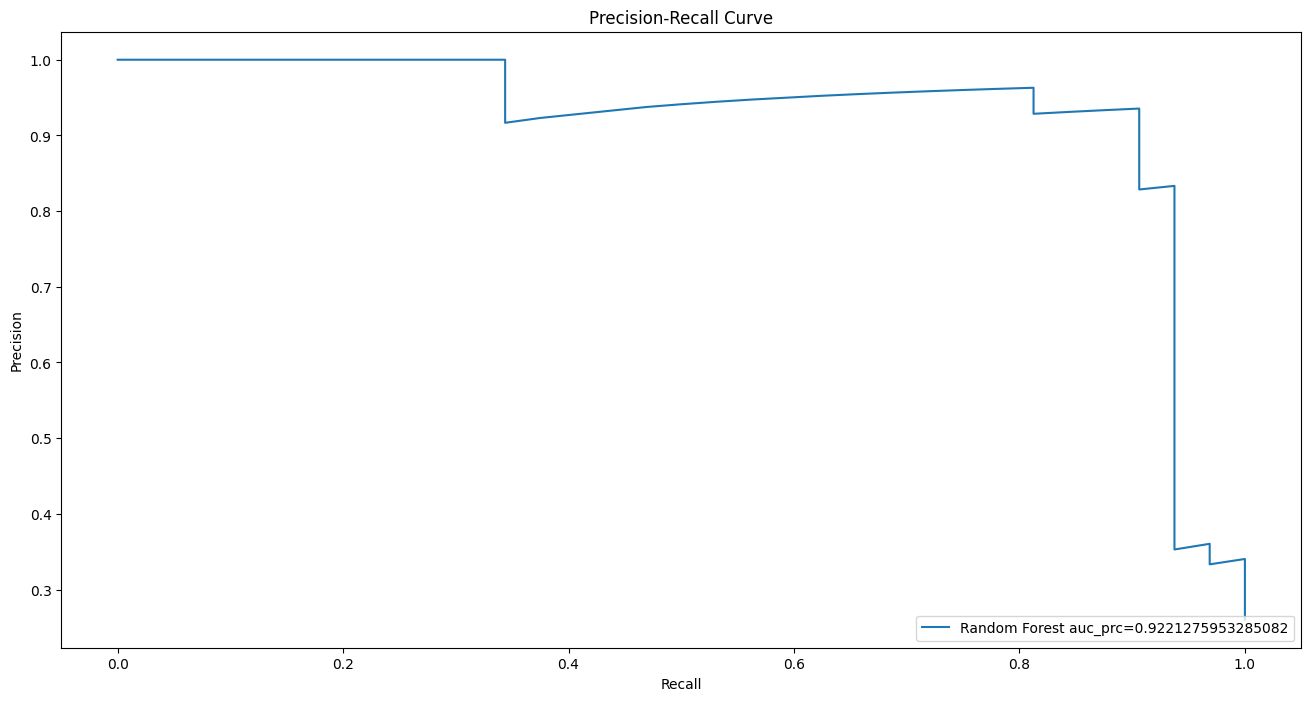

Train Result:
Accuracy Score: 97.55%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.980716    0.960317   0.97546    0.970517      0.975377
recall       0.986150    0.945312   0.97546    0.965731      0.975460
f1-score     0.983425    0.952756   0.97546    0.968091      0.975397
support    361.000000  128.000000   0.97546  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[356   5]
 [  7 121]]

Test Result:
Accuracy Score: 94.31%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.966667   0.878788  0.943089    0.922727      0.943804
recall      0.956044   0.906250  0.943089    0.931147      0.943089
f1-score    0.961326   0.892308  0.943089    0.926817      0.943370
support    91.000000  32.000000  0.943089  123.000000    123.000000
___

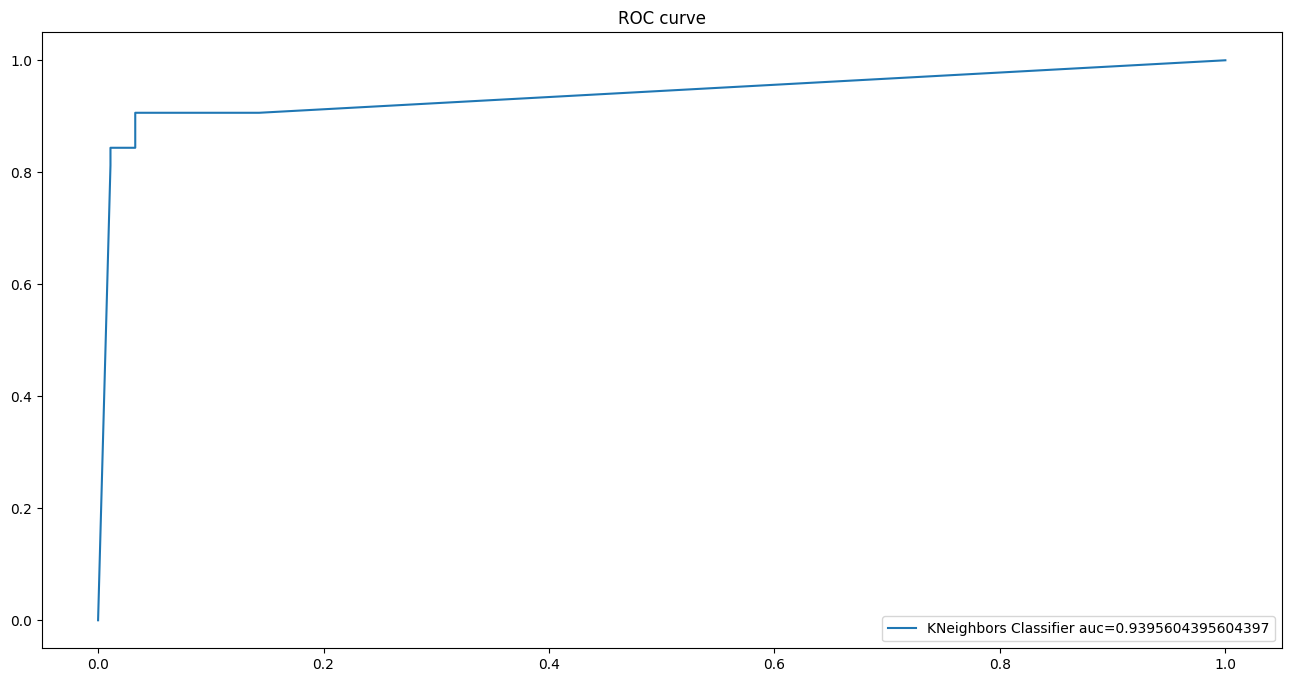

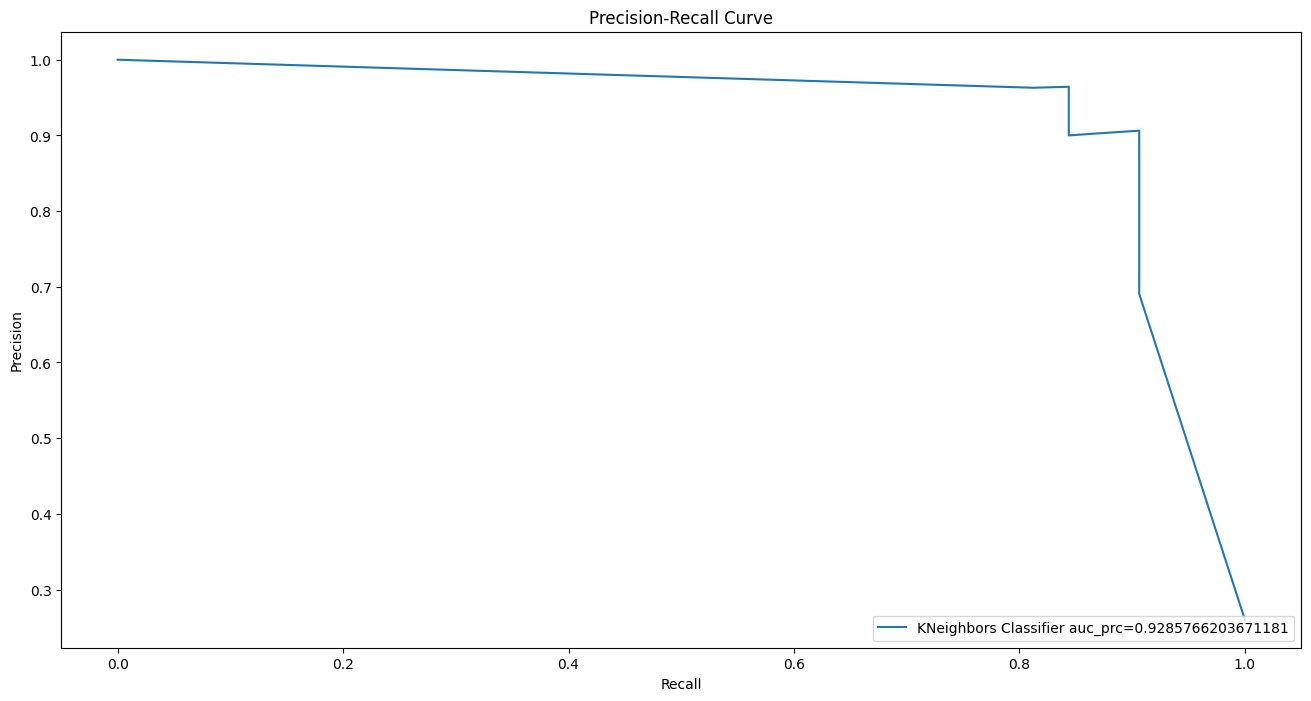

Train Result:
Accuracy Score: 99.80%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.997238    1.000000  0.997955    0.998619      0.997961
recall       1.000000    0.992188  0.997955    0.996094      0.997955
f1-score     0.998617    0.996078  0.997955    0.997348      0.997952
support    361.000000  128.000000  0.997955  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[361   0]
 [  1 127]]

Test Result:
Accuracy Score: 94.31%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.956522   0.903226  0.943089    0.929874      0.942656
recall      0.967033   0.875000  0.943089    0.921016      0.943089
f1-score    0.961749   0.888889  0.943089    0.925319      0.942793
support    91.000000  32.000000  0.943089  123.000000    123.000000
___

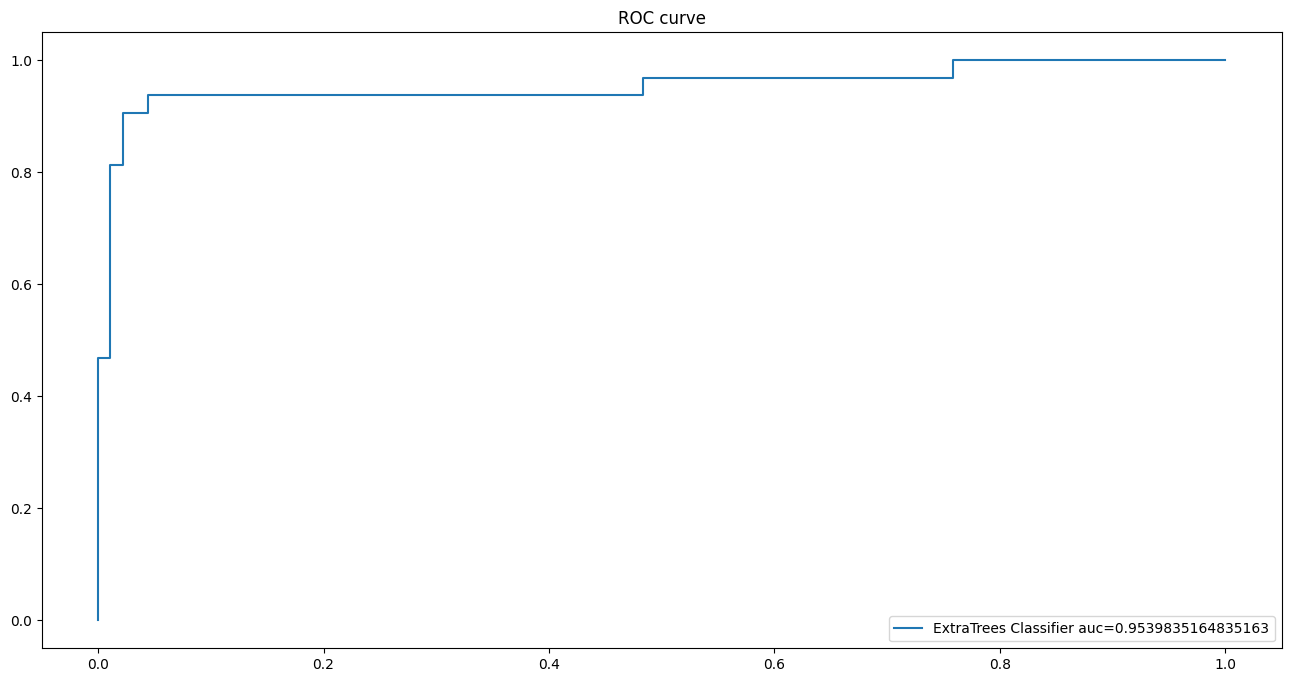

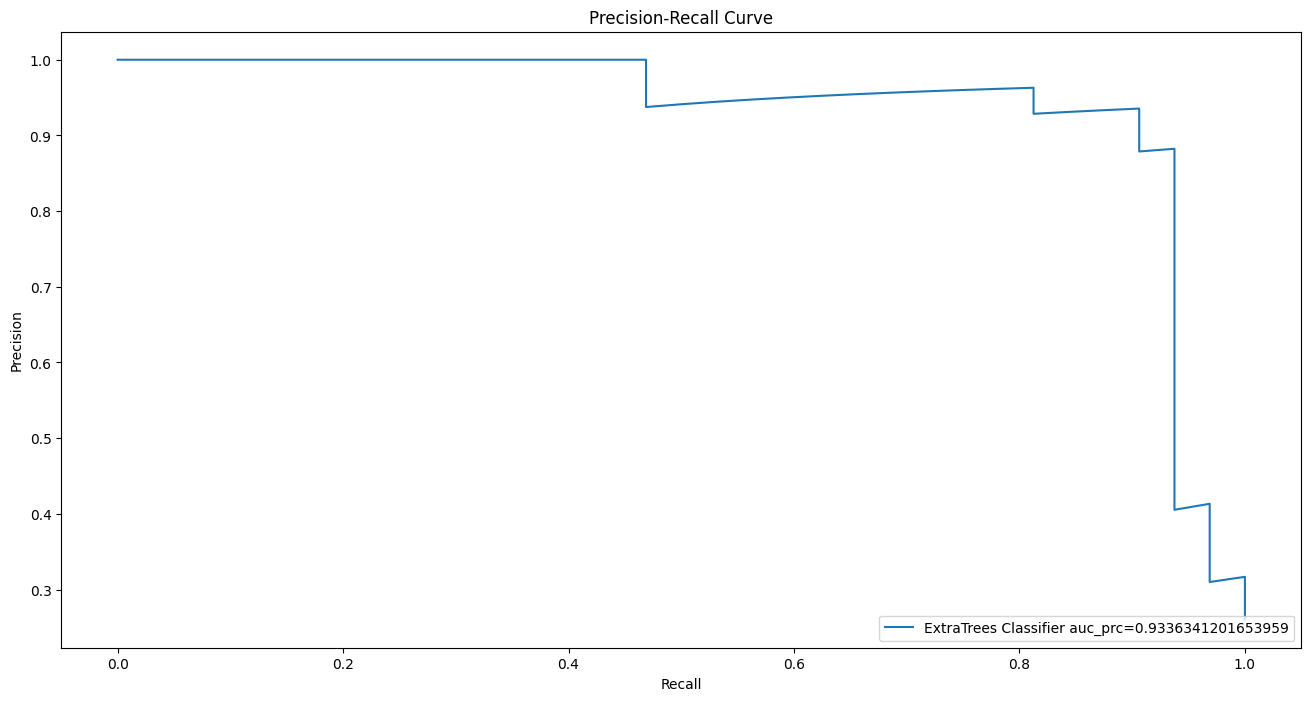

Train Result:
Accuracy Score: 98.16%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.991620    0.954198  0.981595    0.972909      0.981825
recall       0.983380    0.976562  0.981595    0.979971      0.981595
f1-score     0.987483    0.965251  0.981595    0.976367      0.981663
support    361.000000  128.000000  0.981595  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[355   6]
 [  3 125]]

Test Result:
Accuracy Score: 94.31%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.977273   0.857143  0.943089    0.917208      0.946019
recall      0.945055   0.937500  0.943089    0.941277      0.943089
f1-score    0.960894   0.895522  0.943089    0.928208      0.943887
support    91.000000  32.000000  0.943089  123.000000    123.000000
___

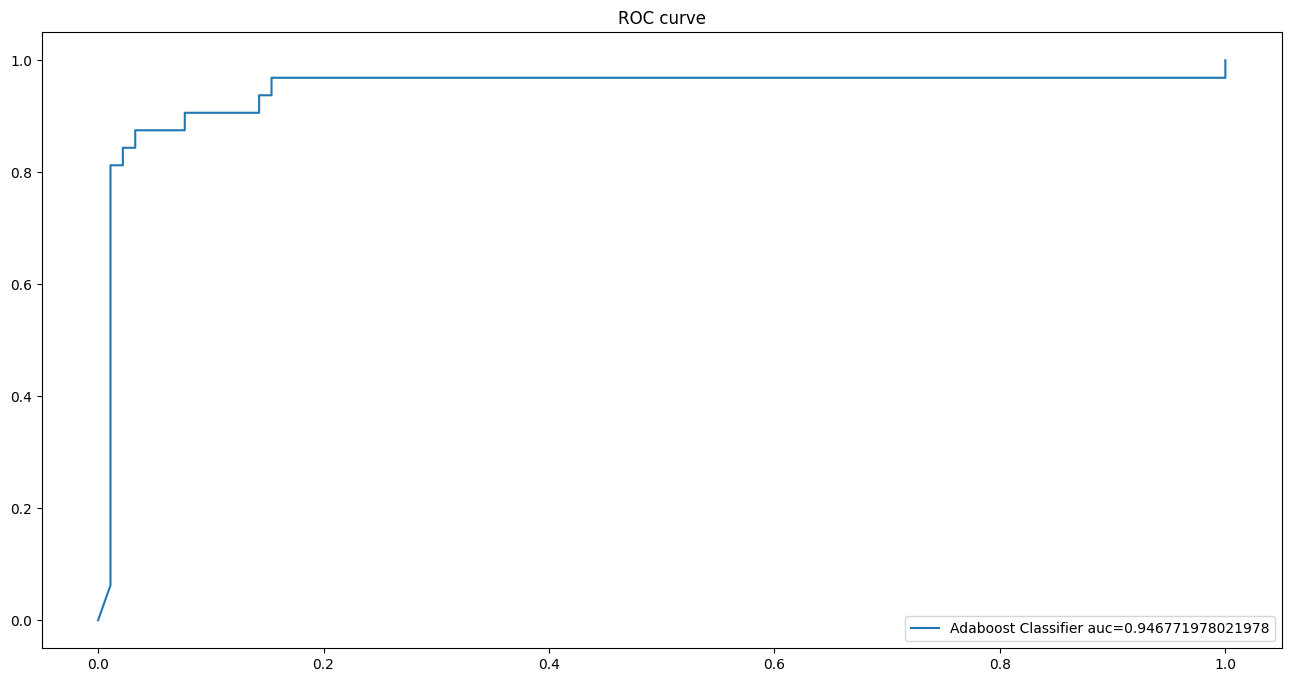

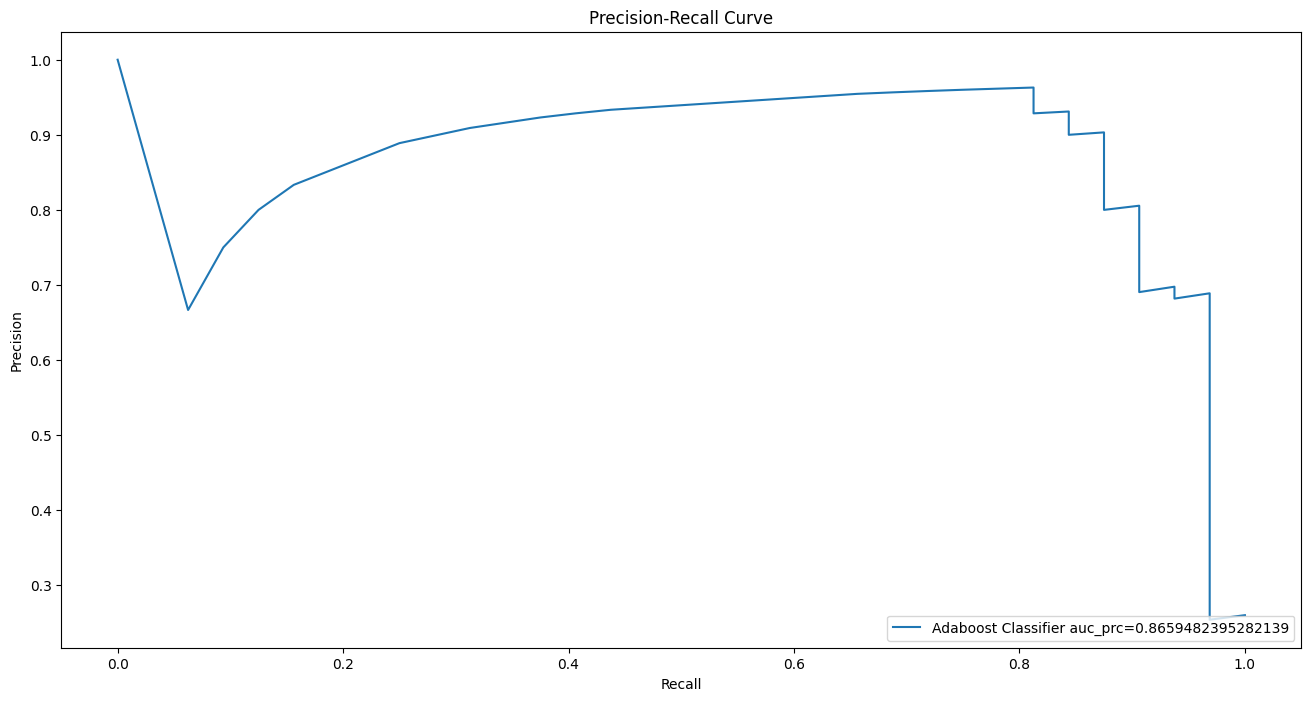

Train Result:
Accuracy Score: 99.80%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    1.000000    0.992248  0.997955    0.996124      0.997971
recall       0.997230    1.000000  0.997955    0.998615      0.997955
f1-score     0.998613    0.996109  0.997955    0.997361      0.997958
support    361.000000  128.000000  0.997955  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[360   1]
 [  0 128]]

Test Result:
Accuracy Score: 91.87%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.955056   0.823529  0.918699    0.889293      0.920838
recall      0.934066   0.875000  0.918699    0.904533      0.918699
f1-score    0.944444   0.848485  0.918699    0.896465      0.919479
support    91.000000  32.000000  0.918699  123.000000    123.000000
___

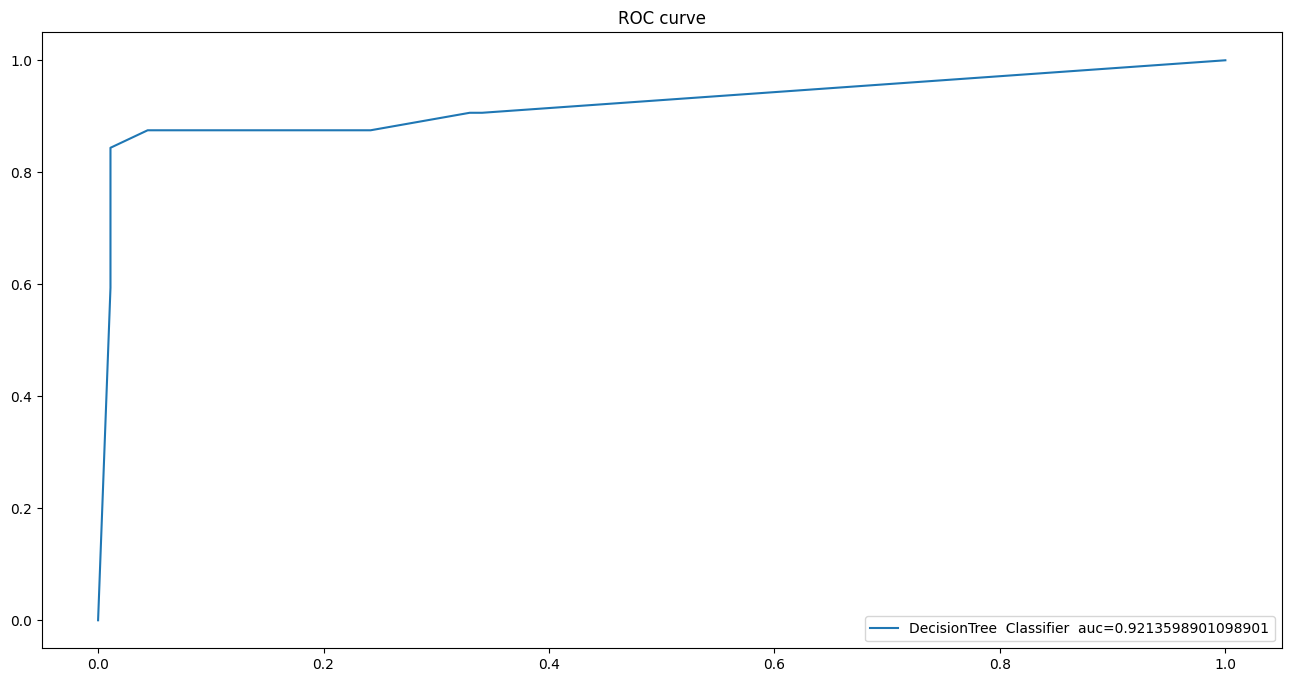

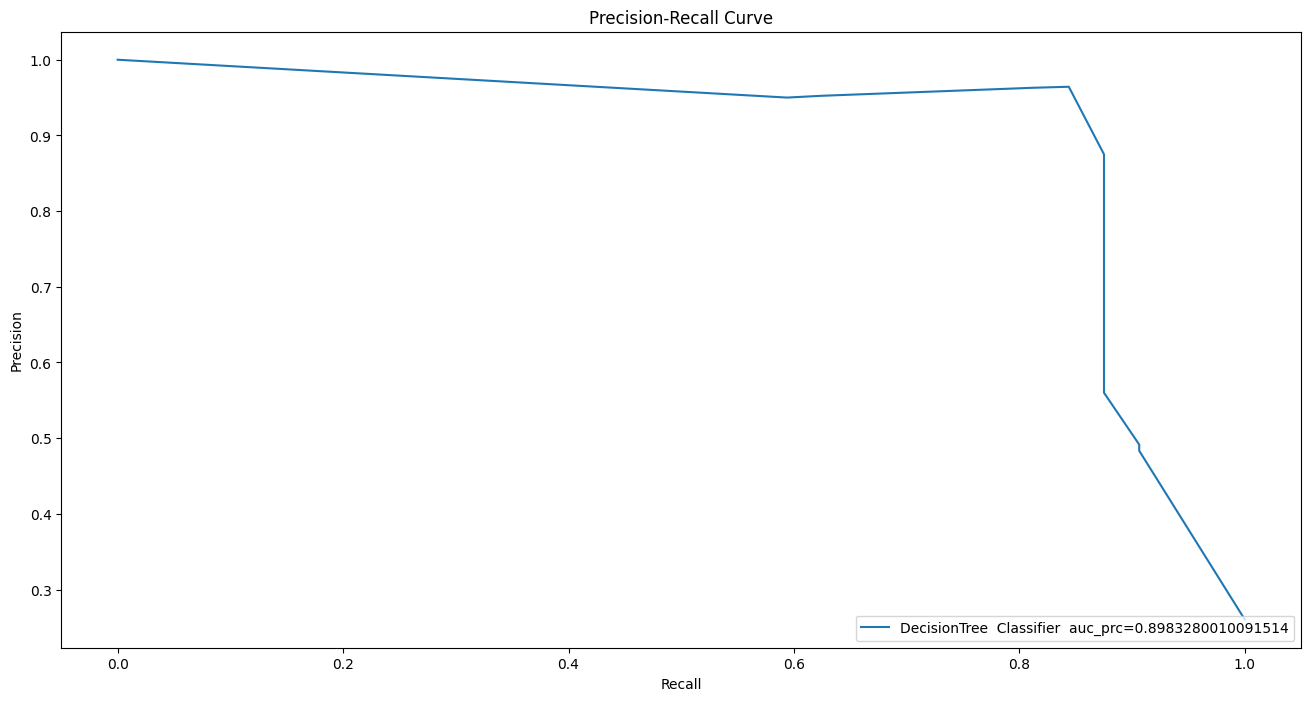

Train Result:
Accuracy Score: 93.87%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.943700    0.922414   0.93865    0.933057      0.938128
recall       0.975069    0.835938   0.93865    0.905503      0.938650
f1-score     0.959128    0.877049   0.93865    0.918089      0.937643
support    361.000000  128.000000   0.93865  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[352   9]
 [ 21 107]]

Test Result:
Accuracy Score: 93.50%
_______________________________________________
CLASSIFICATION REPORT:
                   0       1  accuracy   macro avg  weighted avg
precision   0.956044   0.875  0.934959    0.915522      0.934959
recall      0.956044   0.875  0.934959    0.915522      0.934959
f1-score    0.956044   0.875  0.934959    0.915522      0.934959
support    91.000000  32.000  0.934959  123.000000    123.000000
__________________

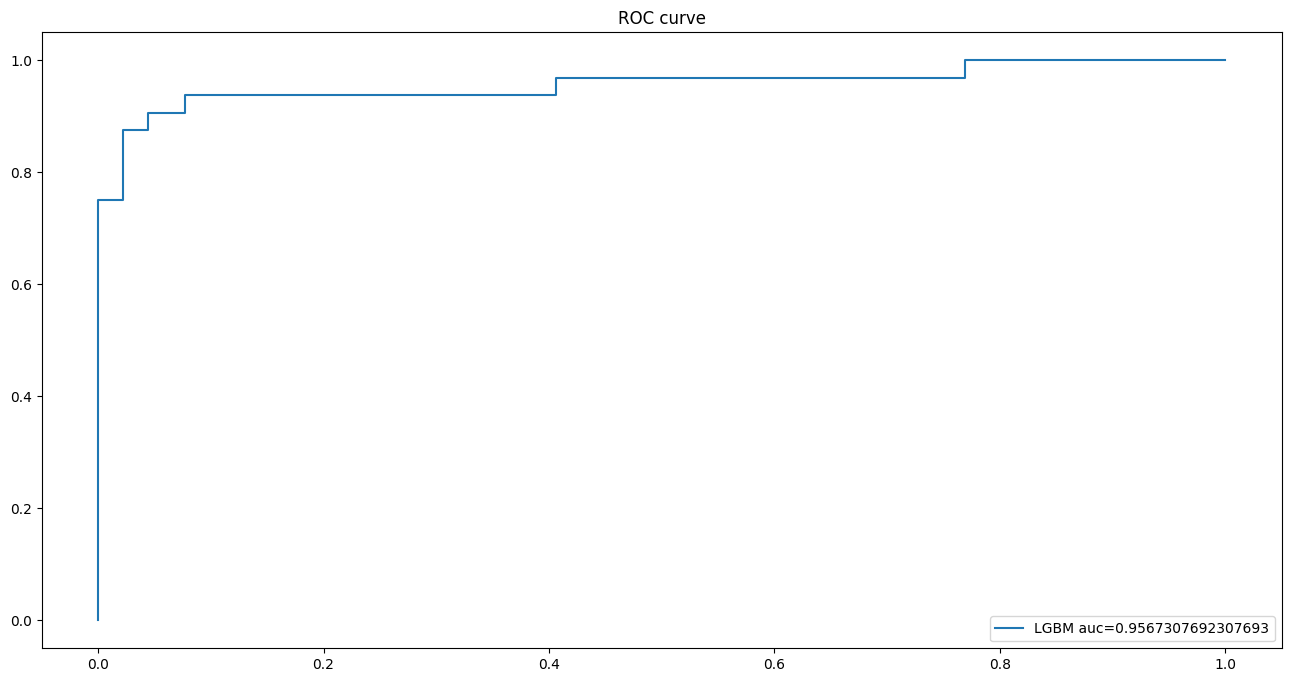

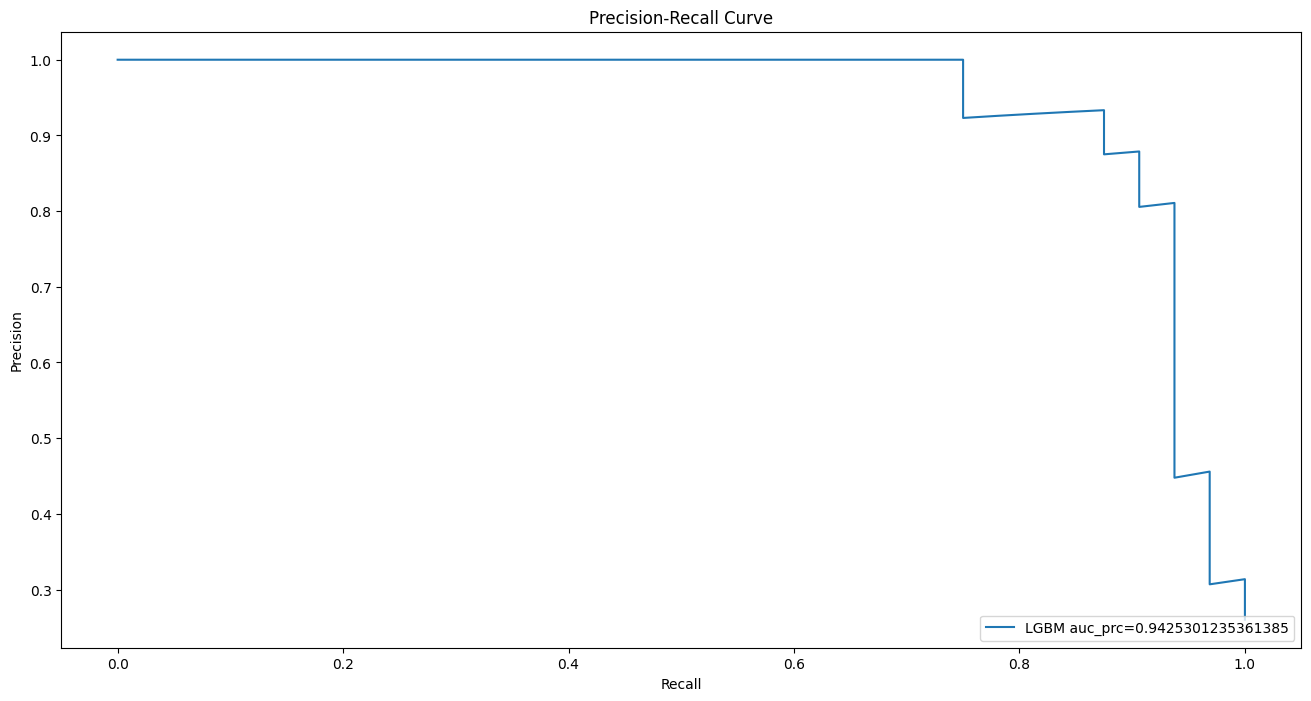

Train Result:
Accuracy Score: 99.39%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    1.000000    0.977099  0.993865    0.988550      0.994006
recall       0.991690    1.000000  0.993865    0.995845      0.993865
f1-score     0.995828    0.988417  0.993865    0.992122      0.993888
support    361.000000  128.000000  0.993865  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[358   3]
 [  0 128]]

Test Result:
Accuracy Score: 92.68%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.976744   0.810811  0.926829    0.893777      0.933575
recall      0.923077   0.937500  0.926829    0.930288      0.926829
f1-score    0.949153   0.869565  0.926829    0.909359      0.928447
support    91.000000  32.000000  0.926829  123.000000    123.000000
___

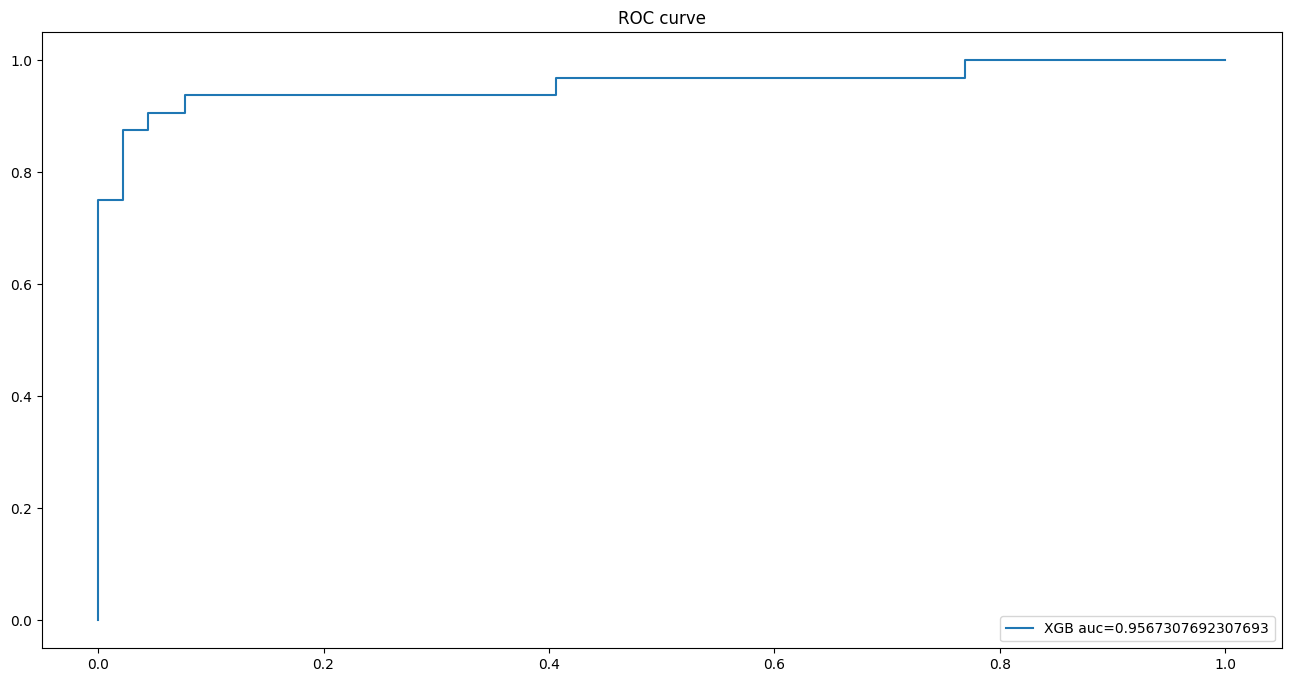

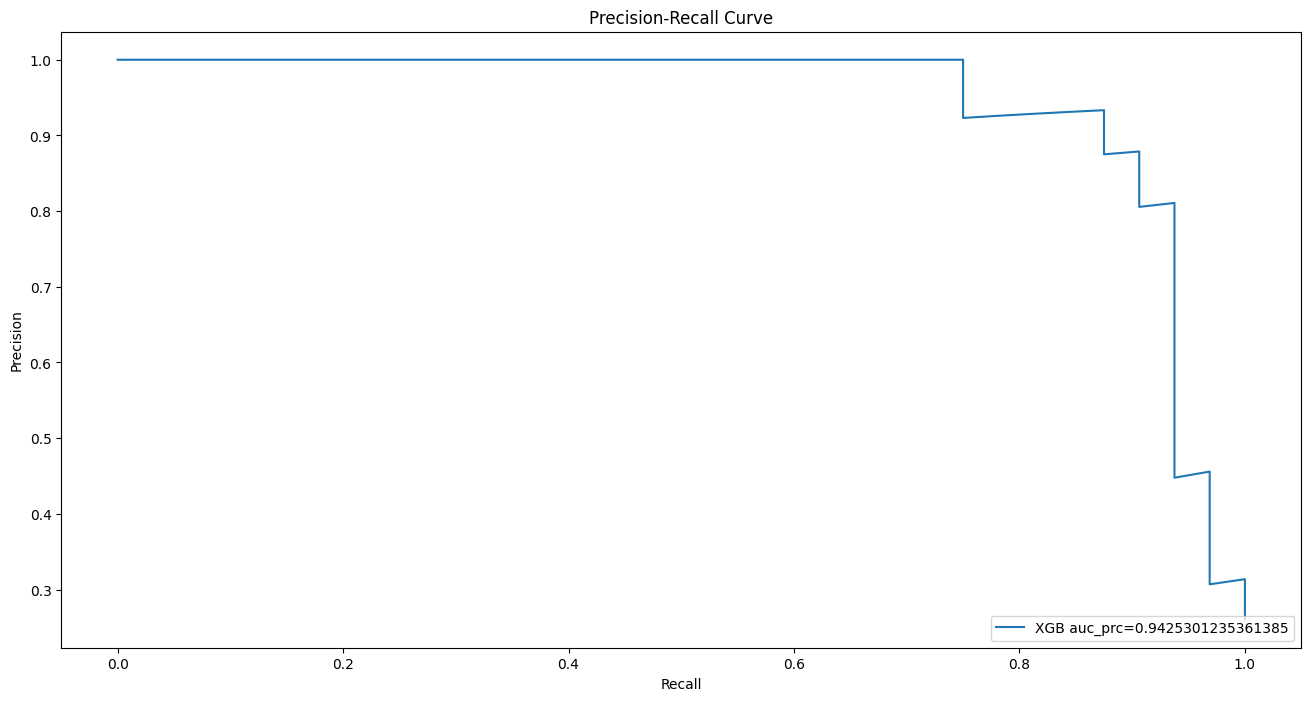

Train Result:
Accuracy Score: 99.39%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    1.000000    0.977099  0.993865    0.988550      0.994006
recall       0.991690    1.000000  0.993865    0.995845      0.993865
f1-score     0.995828    0.988417  0.993865    0.992122      0.993888
support    361.000000  128.000000  0.993865  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[358   3]
 [  0 128]]

Test Result:
Accuracy Score: 92.68%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.976744   0.810811  0.926829    0.893777      0.933575
recall      0.923077   0.937500  0.926829    0.930288      0.926829
f1-score    0.949153   0.869565  0.926829    0.909359      0.928447
support    91.000000  32.000000  0.926829  123.000000    123.000000
___

In [145]:
clf1 = print_auc(model1, X1_train, y1_train, X1_test, y1_test, "Logistic Regression")
clf2 = print_auc(model2, X1_train, y1_train, X1_test, y1_test, "SVM")
clf3 = print_auc(model3, X1_train, y1_train, X1_test, y1_test, "Gradient Boosting")
clf4 = print_auc(model4, X1_train, y1_train, X1_test, y1_test, "Random Forest")
clf5 = print_auc(model5, X1_train, y1_train, X1_test, y1_test, "KNeighbors Classifier")
clf6 = print_auc(model6, X1_train, y1_train, X1_test, y1_test, "ExtraTrees Classifier")
clf7 = print_auc(model7, X1_train, y1_train, X1_test, y1_test, "Adaboost Classifier")
clf8 = print_auc(model8, X1_train, y1_train, X1_test, y1_test, "DecisionTree  Classifier ")
clf10 = print_auc(model10, X1_train, y1_train, X1_test, y1_test, "LGBM")
clf11 = print_auc(model10, X1_train, y1_train, X1_test, y1_test, "XGB")

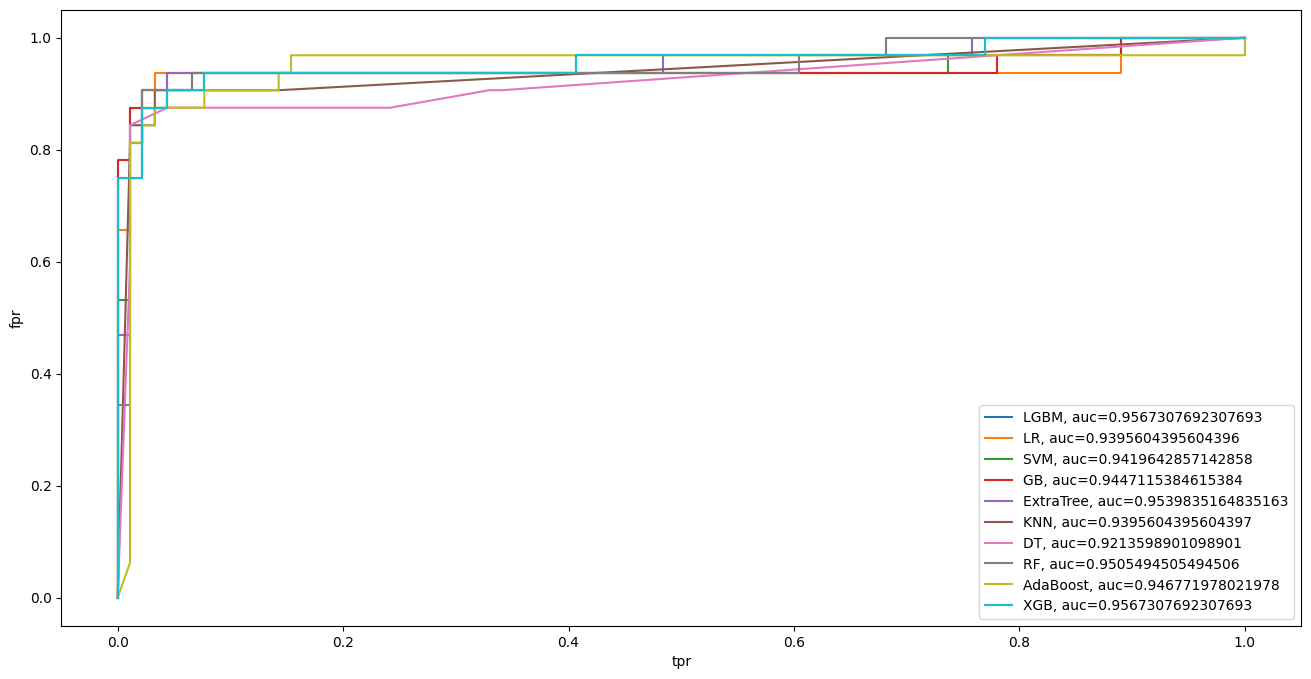

In [146]:
plt.rcParams["figure.figsize"] = [16, 8]
plt.plot(clf10["fpr"], clf10["tpr"], label="LGBM, auc="+str(clf10["auc"]))
plt.plot(clf1["fpr"], clf1["tpr"], label="LR, auc="+str(clf1["auc"]))
plt.plot(clf2["fpr"], clf2["tpr"], label="SVM, auc="+str(clf2["auc"]))
plt.plot(clf3["fpr"], clf3["tpr"], label="GB, auc="+str(clf3["auc"]))
plt.plot(clf6["fpr"], clf6["tpr"], label="ExtraTree, auc="+str(clf6["auc"]))
plt.plot(clf5["fpr"], clf5["tpr"], label="KNN, auc="+str(clf5["auc"]))
plt.plot(clf8["fpr"], clf8["tpr"], label="DT, auc="+str(clf8["auc"]))

plt.plot(clf4["fpr"], clf4["tpr"], label="RF, auc="+str(clf4["auc"]))
plt.plot(clf7["fpr"], clf7["tpr"], label="AdaBoost, auc="+str(clf7["auc"]))
plt.plot(clf11["fpr"], clf11["tpr"], label="XGB, auc="+str(clf11["auc"]))

plt.xlabel("tpr")
plt.ylabel("fpr")
plt.legend(loc=4)
plt.savefig('figure.png', dpi=300)
plt.show()
